# **Importing Packages**

Make sure to install the packages before importing if needed.

In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
import seaborn as sns
import os
import re
import glob
#import bbknn
#import joypy
import igraph
import leidenalg
import mygene
import sccoda

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz
from scipy import sparse
from scipy.stats import gaussian_kde
from textwrap import fill
from matplotlib import cm

# **Loading Data**

To see requirements for all AnnData objects (CELLxCELL): https://github.com/chanzuckerberg/single-cell-curation/blob/main/schema/7.0.0/schema.md.

In [2]:
# Make sure to set your own path to the data file
# adata = sc.read_h5ad(".../.../77k_AD_PD_CTRL.h5ad")

## Path - Elodie
# adata = sc.read_h5ad("/Users/elodiehusson/Desktop/AD & PD/77k_AD_PD_CTRL.h5ad")

## Path - Yara 
adata = sc.read_h5ad("C:/Users/yarad/Desktop/x/Masters/Master BMC - Sorbonne/M2/Single Cell/Project/Coding Project/77k_AD_PD_CTRL.h5ad")

In [6]:
# Creating adata_raw (needed for DE)
adata_raw = adata.copy()

In [7]:
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 77052 × 34176
    obs: 'Source', 'n_genes', 'n_counts', 'class', 'subclass', 'subtype', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'AD_status', 'DLBD_status', 'FTD_status', 'Tauopathy_status', 'Vascular_status', 'ASCVD_status', 'Schizophrenia', 'Bipolar_Disorder', 'Parkinson_disease', 'Tardive_dyskinesia', 'genetic_ancestry', 'disease_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_name', 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'class_colors', 'genome', 'organism', 'organism_ontology_t

The studied conditions are the following:

In [8]:
studied_conditions = adata.obs.groupby(["disease", "AD_status", "Parkinson_disease"]).size()
studied_conditions

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3882879008.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  studied_conditions = adata.obs.groupby(["disease", "AD_status", "Parkinson_disease"]).size()


disease                        AD_status  Parkinson_disease
dementia || Alzheimer disease  No         No                       0
                                          Yes                      0
                               Yes        No                   31949
                                          Yes                      0
dementia || Parkinson disease  No         No                       0
                                          Yes                   7772
                               Yes        No                       0
                                          Yes                      0
normal                         No         No                   37331
                                          Yes                      0
                               Yes        No                       0
                                          Yes                      0
dtype: int64

## **Reduced Dataset's Metadata**

### *adata*
scanpy shows a structured summary:

In [9]:
adata

AnnData object with n_obs × n_vars = 77052 × 34176
    obs: 'Source', 'n_genes', 'n_counts', 'class', 'subclass', 'subtype', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'AD_status', 'DLBD_status', 'FTD_status', 'Tauopathy_status', 'Vascular_status', 'ASCVD_status', 'Schizophrenia', 'Bipolar_Disorder', 'Parkinson_disease', 'Tardive_dyskinesia', 'genetic_ancestry', 'disease_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'gene_name', 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'class_colors', 'genome', 'organism', 'organism_ontology_term_id', 'schema_reference', 'sche

In [10]:
# This is the sparse matrix
print("adata.X type is :", type(adata.X))

print(adata.X[:5, :5])

adata.X type is : <class 'scipy.sparse._csr.csr_matrix'>
<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3 stored elements and shape (5, 5)>
  Coords	Values
  (1, 2)	3.0
  (3, 4)	1.0
  (4, 4)	5.0


In [11]:
print(f"The variable adata has the following shape: {adata.shape}.")
print(f"There are {adata.shape[0]} cells and {adata.shape[1]} genes in this dataset.")

The variable adata has the following shape: (77052, 34176).
There are 77052 cells and 34176 genes in this dataset.


### *adata.obs*

In [12]:
adata.obs.head()

Source  n_genes  n_counts   class  \
barcodekey                                                         
Donor_865-1-AAACCCACAAGACTGG-0      R     3397    8087.0  Immune   
Donor_865-1-AAACCCAGTGAATATG-0      R     6829   28101.0      EN   
Donor_865-1-AAACCCATCTTTCCGG-0      R     2628    5522.0   Oligo   
Donor_865-1-AAACGAATCAATCGGT-0      R     5998   24035.0      IN   
Donor_865-1-AAACGAATCGTTCTAT-0      R     2425    5217.0   Oligo   

                                    subclass           subtype  \
barcodekey                                                       
Donor_865-1-AAACCCACAAGACTGG-0         Micro             Micro   
Donor_865-1-AAACCCAGTGAATATG-0  EN_L3_5_IT_2  EN_L3_5_IT_2_MET   
Donor_865-1-AAACCCATCTTTCCGG-0         Oligo      Oligo_OPALIN   
Donor_865-1-AAACGAATCAATCGGT-0        IN_SST      IN_SST_EDNRA   
Donor_865-1-AAACGAATCGTTCTAT-0         Oligo      Oligo_OPALIN   

                               tissue_ontology_term_id tissue_type  \
barcodekey                                                           
Donor_865-1-AAACCCACAAGACTGG-0          UBERON:0009834      tissue   
Donor_865-1-AAACCCAGTGAATATG-0          UBERON:0009834      tissue   
Donor_865-1-AAACCCATCTTTCCGG-0          UBERON:0009834      tissue   
Donor_865-1-AAACGAATCAATCGGT-0          UBERON:0009834      tissue   
Donor_865-1-AAACGAATCGTTCTAT-0          UBERON:0009834      tissue   

                               assay_ontology_term_id  \
barcodekey                                              
Donor_865-1-AAACCCACAAGACTGG-0            EFO:0009922   
Donor_865-1-AAACCCAGTGAATATG-0            EFO:0009922   
Donor_865-1-AAACCCATCTTTCCGG-0            EFO:0009922   
Donor_865-1-AAACGAATCAATCGGT-0            EFO:0009922   
Donor_865-1-AAACGAATCGTTCTAT-0            EFO:0009922   

                               cell_type_ontology_term_id  ...  \
barcodekey                                                 ...   
Donor_865-1-AAACCCACAAGACTGG-0                 CL:0000129  ...   
Donor_865-1-AAACCCAGTGAATATG-0                 CL:4023040  ...   
Donor_865-1-AAACCCATCTTTCCGG-0                 CL:0000128  ...   
Donor_865-1-AAACGAATCAATCGGT-0                 CL:4023017  ...   
Donor_865-1-AAACGAATCGTTCTAT-0                 CL:0000128  ...   

                               genetic_ancestry  \
barcodekey                                        
Donor_865-1-AAACCCACAAGACTGG-0       East Asian   
Donor_865-1-AAACCCAGTGAATATG-0       East Asian   
Donor_865-1-AAACCCATCTTTCCGG-0       East Asian   
Donor_865-1-AAACGAATCAATCGGT-0       East Asian   
Donor_865-1-AAACGAATCGTTCTAT-0       East Asian   

                                      disease_ontology_term_id  \
barcodekey                                                       
Donor_865-1-AAACCCACAAGACTGG-0  MONDO:0001627 || MONDO:0004975   
Donor_865-1-AAACCCAGTGAATATG-0  MONDO:0001627 || MONDO:0004975   
Donor_865-1-AAACCCATCTTTCCGG-0  MONDO:0001627 || MONDO:0004975   
Donor_865-1-AAACGAATCAATCGGT-0  MONDO:0001627 || MONDO:0004975   
Donor_865-1-AAACGAATCGTTCTAT-0  MONDO:0001627 || MONDO:0004975   

                                                                        cell_type  \
barcodekey                                                                          
Donor_865-1-AAACCCACAAGACTGG-0                                    microglial cell   
Donor_865-1-AAACCCAGTGAATATG-0  L2/3-6 intratelencephalic projecting glutamate...   
Donor_865-1-AAACCCATCTTTCCGG-0                                    oligodendrocyte   
Donor_865-1-AAACGAATCAATCGGT-0                 sst GABAergic cortical interneuron   
Donor_865-1-AAACGAATCGTTCTAT-0                                    oligodendrocyte   

                                    assay                        disease  \
barcodekey                                                                 
Donor_865-1-AAACCCACAAGACTGG-0  10x 3' v3  dementia || Alzheimer disease   
Donor_865-1-AAACCCAGTGAATATG-0  10x 3' v3  dementia || Alzheimer disease   
Donor_865-1-AAAC

In [13]:
print("The keys of adata.obs are the following:", adata.obs.keys())

The keys of adata.obs are the following: Index(['Source', 'n_genes', 'n_counts', 'class', 'subclass', 'subtype',
       'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'suspension_type', 'is_primary_data', 'AD_status',
       'DLBD_status', 'FTD_status', 'Tauopathy_status', 'Vascular_status',
       'ASCVD_status', 'Schizophrenia', 'Bipolar_Disorder',
       'Parkinson_disease', 'Tardive_dyskinesia', 'genetic_ancestry',
       'disease_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')


In [14]:
disease_list = list(adata.obs["disease"].cat.categories)

print("The types of disease in this dataset are :", disease_list)

The types of disease in this dataset are : ['dementia || Alzheimer disease', 'dementia || Parkinson disease', 'normal']


#### How many donors per disease type?

In [15]:
donors_per_disease = pd.crosstab(adata.obs["donor_id"],adata.obs["disease"])
donors_per_disease_summary = donors_per_disease.sum()

print("Number of donors per disease status:")
print(donors_per_disease_summary)

Number of donors per disease status:
disease
dementia || Alzheimer disease    31949
dementia || Parkinson disease     7772
normal                           37331
dtype: int64


In [16]:
print("Donor Names : \n", adata.obs_names)

Donor Names : 
 Index(['Donor_865-1-AAACCCACAAGACTGG-0', 'Donor_865-1-AAACCCAGTGAATATG-0',
       'Donor_865-1-AAACCCATCTTTCCGG-0', 'Donor_865-1-AAACGAATCAATCGGT-0',
       'Donor_865-1-AAACGAATCGTTCTAT-0', 'Donor_865-1-AAACGCTAGCGGTATG-0',
       'Donor_865-1-AAACGCTCAGCTCGGT-0', 'Donor_865-1-AAACGCTTCGCAATTG-0',
       'Donor_865-1-AAAGAACAGGTTGACG-0', 'Donor_865-1-AAAGAACCACTCATAG-0',
       ...
       'Donor_1146-2-TTTGGAGCACTTTATC-1', 'Donor_1146-2-TTTGGAGGTGGTTCTA-1',
       'Donor_1146-2-TTTGGTTAGTACGTCT-1', 'Donor_1146-2-TTTGGTTCATAACTCG-1',
       'Donor_1146-2-TTTGGTTGTACTAGCT-1', 'Donor_1146-2-TTTGGTTGTATCGTTG-1',
       'Donor_1146-2-TTTGGTTTCGAGATGG-1', 'Donor_1146-2-TTTGTTGAGTATTGCC-1',
       'Donor_1146-2-TTTGTTGCACCAGGTC-1', 'Donor_1146-2-TTTGTTGTCCCTAGGG-1'],
      dtype='object', name='barcodekey', length=77052)


### How many cells per disease type?

In [17]:
for disease_type in disease_list : 
    print(disease_type, ":", len(adata.obs["disease"][adata.obs["disease"] == disease_type]), " cells.")

dementia || Alzheimer disease : 31949  cells.
dementia || Parkinson disease : 7772  cells.
normal : 37331  cells.


### *adata.var*
Gene metadata:

In [18]:
print("First 5 rows from adata.var:")
print(adata.var.head(5))

First 5 rows from adata.var:
                gene_name  n_cells  feature_is_filtered feature_name  \
ENSG00000000003    TSPAN6   256237                False       TSPAN6   
ENSG00000000005      TNMD    21369                False         TNMD   
ENSG00000000419      DPM1  3001206                False         DPM1   
ENSG00000000457     SCYL3  1941205                False        SCYL3   
ENSG00000000460  C1orf112  1798664                False        FIRRM   

                feature_reference feature_biotype feature_length  \
ENSG00000000003    NCBITaxon:9606            gene           2396   
ENSG00000000005    NCBITaxon:9606            gene            873   
ENSG00000000419    NCBITaxon:9606            gene           1262   
ENSG00000000457    NCBITaxon:9606            gene           2916   
ENSG00000000460    NCBITaxon:9606            gene           2661   

                   feature_type  
ENSG00000000003  protein_coding  
ENSG00000000005  protein_coding  
ENSG00000000419  protein_co

In [19]:
print("adata.var.keys :", adata.var.keys())

adata.var.keys : Index(['gene_name', 'n_cells', 'feature_is_filtered', 'feature_name',
       'feature_reference', 'feature_biotype', 'feature_length',
       'feature_type'],
      dtype='object')


In [20]:
print("Gene Names : \n", adata.var_names) # These are Ensembl IDs

Gene Names : 
 Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000288600', 'ENSG00000288602', 'ENSG00000288605',
       'ENSG00000288606', 'ENSG00000288611', 'ENSG00000288612',
       'ENSG00000288622', 'ENSG00000288637', 'ENSG00000288642',
       'ENSG00000288643'],
      dtype='object', length=34176)


### *adata.obsm*
It might be interesting and informative to compare existing embeddings to our results.

In [21]:
# Embeddings (UMAP, PCA...)
print("adata.obsm.keys :", adata.obsm.keys())

adata.obsm.keys : KeysView(AxisArrays with keys: X_umap)


Based on the existing UMAPs, there does not seem to be a batch effect in our data. Remove the # to view the corresponding UMAP:

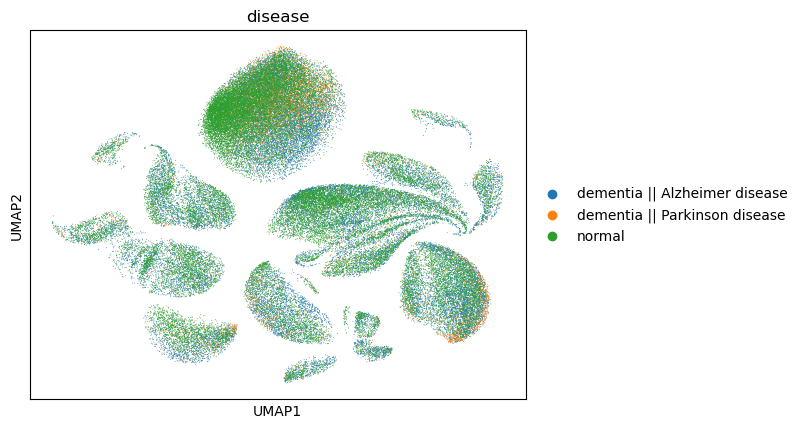

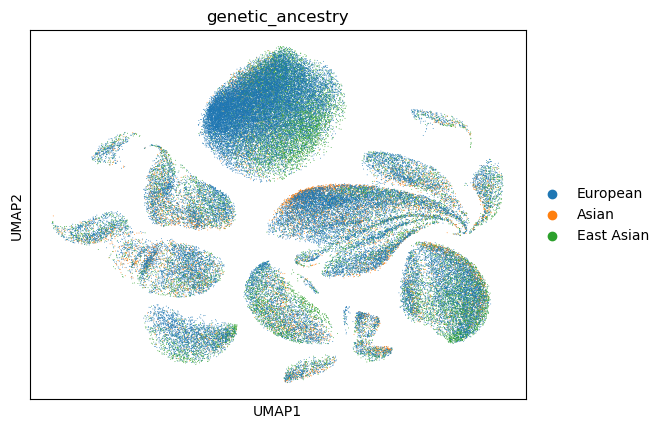

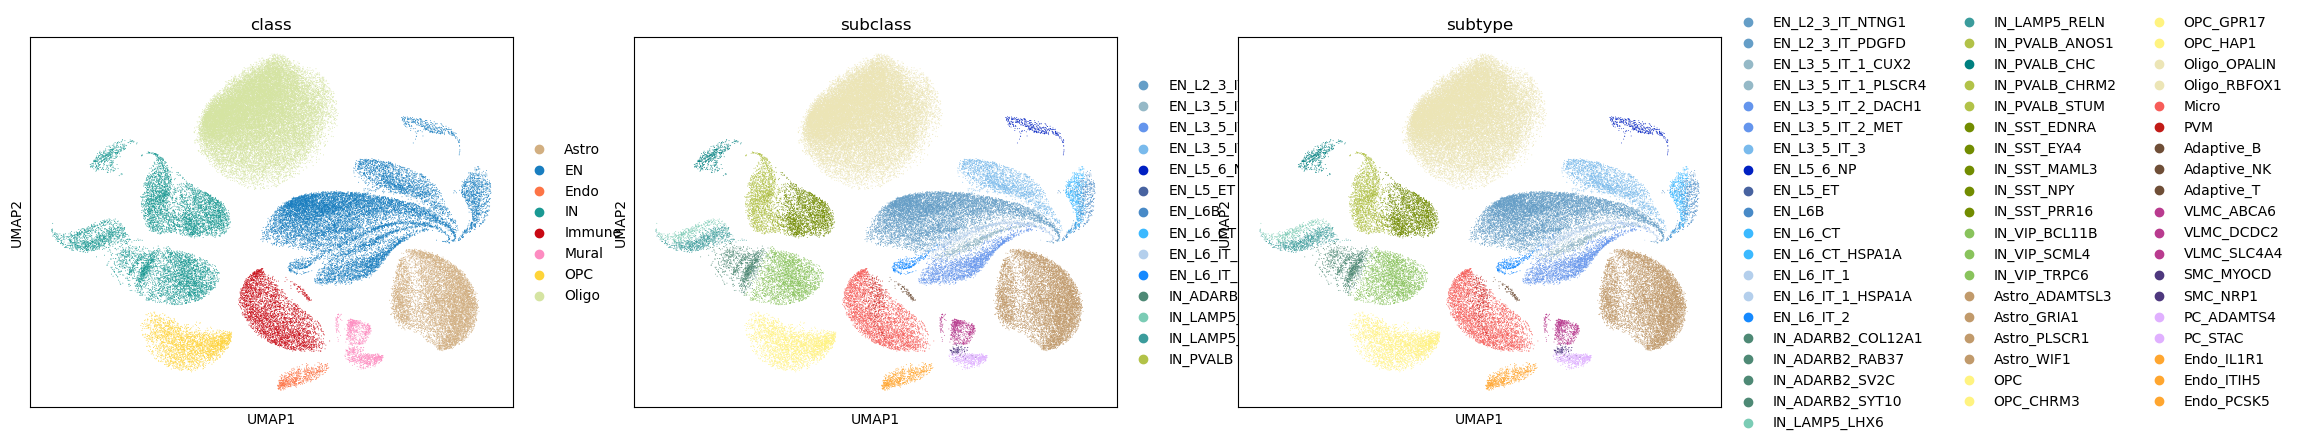

In [22]:
# sc.pl.umap(adata, color = 'cell_type')
sc.pl.umap(adata, color = 'disease')
sc.pl.umap(adata, color = 'genetic_ancestry')

# sc.pl.umap(adata, color = 'AD_status')
# sc.pl.umap(adata, color = 'sex')
# sc.pl.umap(adata, color = 'subclass')
# sc.pl.umap(adata, color = ['cell_type', 'subclass'])
sc.pl.umap(adata, color = ['class', 'subclass', 'subtype'])

In [23]:
del adata.obsm["X_umap"]

### *adata.uns*
Other information:

In [24]:
print("adata.uns.keys :", adata.uns.keys())

adata.uns.keys : dict_keys(['batch_condition', 'citation', 'class_colors', 'genome', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'subclass_colors', 'subtype_colors', 'title', 'uid', 'disease_colors', 'genetic_ancestry_colors'])


# **RNAseq pipeline**

## 1. Quality Check

### a - Visualization of QC metrics

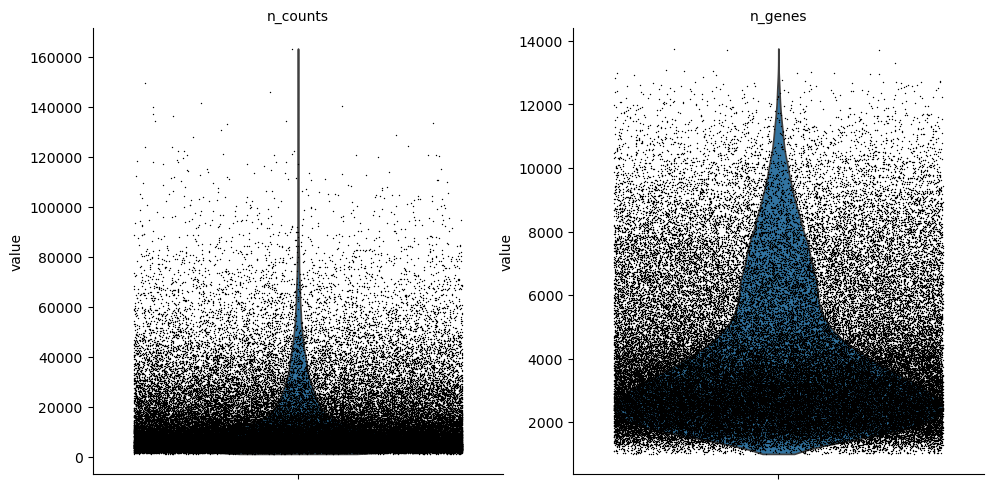

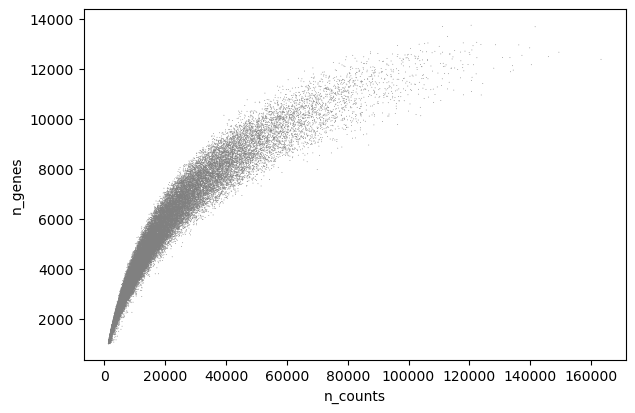

In [25]:
# Calculation of QC metrics and addition to adata.obs
sc.pp.calculate_qc_metrics(adata, inplace = True)

# Visualization of QC metrics before filtering
sc.pl.violin(
    adata, 
    ['n_counts', 'n_genes'], # Violin plot of number of genes and counts per cell
    jitter = 0.4,
    multi_panel = True
)

sc.pl.scatter(adata, x = 'n_counts', y = 'n_genes') # Scatter plot of number of genes vs. number of counts

### b - Filtering out low quality cells

In [3]:
# Application of filters
adata = adata[adata.obs['n_genes'] < 12000, :] # cutoff chosen: 12 000 genes

adata = adata[adata.obs['n_counts'] < 80000, :] # cutoff chosen: 80 000 counts

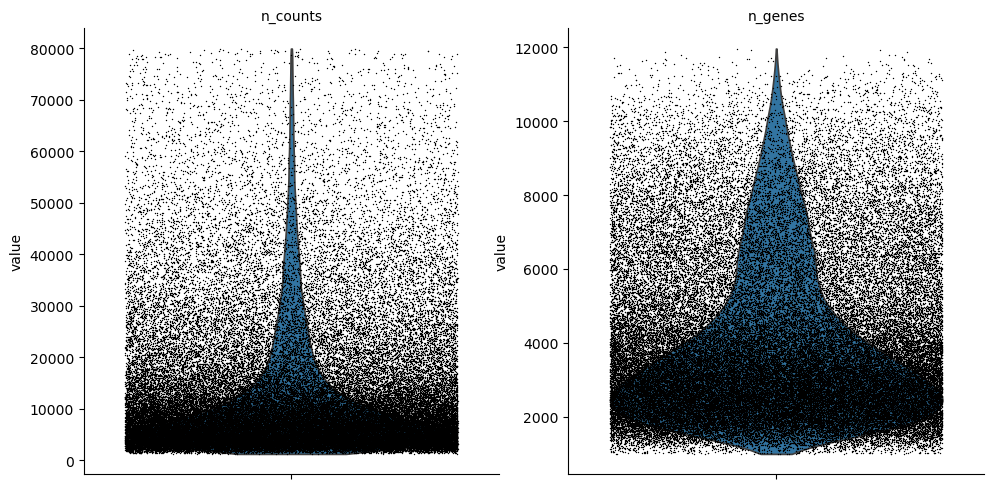

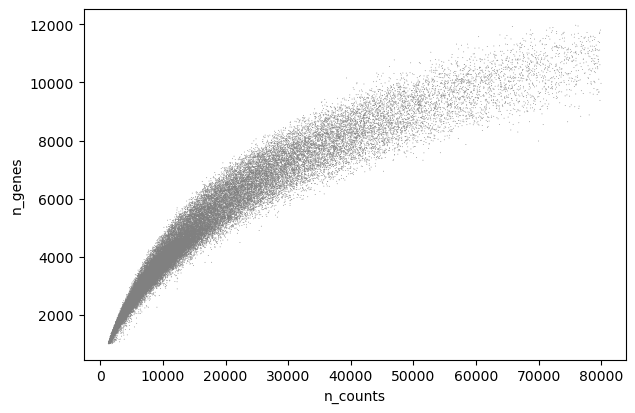

In [27]:
# Visualization of QC metrics after filtering
sc.pl.violin(
    adata, 
    ['n_counts', 'n_genes'], # Violin plot of number of genes and counts per cell
    jitter = 0.4,
    multi_panel = True
)

sc.pl.scatter(adata, x = 'n_counts', y = 'n_genes') # Scatter plot of number of genes vs. number of counts

### c - Filtering out mitochondrial genes

In [28]:
# Counting the number of mitochondrial genes
adata.var["mt"] = adata.var['gene_name'].str.startswith("MT-")

# Calculating QC metrics including the percentage of mitochondrial genes and adding them to adata.obs
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars = ["mt"],
    inplace = True,
    log1p = True
)

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/4025084783.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var['gene_name'].str.startswith("MT-")


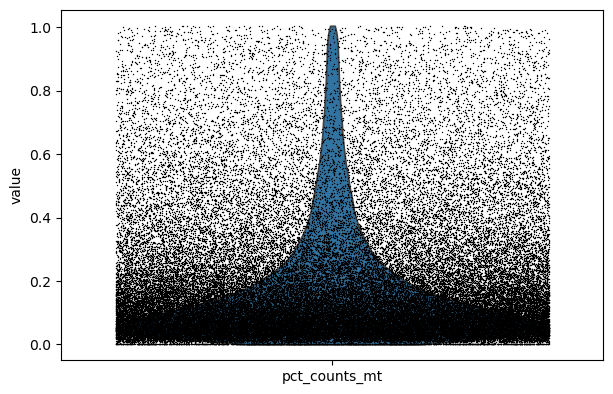

In [29]:
# Visualization of the percentage of mitochondrial genes
sc.pl.violin(
    adata,
    keys = 'pct_counts_mt',
    jitter = 0.4,
    rotation=  0,   
    stripplot = True,
    show = True
)

Here, we note that there were no cells with more than 10% mitochondrial gene expression in the dataset even before we applied our own filter. This means that the dataset did not contain such cells, either because of the nature of the data or because the dataset was already treated and filtered.

### d - Excluding ribosomal and hemoglobin genes
We elected to keep ribosomal genes, which make up 1.5% of genes expressed, and to filter out hemoglobin genes.

In [4]:
# Ribosomal genes
adata.var["ribo"] = adata.var['gene_name'].str.startswith(("RPS", "RPL"))
print("proportion of ribo genes in all expressed genes : ", adata.var["ribo"].sum()/len(adata.var)*100)

# Hemoglobin genes
adata.var["hb"] = adata.var['gene_name'].str.contains("^HB[^(P)]")
print("Number of hemo genes before deletion : ", adata.var["hb"].sum())

# Confirming that hb genes were properly removed
genes_to_keep = ~adata.var["hb"]
adata = adata[:, genes_to_keep].copy()
print("Number of hemo genes after deletion: ", adata.var["hb"].sum())

C:\Users\yarad\AppData\Local\Temp\ipykernel_22908\3658450869.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["ribo"] = adata.var['gene_name'].str.startswith(("RPS", "RPL"))


proportion of ribo genes in all expressed genes :  1.5127574906367043
Number of hemo genes before deletion :  9
Number of hemo genes after deletion:  0


### e - IMPORTANT : Apply the filtering on adata_raw

In [31]:
adata_raw = adata_raw[adata.obs_names, adata.var_names].copy() 

## 2. Normalization

The dataset contains raw counts.

In [32]:
# We can see that this is a sparse matrix, without normalized values
adata.X[:5, :10].toarray()

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 3., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 5., 0., 0., 0., 1., 1.]], dtype=float32)

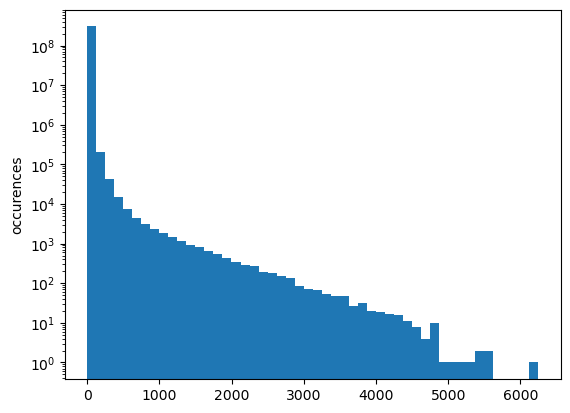

In [33]:
plt.hist(adata.X.data, bins = 50, log = True)
plt.ylabel("occurences")
plt.show()

Normalization using log1p

In [5]:
sc.pp.log1p(adata)

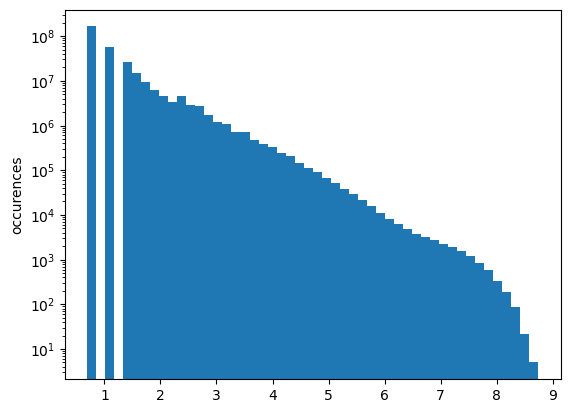

In [35]:
# Verifying that the count fwere normalized
plt.hist(adata.X.data, bins = 50, log = True)
plt.ylabel("occurences")
plt.show()

## 3. Highly Variable Genes (HVGs)

In [6]:
nHVG = 3000 # We are choosing to keep 3000 HVGs

sc.pp.highly_variable_genes(
    adata, 
    flavor = 'cell_ranger',
    n_top_genes = nHVG
)

print("We kept", nHVG, "highly variable genes out of", adata.shape[1], "genes.")

We kept 3000 highly variable genes out of 34167 genes.


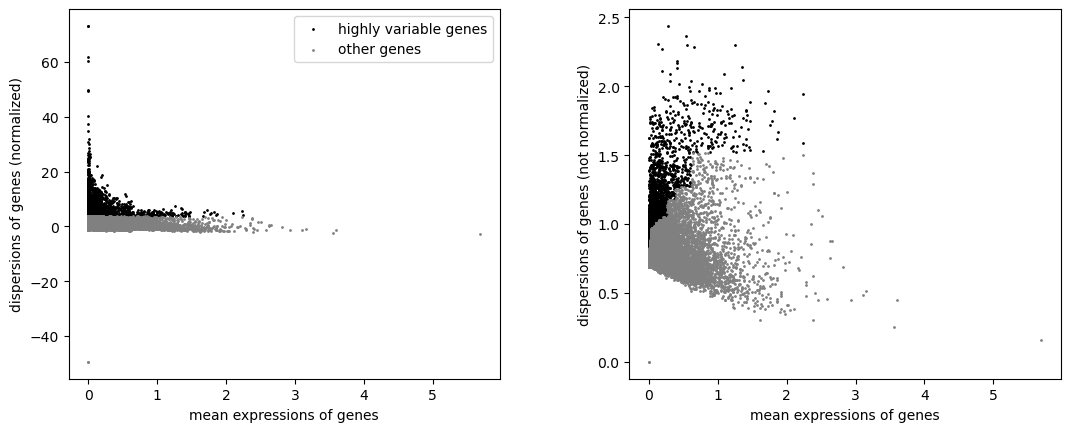

In [37]:
# Plotting the dispersion of genes in the dataset vs their mean expression
sc.pl.highly_variable_genes(adata)

In [38]:
# Verifying the number of HVGs selected
adata.var['highly_variable'].value_counts()

highly_variable
False    31167
True      3000
Name: count, dtype: int64

We now create an AnnData object with the HVGs only that will be used for downstream analyses.

In [7]:
adata_hvg = adata[:, adata.var['highly_variable']].copy()

## 4. Scaling & PCA

In [8]:
# Scaling is necessary for the PCA.
sc.pp.scale(adata_hvg, max_value = 10)

c:\Users\yarad\AppData\Local\spyder-6\envs\spyder-runtime\Lib\functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [9]:
# PCA
sc.tl.pca(adata_hvg)

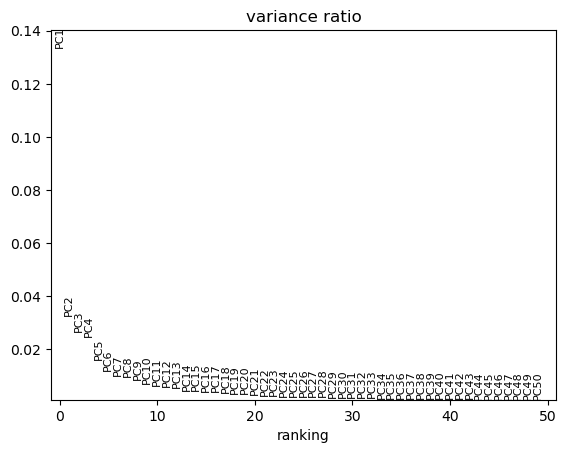

In [ ]:
# Visualizing how much variance is represented by each PC
sc.pl.pca_variance_ratio(adata_hvg, n_pcs = 50)

In [ ]:
# How much variance is conserved by 30 PCs?
var_30 = adata_hvg.uns["pca"]["variance_ratio"][:30].sum()
print(f"Variance explained by top 30 PCs: {var_30:.4f} ({var_30*100:.2f}%)")


Variance explained by top 30 PCs: 0.3442 (34.42%)


In [ ]:
# How much variance is conserved by 30 PCs?
var_50 = adata_hvg.uns["pca"]["variance_ratio"][:50].sum()
print(f"Variance explained by top 50 PCs: {var_50:.4f} ({var_50*100:.2f}%)")


Variance explained by top 50 PCs: 0.3685 (36.85%)


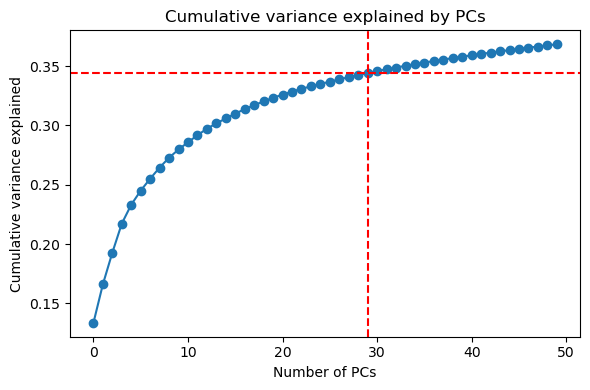

In [10]:
# Plotting cumulative variance conserved by PCs
vr = adata_hvg.uns["pca"]["variance_ratio"]
cumvr = np.cumsum(vr)

plt.figure(figsize = (6,4))
plt.plot(cumvr, marker = "o")

plt.axvline(29, color = "red", ls = "--")   # PC30 index = 29
plt.axhline(cumvr[29], color = "red", ls = "--")
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative variance explained")
plt.title("Cumulative variance explained by PCs")

plt.tight_layout()
plt.show()

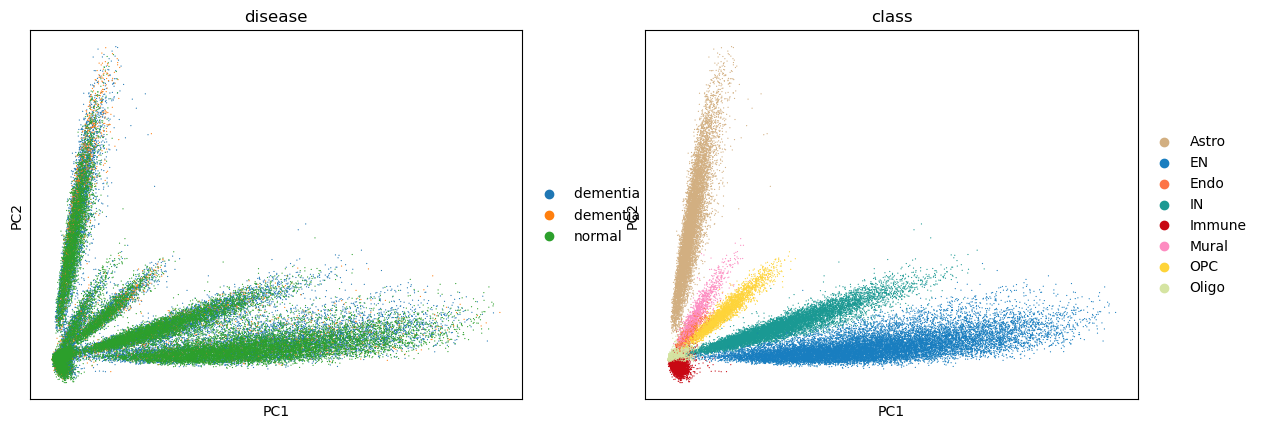

In [43]:
sc.pl.pca(adata_hvg,
    color = ["disease", "class"],
    ncols = 3,
    size = 3)

In [14]:
import gseapy
help(gseapy)

Help on package gseapy:

NAME
    gseapy

PACKAGE CONTENTS
    __main__
    algorithm
    base
    biomart
    enrichr
    gse
    gsea
    gsva
    msigdb
    parser
    plot
    scipalette
    ssgsea
    stats
    utils

CLASSES
    builtins.object
        gseapy.biomart.Biomart
        gseapy.enrichr.Enrichr
        gseapy.msigdb.Msigdb
    gseapy.base.GSEAbase(builtins.object)
        gseapy.gsea.GSEA
        gseapy.gsea.Prerank
        gseapy.gsea.Replot
        gseapy.gsva.GSVA
        gseapy.ssgsea.SingleSampleGSEA

    class Biomart(builtins.object)
     |  Biomart(host: str = 'www.ensembl.org', verbose: bool = False)
     |
     |  query from BioMart
     |
     |  Methods defined here:
     |
     |  __del__(self)
     |
     |  __init__(self, host: str = 'www.ensembl.org', verbose: bool = False)
     |      simple API to BioMart services.
     |
     |      How to query validated dataset, attributes, filters.
     |      Example::
     |      >>> from gseapy import Biomart
 

## 5. Batch effect correction

In [44]:
bbknn.bbknn(adata_hvg, batch_key = 'donor_id')
sc.external.pp.bbknn(adata_hvg, batch_key = "donor_id")

## 6. Clustering

In [45]:
adata_hvg.obs["class"].value_counts()

class
Oligo     29919
EN        17717
IN        10258
Astro      9235
Immune     4270
OPC        3085
Mural      1348
Endo        740
Name: count, dtype: int64

In [46]:
donors_by_class_and_subclass = (adata_hvg.obs.groupby(["class", "subclass"], observed=True)["donor_id"].nunique())

donors_by_class_and_subclass

class   subclass     
Astro   Astro            17
EN      EN_L2_3_IT       17
        EN_L3_5_IT_1     17
        EN_L3_5_IT_2     17
        EN_L3_5_IT_3     17
        EN_L5_6_NP       16
        EN_L5_ET          5
        EN_L6B           16
        EN_L6_CT         16
        EN_L6_IT_1       16
        EN_L6_IT_2       15
Endo    Endo             17
IN      IN_ADARB2        17
        IN_LAMP5_LHX6    17
        IN_LAMP5_RELN    17
        IN_PVALB         17
        IN_PVALB_CHC     17
        IN_SST           17
        IN_VIP           17
Immune  Micro            17
        PVM              16
        Adaptive         12
Mural   VLMC             16
        SMC              13
        PC               17
OPC     OPC              17
Oligo   Oligo            17
Name: donor_id, dtype: int64

### Neighbors

In [47]:
# Number of neighbors
# We chose 30 PCs because after that the variance ratio doesn't decrease that much
nPC = 30

sc.pp.neighbors(
    adata_hvg,
    n_neighbors = 30,
    n_pcs = nPC,
    metric = "euclidean",
    random_state = 42,
)

### Clustering

In [48]:
sc.tl.leiden(adata_hvg, resolution = 0.02)

print("Number of clusters :", len(adata_hvg.obs['leiden'].cat.categories))

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/1696101154.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_hvg, resolution = 0.02)


Number of clusters : 10


### UMAP

In [83]:
sc.tl.umap(
    adata_hvg,
    min_dist = 0.8,        
    random_state = 40,
)

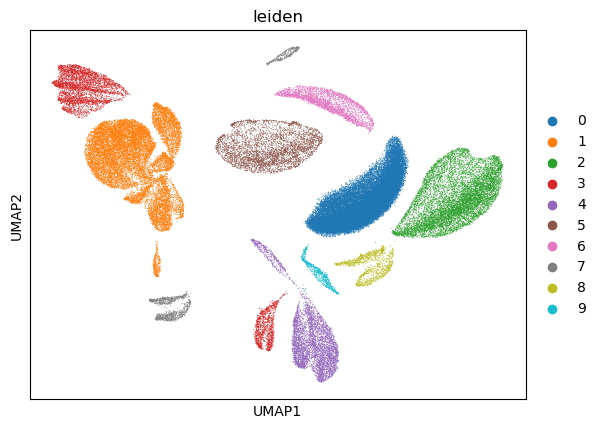

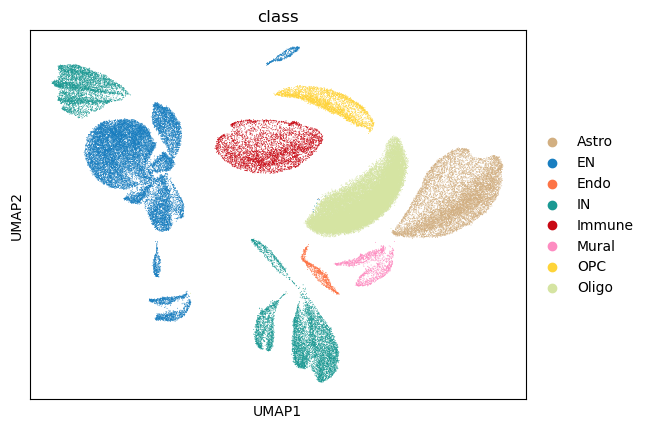

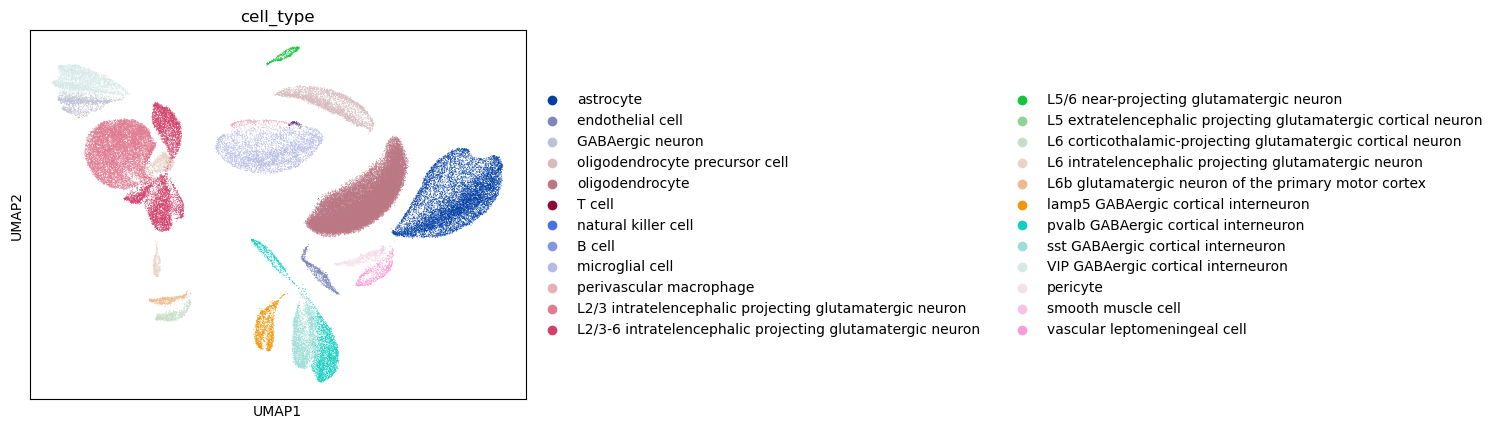

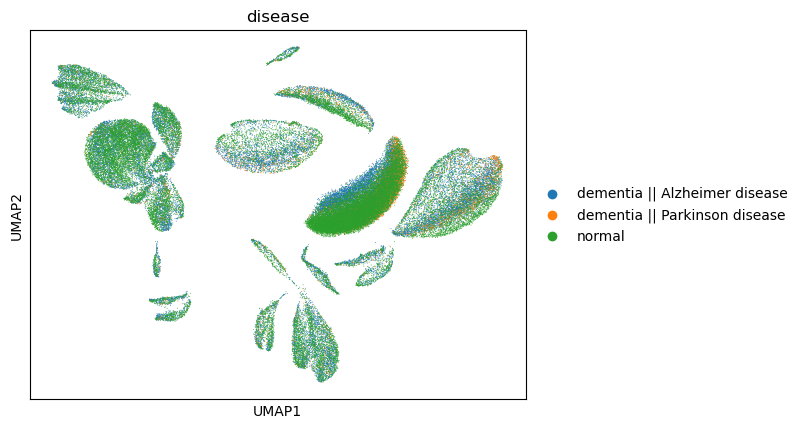

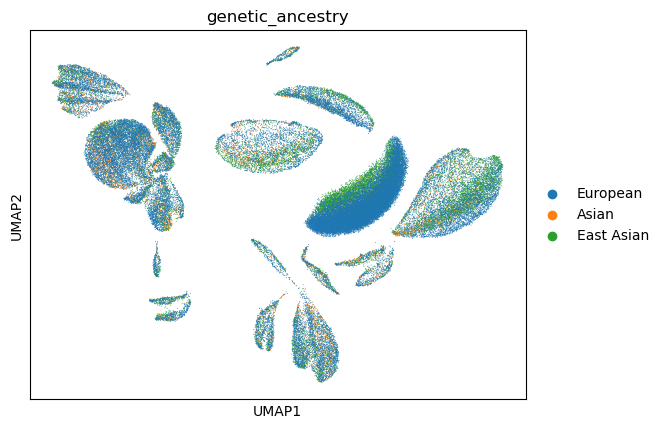

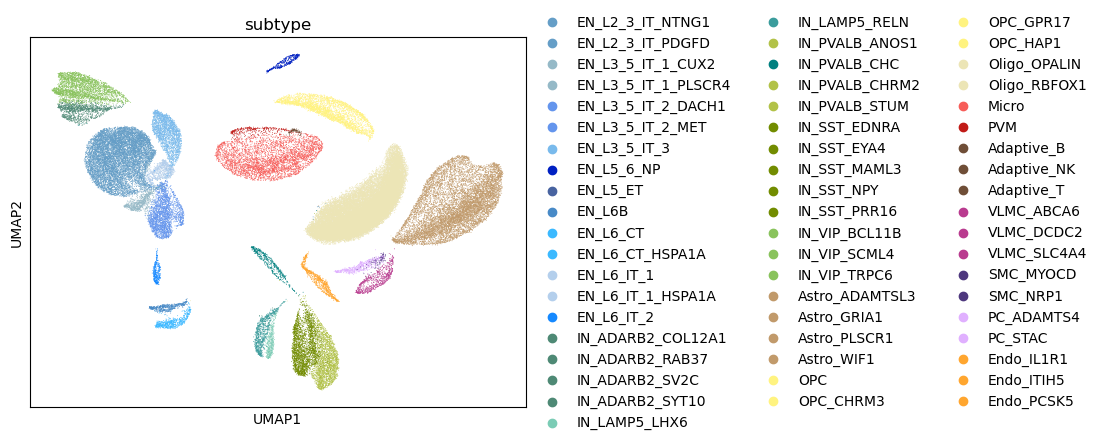

In [84]:

sc.pl.umap(adata_hvg, color = "leiden")

sc.pl.umap(adata_hvg, color = "class")

sc.pl.umap(adata_hvg, color = 'cell_type')

sc.pl.umap(adata_hvg, color = "disease")

sc.pl.umap(adata_hvg, color = "genetic_ancestry")

sc.pl.umap(adata_hvg, color = 'subtype')

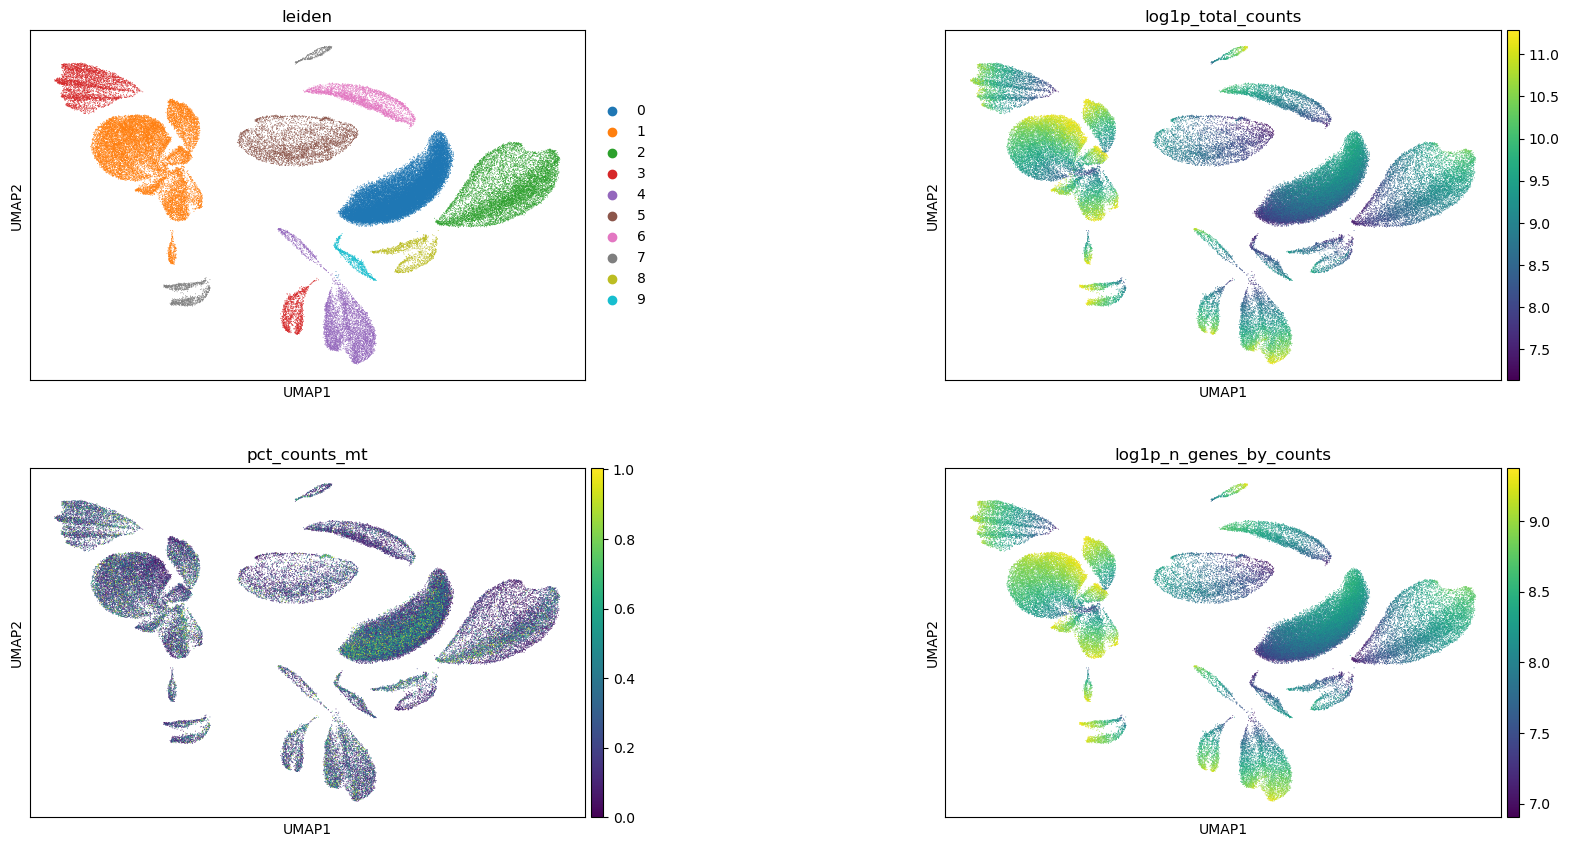

In [51]:
sc.pl.umap(
    adata_hvg,
    color = ["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace = 0.5,
    ncols = 2,
)

## 7. Manual Annotation

#### Marker gene set
We first define known marker genes of the cell types that we think are represented by the clusters. We only keep the genes in that list that are found in our data.

In [52]:
# Define marker genes for each cell type (sources referenced in the report)
marker_genes = {
    "Astrocytes" : ["ENSG00000135821", "ENSG00000125398", "ENSG00000171885", "ENSG00000152661", "ENSG00000165795", "ENSG00000131095", "ENSG00000144908"],
    "Endothelial cells" : ["ENSG00000184113", "ENSG00000229515"],
    "Immune cells" : ["ENSG00000125730", "ENSG00000019582" ,"ENSG00000168329","ENSG00000182578", "ENSG00000173372"],
    "Oligodendrocytes" : ["ENSG00000197971", "ENSG00000204655", "ENSG00000123560", "ENSG00000168314", "ENSG00000105695", "ENSG00000172270","ENSG00000204351", "ENSG00000087086",  "ENSG00000115310",  "ENSG00000140076",  "ENSG00000205927", "ENSG00000100146"],
    "OPC" : ["ENSG00000184221", "ENSG00000205927", "ENSG00000150275", "ENSG00000134853"],
    "Excitatory Neurons" : ["ENSG00000070808", "ENSG00000154146", "ENSG00000119042", "ENSG00000104888"],
    "Inhibitory Neurons" : ["ENSG00000128683", "ENSG00000136750"],
    "Mural" : ["ENSG00000113721", "ENSG00000175084", "ENSG00000173546", 'ENSG00000168826', "ENSG00000074181" ]
    }

marker_genes
 

{'Astrocytes': ['ENSG00000135821',
  'ENSG00000125398',
  'ENSG00000171885',
  'ENSG00000152661',
  'ENSG00000165795',
  'ENSG00000131095',
  'ENSG00000144908'],
 'Endothelial cells': ['ENSG00000184113', 'ENSG00000229515'],
 'Immune cells': ['ENSG00000125730',
  'ENSG00000019582',
  'ENSG00000168329',
  'ENSG00000182578',
  'ENSG00000173372'],
 'Oligodendrocytes': ['ENSG00000197971',
  'ENSG00000204655',
  'ENSG00000123560',
  'ENSG00000168314',
  'ENSG00000105695',
  'ENSG00000172270',
  'ENSG00000204351',
  'ENSG00000087086',
  'ENSG00000115310',
  'ENSG00000140076',
  'ENSG00000205927',
  'ENSG00000100146'],
 'OPC': ['ENSG00000184221',
  'ENSG00000205927',
  'ENSG00000150275',
  'ENSG00000134853'],
 'Excitatory Neurons': ['ENSG00000070808',
  'ENSG00000154146',
  'ENSG00000119042',
  'ENSG00000104888'],
 'Inhibitory Neurons': ['ENSG00000128683', 'ENSG00000136750'],
 'Mural': ['ENSG00000113721',
  'ENSG00000175084',
  'ENSG00000173546',
  'ENSG00000168826',
  'ENSG00000074181']}

In [53]:
# Only keep the marker genes find in our data

marker_genes_in_data = {}
for ct, markers in marker_genes.items():
    markers_found = []
    for marker in markers:
        if marker in adata_hvg.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

marker_genes_in_data

{'Astrocytes': ['ENSG00000171885',
  'ENSG00000152661',
  'ENSG00000131095',
  'ENSG00000144908'],
 'Endothelial cells': ['ENSG00000184113'],
 'Immune cells': ['ENSG00000125730',
  'ENSG00000019582',
  'ENSG00000168329',
  'ENSG00000182578'],
 'Oligodendrocytes': [],
 'OPC': ['ENSG00000150275', 'ENSG00000134853'],
 'Excitatory Neurons': ['ENSG00000119042'],
 'Inhibitory Neurons': ['ENSG00000128683', 'ENSG00000136750'],
 'Mural': ['ENSG00000074181']}

Listing the cell types that we want to show the markers for:

In [54]:
cell_types = ["Astrocytes", "Endothelial cells", "Immune cells", "Oligodendrocytes", "OPC", "Excitatory Neurons", "Inhibitory Neurons", "Mural"]

cell_types

['Astrocytes',
 'Endothelial cells',
 'Immune cells',
 'Oligodendrocytes',
 'OPC',
 'Excitatory Neurons',
 'Inhibitory Neurons',
 'Mural']

Plotting one UMAP per marker for each cell type:

ASTROCYTES:


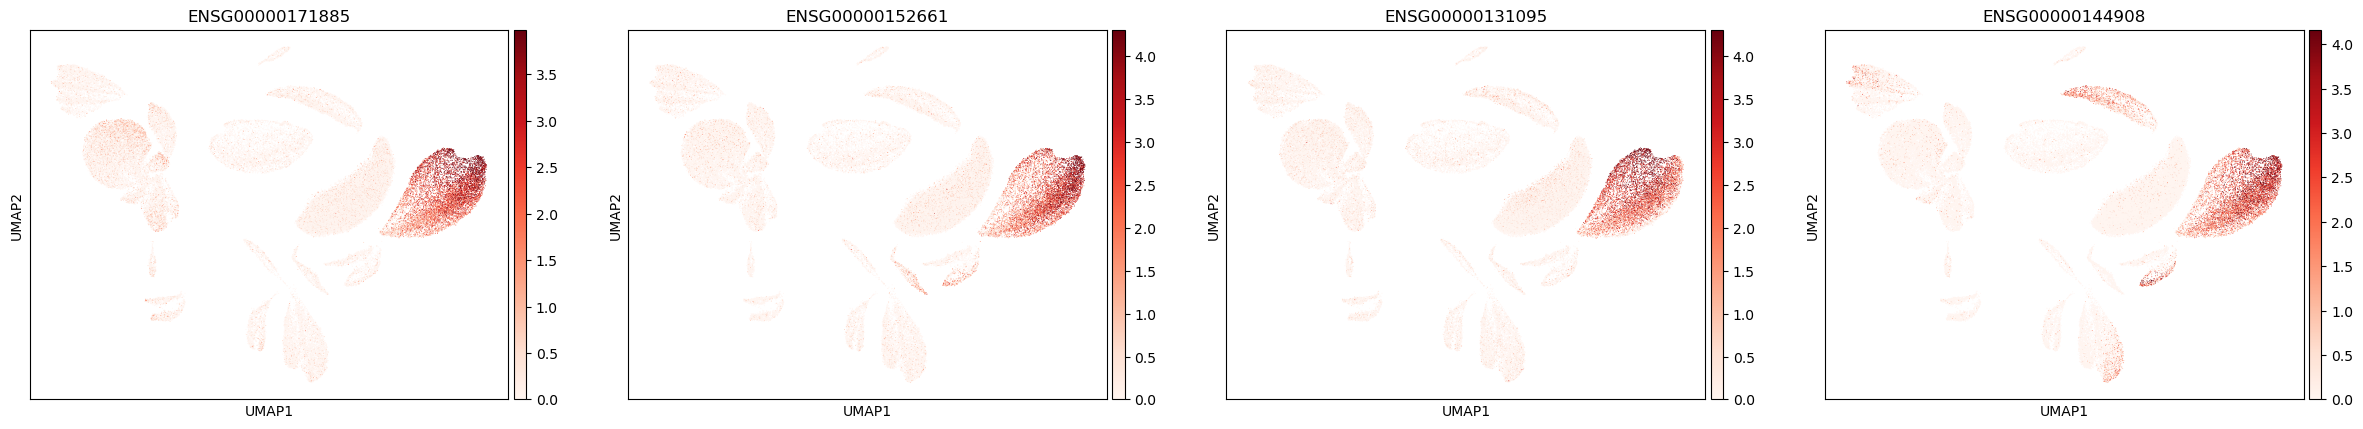





ENDOTHELIAL CELLS:


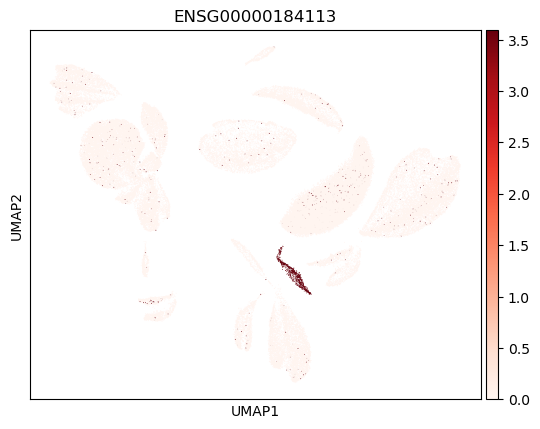





IMMUNE CELLS:


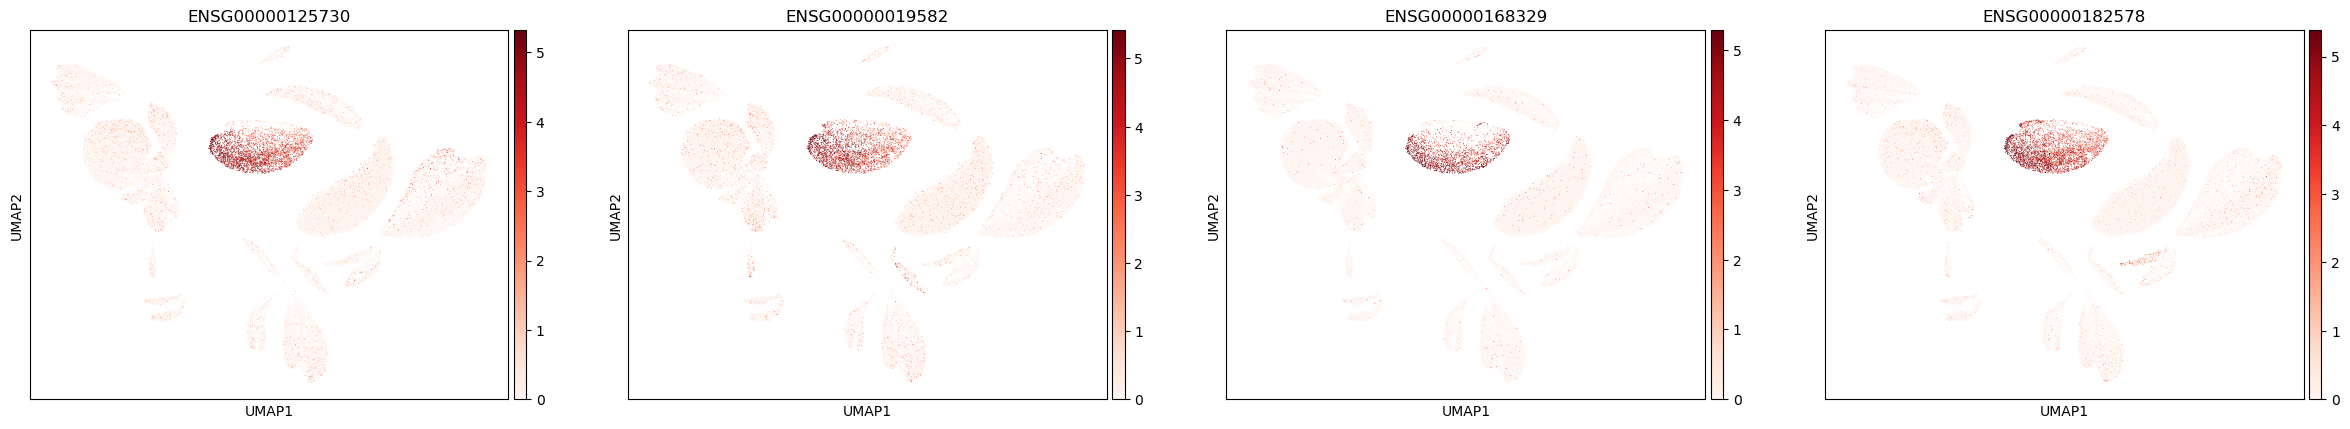





OLIGODENDROCYTES: No marker genes found in data.

OPC:


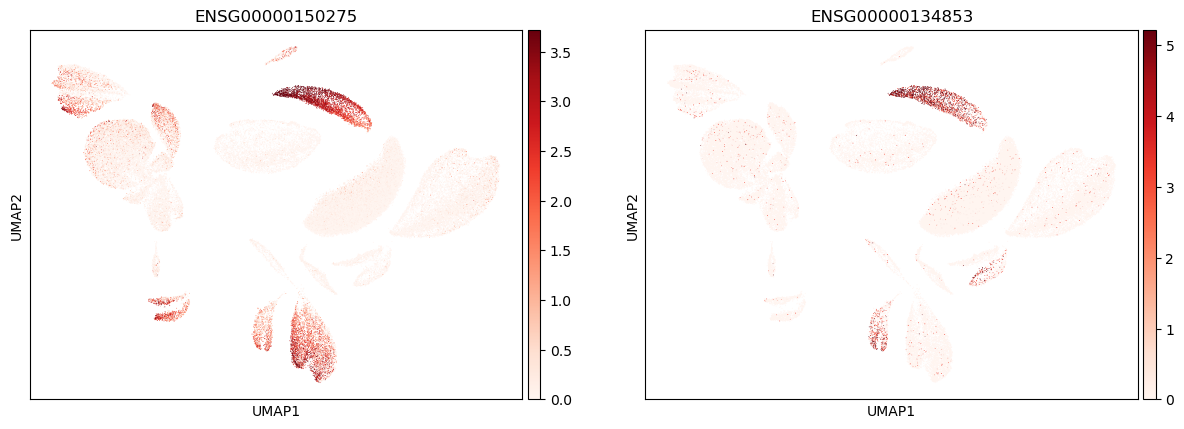





EXCITATORY NEURONS:


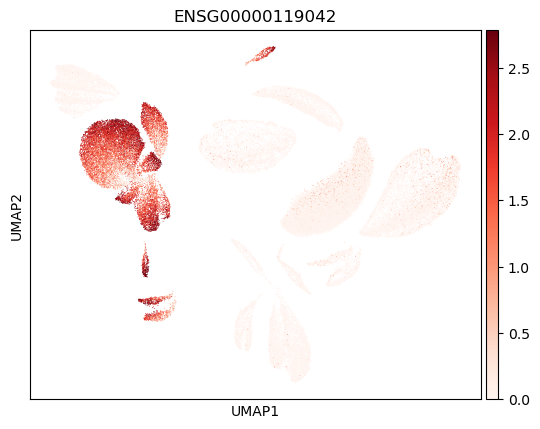





INHIBITORY NEURONS:


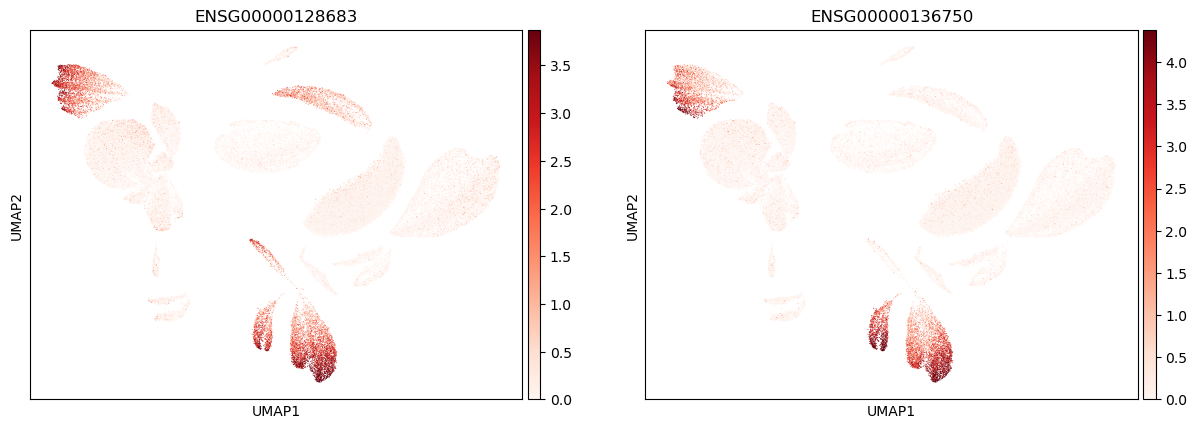





MURAL:


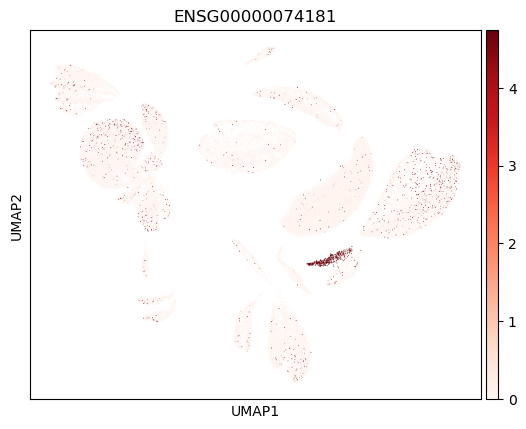

In [55]:
for ct in cell_types:
    markers = marker_genes_in_data[ct]
    if not markers:  # Skip if the list is empty
        print(f"{ct.upper()}: No marker genes found in data.\n")
        continue
    
    print(f"{ct.upper()}:")  
    sc.pl.umap(
        adata_hvg,
        color = markers,
        vmin = 0,
        vmax = "p99",
        sort_order = False,
        cmap = "Reds",
    )
    
    print("\n\n\n") 

Dotplot visualization of marker gene expression per cluster:

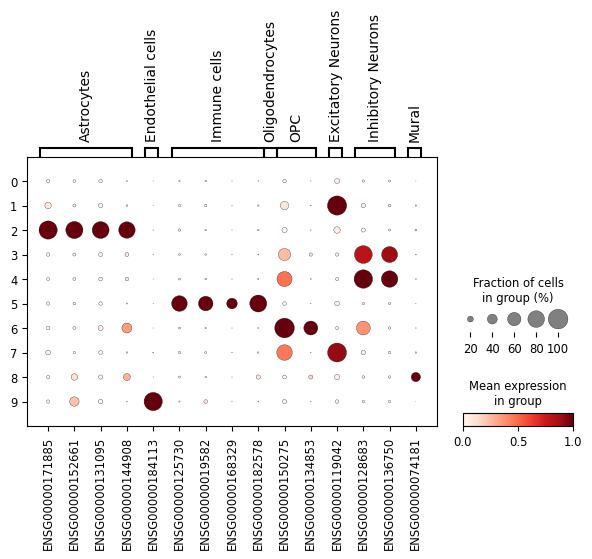

In [56]:
sc.pl.dotplot(
    adata_hvg,
    groupby = "leiden",
    var_names = marker_genes_in_data,
    standard_scale = "var",  # normalize each gene to range from 0 to 1
)

Referring to both representations, we can manually annotate the clusters:

In [57]:
cl_annotation = {
    "0": "Oligodendrocytes",
    "1": "Excitatory Neurons",
    "2": "Astrocytes", 
    "3": "Inhibitory Neurons",
    "4": "Inhibitory Neurons", 
    "5" : "Immune cells", 
    "6" : "OPC",
    "7" : "Excitatory Neurons",
    "8" : "Mural",
    "9" : "Endothelial cells"
}

To visualize the annotations:

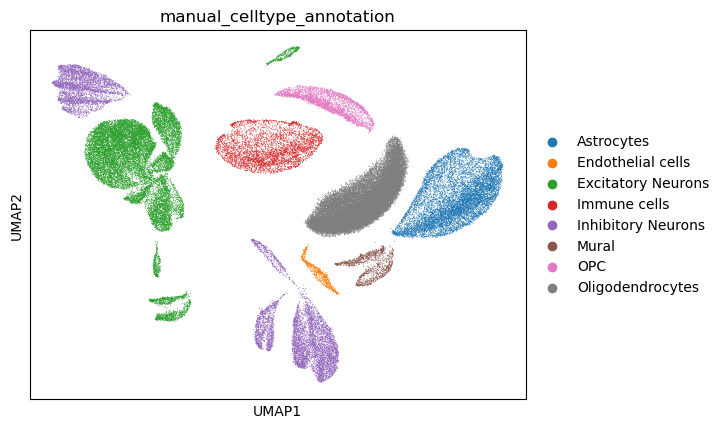

In [58]:
adata_hvg.obs["manual_celltype_annotation"] = adata_hvg.obs.leiden.map(cl_annotation)

sc.pl.umap(adata_hvg, color = ["manual_celltype_annotation"])

To confirm our annotations, we can find the differentially expressed genes for each cluster as compared to the others.

/opt/anaconda3/envs/scanpy310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/scanpy310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/scanpy310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/scanpy310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/envs/scanpy310/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchange

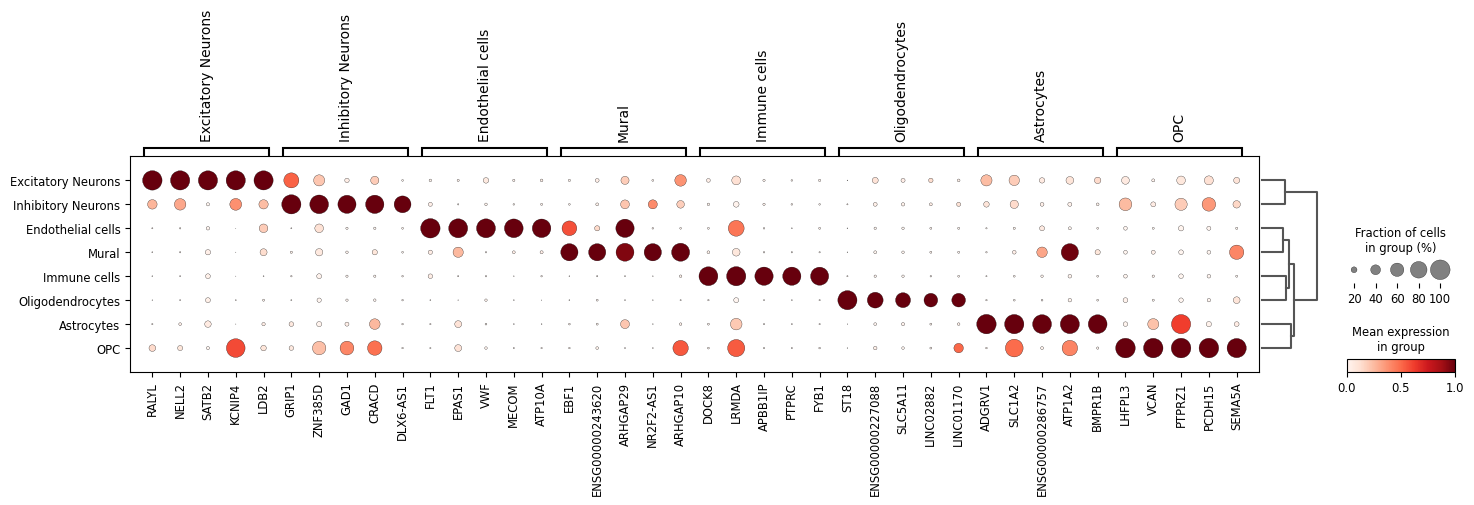

In [59]:
# Calculating differentially expressed genes for each cluster 
    ## We are using the rank_genes_groups function from scanpy for annotations, but for downstream analyses, we will do pseudo-bulk differential expression to avoid pseudoreplication issues.

sc.tl.rank_genes_groups(
    adata_hvg, groupby = "manual_celltype_annotation", method = "wilcoxon", key_added = "dea_leiden", var_names="gene_name"
)

# Visualizing the expression of the 5 top DE genes per cluster (dotplot representation)
sc.pl.rank_genes_groups_dotplot(
    adata_hvg, groupby = "manual_celltype_annotation", standard_scale = "var", n_genes = 5, key = "dea_leiden" , gene_symbols="gene_name"
)

## 8. Differential Gene Expression

### *Pseudobulk*

In [60]:
donors_per_disease_raw = (adata_raw.obs.groupby([ "disease"], observed = True)["donor_id"].nunique())
print("The number of donor per disease type :\n", donors_per_disease_raw)

The number of donor per disease type :
 disease
dementia || Alzheimer disease    8
dementia || Parkinson disease    3
normal                           6
Name: donor_id, dtype: int64


In [61]:
print("\nThe number of cells per disease type ;")
adata_raw.obs.groupby(["class", "disease"]).size().unstack(fill_value = 0)


The number of cells per disease type ;


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3371106418.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_raw.obs.groupby(["class", "disease"]).size().unstack(fill_value = 0)


disease  dementia || Alzheimer disease  dementia || Parkinson disease  normal
class                                                                        
Astro                             4620                           1128    3487
EN                                7602                            804    9311
Endo                               417                             39     284
IN                                4695                            539    5024
Immune                            2188                            383    1699
Mural                              684                             69     595
OPC                               1256                            323    1506
Oligo                            10242                           4461   15216

Pseudo-bulk matrix (= pb) : 

- lines : cell type per donor 
- columns : mean expression levels

Each donor is considered an indepedant observation. We cannot compare each cell one by one because it's statistically false. Therefore, we do a pseudo-bulk donor x cell type.

Each value corresponds to the mean log-normalized counts for 1 cell type for 1 donor.

In [62]:
adata_raw.obs.keys()

Index(['Source', 'n_genes', 'n_counts', 'class', 'subclass', 'subtype',
       'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'suspension_type', 'is_primary_data', 'AD_status',
       'DLBD_status', 'FTD_status', 'Tauopathy_status', 'Vascular_status',
       'ASCVD_status', 'Schizophrenia', 'Bipolar_Disorder',
       'Parkinson_disease', 'Tardive_dyskinesia', 'genetic_ancestry',
       'disease_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid'],
      dtype='object')

In [63]:
# Creation of dataframe for pseudobulk
df = adata_raw.to_df()  
meta = adata_raw.obs[["donor_id", "class", "disease", "sex"]]

df["donor_id"] = meta["donor_id"].values
df["class"] = meta["class"].values
df["disease"] = meta["disease"].values
meta["sex"] = meta["sex"].astype("category")


pb = (df.groupby(["class", "donor_id", "disease"]).sum()) # sum of n_counts per class, donor, and disease
pb = pb[pb.sum(axis = 1) != 0] # deleting empty lines
pb = pb.reset_index()

# Check if the dataframe is of correct shape
if pb.shape[0] == len((adata.obs["donor_id"].cat.categories))* len((adata.obs["class"].cat.categories)) and pb.shape[1] == len(adata_raw.var)+3 :
    print("Dataframe IS OK : no donor or gene were deleted")
else : 
    print("WARNING : wrong number of donors")
    
meta_donor = meta[["donor_id", "sex"]].drop_duplicates()

# Merge donor metadata onto pseudobulk
pb = pb.merge(meta_donor, on = "donor_id", how = "left")

pb

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/817355817.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta["sex"] = meta["sex"].astype("category")
/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/817355817.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pb = (df.groupby(["class", "donor_id", "disease"]).sum()) # sum of n_counts per class, donor, and disease


Dataframe IS OK : no donor or gene were deleted


class    donor_id                        disease  ENSG00000000003  \
0    Astro    Donor_31  dementia || Alzheimer disease             71.0   
1    Astro   Donor_228  dementia || Alzheimer disease             63.0   
2    Astro   Donor_333  dementia || Alzheimer disease            110.0   
3    Astro   Donor_545  dementia || Parkinson disease             19.0   
4    Astro   Donor_609                         normal             60.0   
..     ...         ...                            ...              ...   
131  Oligo  Donor_1001  dementia || Alzheimer disease              5.0   
132  Oligo  Donor_1007  dementia || Alzheimer disease              0.0   
133  Oligo  Donor_1146                         normal             10.0   
134  Oligo  Donor_1278                         normal              8.0   
135  Oligo  Donor_1467  dementia || Parkinson disease              1.0   

     ENSG00000000005  ENSG00000000419  ENSG00000000457  ENSG00000000460  \
0                7.0            242.0            173.0            139.0   
1                1.0            258.0            197.0            123.0   
2               12.0            140.0            102.0            101.0   
3                3.0            154.0            112.0             69.0   
4                6.0            245.0            156.0            106.0   
..               ...              ...              ...              ...   
131              0.0            293.0            204.0            266.0   
132              0.0             15.0             11.0             15.0   
133              0.0            319.0            213.0            165.0   
134              1.0            808.0            516.0            642.0   
135              0.0             55.0             38.0             35.0   

     ENSG00000000938  ENSG00000000971  ...  ENSG00000288602  ENSG00000288605  \
0                1.0              4.0  ...             98.0             37.0   
1                2.0              1.0  ...            119.0             25.0   
2                1.0              5.0  ...             69.0             13.0   
3                1.0              1.0  ...             91.0             21.0   
4                2.0              8.0  ...            121.0             13.0   
..               ...              ...  ...              ...              ...   
131              6.0             18.0  ...            164.0              3.0   
132              0.0              1.0  ...              4.0              0.0   
133              4.0              7.0  ...             85.0              3.0   
134              5.0             30.0  ...            270.0              0.0   
135              0.0              1.0  ...             25.0              1.0   

     ENSG00000288606  ENSG00000288611  ENSG00000288612  ENSG00000288622  \
0                6.0              0.0             21.0              4.0   
1               10.0              1.0             30.0              3.0   
2                7.0              1.0             18.0              1.0   
3                7.0              1.0             19.0              2.0   
4               12.0              1.0             27.0              0.0   
..               ...              ...              ...              ...   
131             50.0              1.0             38.0              4.0   
132              4.0              0.0              3.0              0.0   
133             31.0              0.0             29.0              3.0   
134             74.0              2.0             69.0              1.0   
135              5.0              0.0              5.0              1.0   

     ENSG00000288637  ENSG00000288642  ENSG00000288643     sex  
0                3.0             15.0             13.0  female  
1                5.0             10.0             17.0    male  
2                3.0             39.0             16.0    male  
3                6.0             13.0             18.0  female  
4                3.0        

In [64]:
adata_raw.obs.groupby("donor_id")["disease"].nunique().value_counts()

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/552771304.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_raw.obs.groupby("donor_id")["disease"].nunique().value_counts()


disease
1    17
Name: count, dtype: int64

In [65]:
meta.groupby("donor_id")["disease"].nunique().value_counts()

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/2366798195.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meta.groupby("donor_id")["disease"].nunique().value_counts()


disease
1    17
Name: count, dtype: int64

In [66]:
# Saving the pseudobulk matrix into csv
pb.to_csv("pseudobulk_matrix.csv", index = False)
meta.to_csv("meta_matrix.csv", index = False)

### *Differential analysis is done in R*
We performed a differential analysis in R with the DESeq2 and edgeR packages. The code can be found on the "transcriptomics-code" repository. It is named "pseudo_bulk_DE.ipynb". The results are saved in the repository in two folders named "DESeq2_results" and "edgeR_results", which we use for the rest of the analysis. There is no need to re-run the DE unless anything changes in the previous steps or in the parameters used.

### Results

Example of a DE result:

In [67]:
DE_result_ex = pd.read_csv("edgeR_results/edgeR_IN_AD_vs_CTRL.csv", index_col = 0)

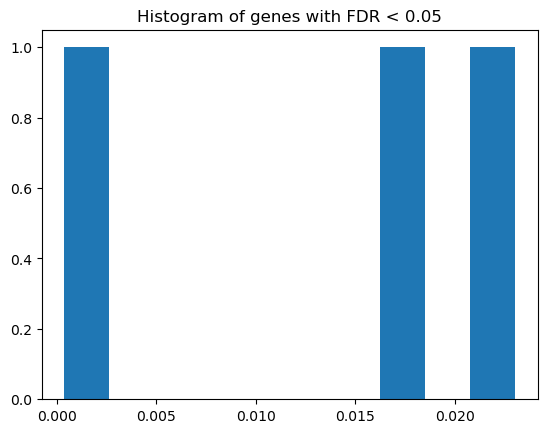

In [68]:
plt.hist(DE_result_ex[DE_result_ex["FDR"]< 0.05]["FDR"]) 
plt.title("Histogram of genes with FDR < 0.05")

plt.show()

There seems to only be 4 significant genes in this example.

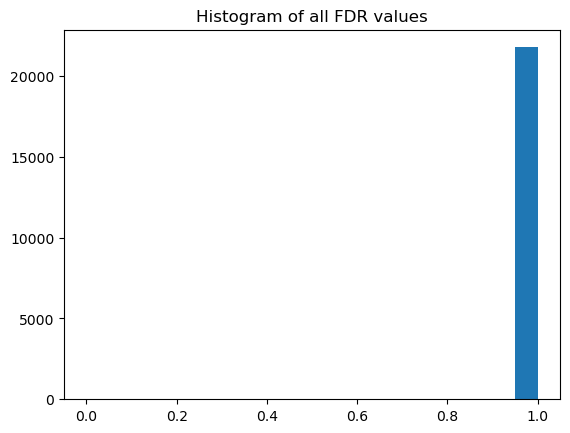

In [69]:
plt.hist(DE_result_ex["FDR"], bins = 20) 
plt.title("Histogram of all FDR values")

plt.show()

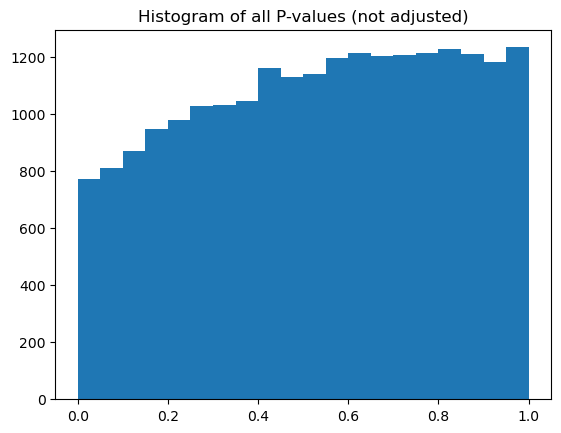

In [70]:
plt.hist(DE_result_ex["PValue"],bins = 20) 
plt.title("Histogram of all P-values (not adjusted)")

plt.show()

In [71]:
DE_result_ex[DE_result_ex["FDR"] < 0.05] # every gene where padj < 0.05

logFC    logCPM          F        PValue       FDR  \
gene_ensembl                                                             
ENSG00000026508 -2.149423  1.817574  68.787008  1.711512e-08  0.000373   
ENSG00000259520 -2.356264  2.874376  40.961758  1.688644e-06  0.018421   
ENSG00000225647  2.009270  0.180834  35.292211  3.166891e-06  0.023032   

                  gene_symbol  
gene_ensembl                   
ENSG00000026508          CD44  
ENSG00000259520   SLC28A2-AS1  
ENSG00000225647  LOC105375448

There are only 3 genes in this example with padj < 0.05.

#### **Volcano Plot Representation of Results**

In [72]:
# Loading the results:
files = glob.glob("edgeR_results/*.csv")

files

['edgeR_results/edgeR_Mural_AD_vs_PD.csv',
 'edgeR_results/edgeR_Immune_AD_vs_CTRL.csv',
 'edgeR_results/edgeR_Endo_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_EN_AD_vs_PD.csv',
 'edgeR_results/edgeR_Immune_AD_vs_PD.csv',
 'edgeR_results/edgeR_Astro_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_Oligo_AD_vs_CTRL.csv',
 'edgeR_results/edgeR_IN_AD_vs_CTRL.csv',
 'edgeR_results/edgeR_OPC_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_Mural_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_EN_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_OPC_AD_vs_PD.csv',
 'edgeR_results/edgeR_Immune_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_Astro_AD_vs_PD.csv',
 'edgeR_results/edgeR_Oligo_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_Oligo_AD_vs_PD.csv',
 'edgeR_results/edgeR_Endo_AD_vs_PD.csv',
 'edgeR_results/edgeR_IN_PD_vs_CTRL.csv',
 'edgeR_results/edgeR_Mural_AD_vs_CTRL.csv',
 'edgeR_results/edgeR_OPC_AD_vs_CTRL.csv',
 'edgeR_results/edgeR_EN_AD_vs_CTRL.csv',
 'edgeR_results/edgeR_IN_AD_vs_PD.csv',
 'edgeR_results/edgeR_Endo_AD_vs_CTRL.csv',
 'edg

In [73]:
# Defining the needed function
def volcano_plot(df, title, outfile = None, pval_col = "PValue", fc_col = "logFC", p_cut = 0.05, fc_cut = 1):
    """
    df: DataFrame containing edgeR results
    title: Title of the plot
    outfile: Where to save (PNG). If None → only show.
    pval_col: "PValue" or "FDR"
    fc_col: usually "logFC"
    p_cut: significance threshold
    fc_cut: log2 fold change threshold
    """

    # Compute −log10(p)
    df["neglog10p"] = -np.log10(df[pval_col])

    # Label significance
    df["sig"] = "Not Sig"
    df.loc[(df[pval_col] < p_cut) & (df[fc_col] > fc_cut), "sig"] = "Up"
    df.loc[(df[pval_col] < p_cut) & (df[fc_col] < -fc_cut), "sig"] = "Down"

    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data = df,
        x = fc_col, 
        y = "neglog10p",
        hue = "sig",
        palette = {"Not Sig": "grey", "Up": "red", "Down": "blue"},
        alpha = 0.7,
        s = 12
    )

    # Threshold lines
    plt.axhline(-np.log10(p_cut), color = "black", linestyle = "--", linewidth = 1)
    plt.axvline(fc_cut, color = "black", linestyle = "--", linewidth = 1)
    plt.axvline(-fc_cut, color = "black", linestyle = "--", linewidth = 1)

    plt.title(title, fontsize = 16)
    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10(p-value)")
    plt.legend(title = "Significance")
    plt.tight_layout()

    # Save the graphs
    plt.savefig(outfile, dpi = 300, bbox_inches = "tight")
    print(f"Saved volcano → {outfile}")
    plt.close()



In [74]:
# Running the function for each DEG result file - pvalue
outdir = "DGE_volcano_plots_pval"
os.makedirs(outdir, exist_ok = True)

for file in files:
    df = pd.read_csv(file)
    name = os.path.splitext(os.path.basename(file))[0]

    volcano_plot(
        df,
        title = name,
        outfile = os.path.join(outdir, f"{name}_volcano.png"),
        pval_col = "PValue",
        fc_col = "logFC",
        p_cut = 0.05,
        fc_cut = 1
    )

Saved volcano → DGE_volcano_plots_pval/edgeR_Mural_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Immune_AD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Endo_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_EN_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Immune_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Astro_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Oligo_AD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_IN_AD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_OPC_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Mural_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_EN_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_OPC_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Immune_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_pval/edgeR_Astro_AD_vs_

In [75]:
# Running the function for each DEG result file - FDR
outdir = "DGE_volcano_plots_FDR"
os.makedirs(outdir, exist_ok = True)

for file in files:
    df = pd.read_csv(file)
    name = os.path.splitext(os.path.basename(file))[0]

    volcano_plot(
        df,
        title = name,
        outfile = os.path.join(outdir, f"{name}_volcano.png"),
        pval_col = "FDR",
        fc_col = "logFC",
        p_cut = 0.25,
        fc_cut = 1
    )

Saved volcano → DGE_volcano_plots_FDR/edgeR_Mural_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Immune_AD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Endo_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_EN_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Immune_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Astro_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Oligo_AD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_IN_AD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_OPC_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Mural_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_EN_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_OPC_AD_vs_PD_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Immune_PD_vs_CTRL_volcano.png
Saved volcano → DGE_volcano_plots_FDR/edgeR_Astro_AD_vs_PD_volcano.png

#### **Expression Of Top Genes Per Condition:** Verifying Directionality

Some of the downstream results imply an issue with DE directionality. Therefore, we elected to represent the gene expression of the top 10 genes per DEG result in all 3 conditions (AD, PD, and CTRL) to verify directionality. **I still need to test this code YD 12/8 & get the graphs**

In [76]:
adata.obs.keys()

Index(['Source', 'n_genes', 'n_counts', 'class', 'subclass', 'subtype',
       'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'suspension_type', 'is_primary_data', 'AD_status',
       'DLBD_status', 'FTD_status', 'Tauopathy_status', 'Vascular_status',
       'ASCVD_status', 'Schizophrenia', 'Bipolar_Disorder',
       'Parkinson_disease', 'Tardive_dyskinesia', 'genetic_ancestry',
       'disease_ontology_term_id', 'cell_type', 'assay', 'disease', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
   

In [77]:
def extract_long_df(df_path, adata, condition_col):

    df = pd.read_csv(df_path)
    df = df.dropna(subset=["gene_ensembl", "logFC"])

    # Select top 10 by |logFC|
    top_genes = (
        df.reindex(df["logFC"].abs().sort_values(ascending=False).index)["gene_ensembl"]
        .head(10)
        .tolist()
    )

    # Keep only genes that are actually in the AnnData object
    valid_genes = [g for g in top_genes if g in adata.var_names]

    if len(valid_genes) == 0:
        print(f"⚠️ No valid genes found in AnnData for: {df_path}")
        return None, None

    # Extract raw expression
    expr = adata[:, valid_genes].to_df()

    # Add metadata
    expr[condition_col] = adata.obs[condition_col].values

    # Log-transform the expression (avoids problems with zeros)
    expr[valid_genes] = np.log1p(expr[valid_genes])

    # Wide → long
    long_df = expr.melt(id_vars=[condition_col],
                        var_name="gene",
                        value_name="expression")

    return long_df, valid_genes

For boxplot representation:

In [78]:
def plot_top10_deg_boxplots_log(df_path, adata, condition_col, outdir="DEG_top_genes_boxplots"):

    os.makedirs(outdir, exist_ok=True)

    long_df, valid_genes = extract_long_df(df_path, adata, condition_col)
    if long_df is None:
        return

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=long_df, x="gene", y="expression", hue=condition_col)

    plt.xticks(rotation=45)
    plt.ylabel("log1p(expression)")
    plt.title(f"Top 10 DEG expression (log scale) — {os.path.basename(df_path)}")
    plt.tight_layout()

    outfile = os.path.join(
        outdir, os.path.basename(df_path).replace(".csv", "_boxplot_log.png")
    )
    plt.savefig(outfile, dpi = 300)
    plt.close()

    print(f"Saved → {outfile}")

For violin plot representation:

In [79]:
def plot_top10_deg_violins_log(df_path, adata, condition_col, outdir="DEG_top_genes_violins"):

    os.makedirs(outdir, exist_ok=True)

    long_df, valid_genes = extract_long_df(df_path, adata, condition_col)
    if long_df is None:
        return

    plt.figure(figsize=(14, 6))
    sns.violinplot(
        data=long_df,
        x="gene",
        y="expression",
        hue=condition_col,
        cut=0,
        scale="width"
    )

    plt.xticks(rotation=45)
    plt.ylabel("log1p(expression)")
    plt.title(f"Top 10 DEG expression (log scale) — {os.path.basename(df_path)}")
    plt.tight_layout()

    outfile = os.path.join(
        outdir, os.path.basename(df_path).replace(".csv", "_violin_log.png")
    )
    plt.savefig(outfile, dpi=300)
    plt.close()

    print(f"Saved → {outfile}")

In [80]:
for f in files:
    plot_top10_deg_boxplots_log(f, adata, "disease")
    plot_top10_deg_violins_log(f, adata, "disease")

Saved → DEG_top_genes_boxplots/edgeR_Mural_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Mural_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Immune_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Immune_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Endo_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Endo_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_EN_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_EN_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Immune_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Immune_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Astro_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Astro_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Oligo_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Oligo_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_IN_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_IN_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_OPC_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_OPC_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Mural_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Mural_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_EN_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_EN_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_OPC_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_OPC_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Immune_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Immune_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Astro_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Astro_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Oligo_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Oligo_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Oligo_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Oligo_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Endo_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Endo_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_IN_PD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_IN_PD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Mural_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Mural_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_OPC_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_OPC_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_EN_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_EN_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_IN_AD_vs_PD_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_IN_AD_vs_PD_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Endo_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Endo_AD_vs_CTRL_violin_log.png
Saved → DEG_top_genes_boxplots/edgeR_Astro_AD_vs_CTRL_boxplot_log.png


/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3073754116.py:10: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved → DEG_top_genes_violins/edgeR_Astro_AD_vs_CTRL_violin_log.png


# **Functional Enrichment Analysis**

## **GSEA**

### **Proportion of cells per disease**

In [42]:
# Compter cellules par (donor, disease, class)
df = (
    adata.obs
    .groupby(["donor_id", "disease", "class"])
    .size()
    .reset_index(name="n_cells")
)

df = df[df["n_cells"]!=0]

df["disease"] = df["disease"].replace({
    "dementia || Alzheimer disease": "Alzheimer disease",
    "dementia || Parkinson disease": "Parkinson disease",
    "normal": "Control"
})

NameError: name 'adata' is not defined

In [96]:
tot = adata.obs.groupby(["donor_id"]).size().reset_index(name = "total")

# Merge
df = df.merge(tot, on="donor_id")
df["prop"] = df["n_cells"] / df["total"]

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_73022/3557111144.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tot = adata.obs.groupby(["donor_id"]).size().reset_index(name = "total")


In [ ]:
classes = df["class"].unique()
n = len(classes)

# nombre de lignes et colonnes dans la grille des panels
ncols = 4
nrows = int(np.ceil(n / ncols))

plt.figure(figsize = (20, 9))

for i, celltype in enumerate(classes, 1):
    sub = df[df["class"] == celltype]

    ax = plt.subplot(nrows, ncols, i)

    sns.boxplot(
        data = sub,
        x = "disease",
        y = "prop",
        palette = "Set2",
        hue = "disease",
        showfliers = False,
        ax = ax,
        legend = False
    )

    sns.stripplot(
        data = sub,
        x = "disease",
        y = "prop",
        color = "black",
        size = 2,
        jitter = True,
        alpha = 0.6,
        ax = ax
    )

    ax.set_title(celltype)
    ax.set_xlabel("")
    ax.set_ylabel("proportion")

plt.suptitle("Cell type proportions per disease (per donor)", fontsize = 16)
plt.tight_layout(rect = [0, 0, 1, 0.95])
plt.show()

### **Preparing GSEA input**

We first need to match the gene IDs in our list to those in the gene set libraries that will be used later. No need to rerun the mygene conversions unless there's any changes in the previous steps as it is time-consuming. It's already been done and saved in the repo!

In [ ]:
# This takes a long time to run - don't run it again if you don't need to, I already saved the files and they're in the repo!

mg = mygene.MyGeneInfo()

for file in files:
     print("Reading:", file)
     df = pd.read_csv(file)

     # Detect the column with the gene Ensembl IDs
     ens_col = None
     for col in df.columns:
         # Check if the first non-null value looks like an Ensembl ID
         val = str(df[col].dropna().iloc[0])
         if val.startswith("ENSG"):
             ens_col = col
             break

     # Rename column to gene_ensembl
     df.rename(columns = {ens_col: "gene_ensembl"}, inplace = True)

     # Remove version numbers if present
     df["gene_ensembl"] = df["gene_ensembl"].astype(str).str.split(".").str[0]

     # 3. Convert Ensembl IDs to gene symbols
     # print("   Querying MyGene.info …")

     results = mg.querymany(
         df["gene_ensembl"].tolist(),
         scopes = "ensembl.gene",
         fields = "symbol",
         species = "human",
         as_dataframe = False
     )

     # Build mapping dictionary
     mapping = {item["query"]: item.get("symbol", None) for item in results}

     # Map into DF
     df["gene_symbol"] = df["gene_ensembl"].map(mapping)

     # Uppercase symbols
     df["gene_symbol"] = df["gene_symbol"].astype(str).str.upper()

     # Save back into the same file
     df.to_csv(file, index=False)
     print(f"Updated file saved: {file}\n")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Reading: edgeR_results/edgeR_Mural_AD_vs_PD.csv


5 input query terms found dup hits:	[('ENSG00000234162', 2), ('ENSG00000228566', 2), ('ENSG00000278932', 3), ('ENSG00000243620', 2), ('E
1 input query terms found no hit:	['ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Mural_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Immune_AD_vs_CTRL.csv


8 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000276241', 4), ('ENSG00000175711', 2), ('ENSG00000234162', 2), ('E
2 input query terms found no hit:	['ENSG00000266957', 'ENSG00000189144']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Immune_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Endo_PD_vs_CTRL.csv


2 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000243620', 2)]
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Endo_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_EN_AD_vs_PD.csv


19 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000261600', 2), ('ENSG00000287478', 2), ('ENSG00000234162', 2), ('E
5 input query terms found no hit:	['ENSG00000266957', 'ENSG00000250410', 'ENSG00000189144', 'ENSG00000267058', 'ENSG00000280987']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_EN_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Immune_AD_vs_PD.csv


8 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000276241', 4), ('ENSG00000257545', 2), ('ENSG00000234162', 2), ('E
2 input query terms found no hit:	['ENSG00000189144', 'ENSG00000266957']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Immune_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Astro_PD_vs_CTRL.csv


13 input query terms found dup hits:	[('ENSG00000287326', 2), ('ENSG00000276241', 4), ('ENSG00000257545', 2), ('ENSG00000234162', 2), ('E
5 input query terms found no hit:	['ENSG00000267058', 'ENSG00000280987', 'ENSG00000266957', 'ENSG00000250410', 'ENSG00000189144']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Astro_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Oligo_AD_vs_CTRL.csv


14 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000287326', 2), ('ENSG00000257545', 2), ('ENSG00000243620', 2), ('E
5 input query terms found no hit:	['ENSG00000267058', 'ENSG00000280987', 'ENSG00000250410', 'ENSG00000266957', 'ENSG00000189144']


Updated file saved: edgeR_results/edgeR_Oligo_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_IN_AD_vs_CTRL.csv


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
18 input query terms found dup hits:	[('ENSG00000261600', 2), ('ENSG00000228566', 2), ('ENSG00000215156', 2), ('ENSG00000287326', 2), ('E
5 input query terms found no hit:	['ENSG00000250410', 'ENSG00000266957', 'ENSG00000280987', 'ENSG00000189144', 'ENSG00000267058']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_IN_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_OPC_PD_vs_CTRL.csv


10 input query terms found dup hits:	[('ENSG00000287326', 2), ('ENSG00000228566', 2), ('ENSG00000257545', 2), ('ENSG00000250406', 2), ('E
4 input query terms found no hit:	['ENSG00000266957', 'ENSG00000280987', 'ENSG00000250410', 'ENSG00000189144']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_OPC_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Mural_PD_vs_CTRL.csv


5 input query terms found dup hits:	[('ENSG00000234162', 2), ('ENSG00000228566', 2), ('ENSG00000243620', 2), ('ENSG00000278932', 3), ('E
1 input query terms found no hit:	['ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Mural_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_EN_PD_vs_CTRL.csv


19 input query terms found dup hits:	[('ENSG00000261600', 2), ('ENSG00000234162', 2), ('ENSG00000250406', 2), ('ENSG00000215156', 2), ('E
5 input query terms found no hit:	['ENSG00000266957', 'ENSG00000189144', 'ENSG00000267058', 'ENSG00000280987', 'ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_EN_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_OPC_AD_vs_PD.csv


10 input query terms found dup hits:	[('ENSG00000287326', 2), ('ENSG00000227110', 2), ('ENSG00000257545', 2), ('ENSG00000228566', 2), ('E
4 input query terms found no hit:	['ENSG00000250410', 'ENSG00000266957', 'ENSG00000280987', 'ENSG00000189144']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_OPC_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Immune_PD_vs_CTRL.csv


8 input query terms found dup hits:	[('ENSG00000234162', 2), ('ENSG00000257545', 2), ('ENSG00000276241', 4), ('ENSG00000234352', 2), ('E
2 input query terms found no hit:	['ENSG00000189144', 'ENSG00000266957']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Immune_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Astro_AD_vs_PD.csv


13 input query terms found dup hits:	[('ENSG00000276241', 4), ('ENSG00000243620', 2), ('ENSG00000257545', 2), ('ENSG00000234352', 2), ('E
5 input query terms found no hit:	['ENSG00000267058', 'ENSG00000250410', 'ENSG00000189144', 'ENSG00000266957', 'ENSG00000280987']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Astro_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Oligo_PD_vs_CTRL.csv


14 input query terms found dup hits:	[('ENSG00000287326', 2), ('ENSG00000228044', 2), ('ENSG00000175711', 2), ('ENSG00000250406', 2), ('E
5 input query terms found no hit:	['ENSG00000189144', 'ENSG00000280987', 'ENSG00000250410', 'ENSG00000267058', 'ENSG00000266957']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Oligo_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Oligo_AD_vs_PD.csv


14 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000175711', 2), ('ENSG00000228044', 2), ('ENSG00000226519', 2), ('E
5 input query terms found no hit:	['ENSG00000267058', 'ENSG00000250410', 'ENSG00000280987', 'ENSG00000189144', 'ENSG00000266957']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Oligo_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Endo_AD_vs_PD.csv


2 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000243620', 2)]
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Endo_AD_vs_PD.csv

Reading: edgeR_results/edgeR_IN_PD_vs_CTRL.csv


18 input query terms found dup hits:	[('ENSG00000261600', 2), ('ENSG00000227110', 2), ('ENSG00000250406', 2), ('ENSG00000234352', 2), ('E
5 input query terms found no hit:	['ENSG00000266957', 'ENSG00000189144', 'ENSG00000280987', 'ENSG00000267058', 'ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_IN_PD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Mural_AD_vs_CTRL.csv


5 input query terms found dup hits:	[('ENSG00000234162', 2), ('ENSG00000278932', 3), ('ENSG00000243620', 2), ('ENSG00000227110', 2), ('E
1 input query terms found no hit:	['ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Mural_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_OPC_AD_vs_CTRL.csv


10 input query terms found dup hits:	[('ENSG00000287326', 2), ('ENSG00000228566', 2), ('ENSG00000257545', 2), ('ENSG00000234162', 2), ('E
4 input query terms found no hit:	['ENSG00000266957', 'ENSG00000280987', 'ENSG00000189144', 'ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_OPC_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_EN_AD_vs_CTRL.csv


19 input query terms found dup hits:	[('ENSG00000287478', 2), ('ENSG00000175711', 2), ('ENSG00000285761', 3), ('ENSG00000226506', 2), ('E
5 input query terms found no hit:	['ENSG00000189144', 'ENSG00000267058', 'ENSG00000280987', 'ENSG00000250410', 'ENSG00000266957']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_EN_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_IN_AD_vs_PD.csv


18 input query terms found dup hits:	[('ENSG00000227110', 2), ('ENSG00000261600', 2), ('ENSG00000215156', 2), ('ENSG00000175711', 2), ('E
5 input query terms found no hit:	['ENSG00000189144', 'ENSG00000266957', 'ENSG00000280987', 'ENSG00000267058', 'ENSG00000250410']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_IN_AD_vs_PD.csv

Reading: edgeR_results/edgeR_Endo_AD_vs_CTRL.csv


2 input query terms found dup hits:	[('ENSG00000243620', 2), ('ENSG00000227110', 2)]
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Updated file saved: edgeR_results/edgeR_Endo_AD_vs_CTRL.csv

Reading: edgeR_results/edgeR_Astro_AD_vs_CTRL.csv


13 input query terms found dup hits:	[('ENSG00000287326', 2), ('ENSG00000250406', 2), ('ENSG00000234162', 2), ('ENSG00000257545', 2), ('E
5 input query terms found no hit:	['ENSG00000280987', 'ENSG00000267058', 'ENSG00000266957', 'ENSG00000189144', 'ENSG00000250410']


Updated file saved: edgeR_results/edgeR_Astro_AD_vs_CTRL.csv



In [37]:
files = glob.glob("edgeR_results/*.csv")

In [ ]:
# Check that the "gene_symbol" column now contains gene symbols
for file in files:
    df = pd.read_csv(file)
    print(df["gene_symbol"].head())

0         RNMT
1    LINC01725
2      COL24A1
3       PPP1CB
4      ZCCHC14
Name: gene_symbol, dtype: object
0       LINC01708
1    LOC105377411
2             PZP
3            NONE
4            NONE
Name: gene_symbol, dtype: object
0     CEP57
1    PIK3R3
2      TBX3
3     CREB5
4      MAP2
Name: gene_symbol, dtype: object
0    LOC100507053
1          POTEKP
2       LINC02414
3       LINC00880
4            NONE
Name: gene_symbol, dtype: object
0    LOC101927572
1            BRD3
2           PCSK1
3           GDPD1
4       LINC01708
Name: gene_symbol, dtype: object
0        NONE
1        NONE
2    RPL7AP74
3       NXPE2
4    C1ORF162
Name: gene_symbol, dtype: object
0       NONE
1      KLRF2
2       PSG4
3    SLC28A2
4       CD44
Name: gene_symbol, dtype: object
0            CD44
1     SLC28A2-AS1
2    LOC105375448
3       LINC02470
4          CLEC2A
Name: gene_symbol, dtype: object
0     ABLIM1
1      PRRX1
2    KATNAL2
3      GNA12
4    SYNDIG1
Name: gene_symbol, dtype: object
0    SLC

GSEA requires a ranked list of genes. To rank our genes for each file, we can create a function:

In [ ]:
# Creating the "prepare_ranking" function
def prepare_ranking(df):
    df = df.dropna(subset = ["gene_symbol", "logFC", "PValue"])
    
    df["ranking"] = df["logFC"] * -np.log10(df["PValue"])
    df = df[["gene_symbol", "ranking"]].sort_values("ranking", ascending = False)
    
    return df

We check the resulting ranked list for one of the DE results :

In [ ]:
# Checking that the function works with an example
print(files[0])
df_ex = pd.read_csv(files[0])
prepare_ranking(df_ex)

edgeR_results/edgeR_Mural_AD_vs_PD.csv


gene_symbol    ranking
203     LINC01060  10.813103
1       LINC01725  10.558536
8        OXR1-AS1  10.090287
204  LOC105373530   9.559855
6         TP53TG5   9.214490
..            ...        ...
23           NONE  -3.979653
21          TCEA3  -4.074978
3          PPP1CB  -4.290543
2         COL24A1  -6.500286
44     ZNF276-AS1  -6.663142

[6448 rows x 2 columns]

Loading the needed gene set libraries:

In [ ]:
# list of GS libraries
libs = ["PanglaoDB_Augmented_2021", 
        "MSigDB_Hallmark_2020", 
        "GO_Biological_Process_2021"]

for lib in libs:
    try:
        gp.get_library(name = lib, organism = "Human")
        print(f"Loaded: {lib}")
    except Exception as e:
        print(f"FAILED: {lib} → {e}")

Loaded: PanglaoDB_Augmented_2021
Loaded: MSigDB_Hallmark_2020
Loaded: GO_Biological_Process_2021


### **GSEA algorithm**
Running preranked GSEA

In [94]:
# Don't run this again if there are no changes in the pipeline/previous results - I've already run it once and have the results saved

# preparation of the output folder
outdir = "GSEA_results"
os.makedirs(outdir, exist_ok = True)

for file in files:
    print("Starting:", file)

    try:
        df = pd.read_csv(file)
        ranking = prepare_ranking(df)
        name = os.path.splitext(os.path.basename(file))[0]

        # Create both output folders
        result_dir = os.path.join(outdir, name)

        # Running GSEA Prerank
        pre_res = gp.prerank(
            rnk = ranking,
            gene_sets = libs, # running GSEA for our 3 libraries
            outdir = f"{outdir}/{name}",
            permutation_num = 100,
            min_size = 5,
            max_size = 5000,
            no_plot = True,
            format = "png",
            sanitize = True
        )

        print(f"Finished: {name}")

    except Exception as e:
        print(f"Error processing {file}:\n{e}")

Starting: edgeR_results/edgeR_Mural_AD_vs_PD.csv
Finished: edgeR_Mural_AD_vs_PD
Starting: edgeR_results/edgeR_Immune_AD_vs_CTRL.csv
Finished: edgeR_Immune_AD_vs_CTRL
Starting: edgeR_results/edgeR_Endo_PD_vs_CTRL.csv
Finished: edgeR_Endo_PD_vs_CTRL
Starting: edgeR_results/edgeR_EN_AD_vs_PD.csv


2025-12-13 01:08:14,721 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Finished: edgeR_EN_AD_vs_PD
Starting: edgeR_results/edgeR_Immune_AD_vs_PD.csv
Finished: edgeR_Immune_AD_vs_PD
Starting: edgeR_results/edgeR_Astro_PD_vs_CTRL.csv
Finished: edgeR_Astro_PD_vs_CTRL
Starting: edgeR_results/edgeR_Oligo_AD_vs_CTRL.csv
Finished: edgeR_Oligo_AD_vs_CTRL
Starting: edgeR_results/edgeR_IN_AD_vs_CTRL.csv
Finished: edgeR_IN_AD_vs_CTRL
Starting: edgeR_results/edgeR_OPC_PD_vs_CTRL.csv
Finished: edgeR_OPC_PD_vs_CTRL
Starting: edgeR_results/edgeR_Mural_PD_vs_CTRL.csv
Finished: edgeR_Mural_PD_vs_CTRL
Starting: edgeR_results/edgeR_EN_PD_vs_CTRL.csv
Finished: edgeR_EN_PD_vs_CTRL
Starting: edgeR_results/edgeR_OPC_AD_vs_PD.csv
Finished: edgeR_OPC_AD_vs_PD
Starting: edgeR_results/edgeR_Immune_PD_vs_CTRL.csv
Finished: edgeR_Immune_PD_vs_CTRL
Starting: edgeR_results/edgeR_Astro_AD_vs_PD.csv
Finished: edgeR_Astro_AD_vs_PD
Starting: edgeR_results/edgeR_Oligo_PD_vs_CTRL.csv
Finished: edgeR_Oligo_PD_vs_CTRL
Starting: edgeR_results/edgeR_Oligo_AD_vs_PD.csv
Finished: edgeR_Oligo_AD_vs

2025-12-13 01:16:34,250 [WARNING] Duplicated values found in preranked stats: 0.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Finished: edgeR_OPC_AD_vs_CTRL
Starting: edgeR_results/edgeR_EN_AD_vs_CTRL.csv
Finished: edgeR_EN_AD_vs_CTRL
Starting: edgeR_results/edgeR_IN_AD_vs_PD.csv
Finished: edgeR_IN_AD_vs_PD
Starting: edgeR_results/edgeR_Endo_AD_vs_CTRL.csv
Finished: edgeR_Endo_AD_vs_CTRL
Starting: edgeR_results/edgeR_Astro_AD_vs_CTRL.csv
Finished: edgeR_Astro_AD_vs_CTRL


### **Results**

#### *Preparing results*

In [4]:
# Load results
GSEA_ROOT = "GSEA_results"

report_files = glob.glob(
    os.path.join(GSEA_ROOT, "*", "gseapy.gene_set.prerank.report.csv"), recursive = True)

print("Found reports:", len(report_files), "on 24 files expected")

Found reports: 24 on 24 files expected


In [5]:
# Concatenate all results
all_results = []

for report in report_files:
    comp_name = os.path.basename(os.path.dirname(report))

    df = pd.read_csv(report)
    df["comparison"] = comp_name
    df["library"] = df["Term"].str.split("_").str[0]  # get library name
    df = df.rename(columns={"Term": "pathway"})
    df = df.rename(columns={"FDR q-val": "FDR"})

    all_results.append(df)

gsea_df = pd.concat(all_results, ignore_index = True)

In [6]:
gsea_GO_df = gsea_df[gsea_df["library"] == "GO"]
gsea_MSigDB_df = gsea_df[gsea_df["library"] == "MSigDB"]
gsea_Panglao_df = gsea_df[gsea_df["library"] == "PanglaoDB"]

#### *Significant pathways for all databases*

/var/folders/k4/d0pwylgd1tl4mf2_hqnm6l400000gn/T/ipykernel_78145/1133290256.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = count_df, x = "comparison", y = "n_sig_pathways", palette = "viridis")


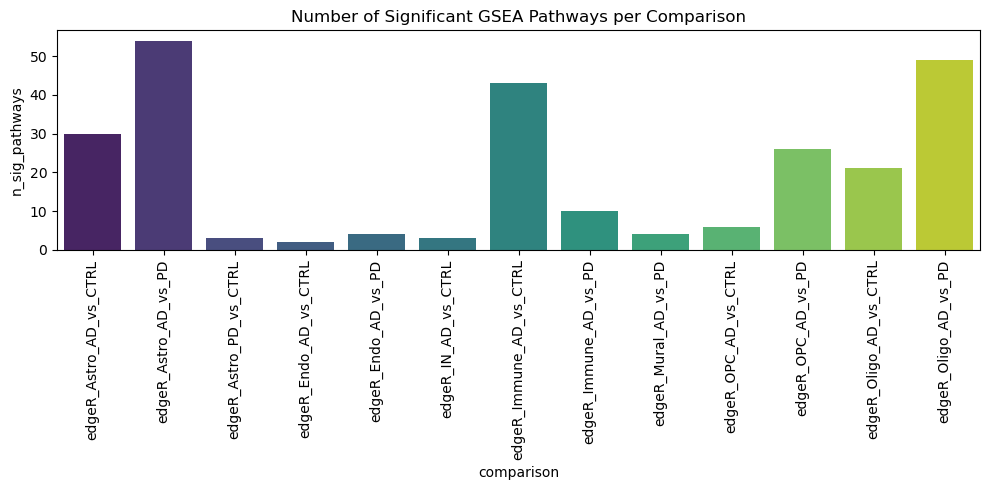

In [7]:
# Number of significant GSEA pathways per comparison (for all 3 databases)
sig = gsea_df[gsea_df["FDR"] < 0.05]

count_df = (
    sig.groupby("comparison")["pathway"]
    .nunique()
    .reset_index()
    .rename(columns = {"pathway": "n_sig_pathways"})
)

plt.figure(figsize= (10, 5))
sns.barplot(data = count_df, x = "comparison", y = "n_sig_pathways", palette = "viridis")

plt.xticks(rotation = 90)
plt.title("Number of Significant GSEA Pathways per Comparison")
plt.tight_layout()
plt.show()

#### *Global directional tendency of the enrichments*

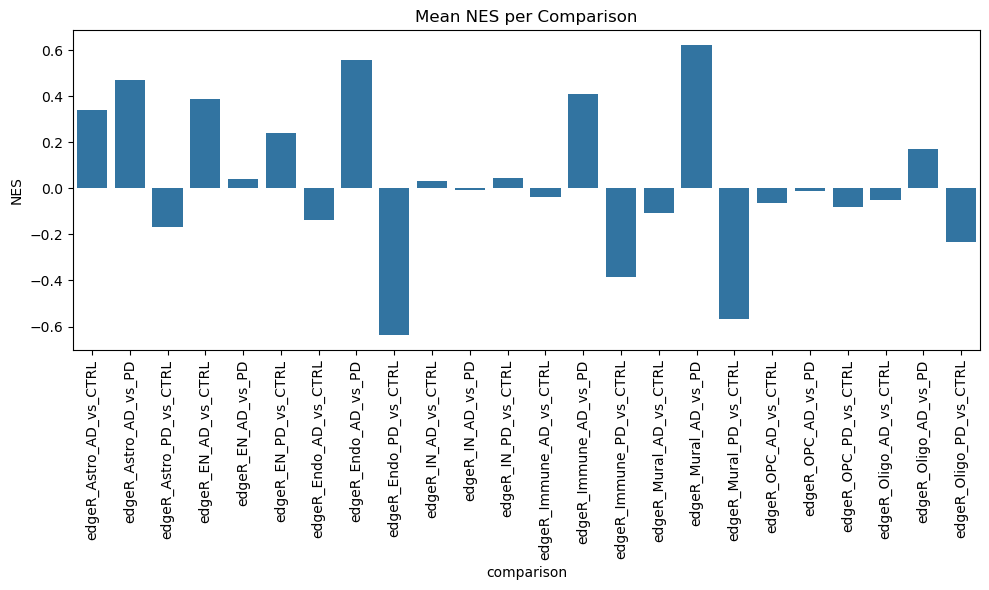

In [8]:
mean_nes = (
    gsea_df.groupby("comparison")["NES"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data = mean_nes, x = "comparison", y = "NES")

plt.xticks(rotation = 90)
plt.title("Mean NES per Comparison")

plt.tight_layout()
plt.show()

#### *Volcano Plot Representation of the Results*

In [9]:
volc_dir = "GSEA_volcano_plots"
os.makedirs(volc_dir, exist_ok = True)

def plot_gsea_volcano(df, title):
    # Standardize column names
    df.columns = [c.lower() for c in df.columns]

    # Compute -log10 p-values
    df["logp"] = -np.log10(df["nom p-val"].replace(0, 1e-300))

    # NES sign for color
    df["direction"] = np.where(df["nes"] > 0, "Up-regulated", "Down-regulated")

    # Prepare output filename
    title = title.replace(" ", "_")
    outfile = os.path.join(volc_dir, f"{title}_volcano.png")

    # Volcano plot
    plt.figure(figsize = (10, 7))
    sns.scatterplot(
        data = df,
        x = "nes",
        y = "logp",
        hue = "direction",
        palette = {"Up-regulated": "#1f77b4", "Down-regulated": "#d62728"},
        alpha = 0.8,
        s = 60
    )

    # Thresholds & styling
    plt.axhline(-np.log10(0.05), color = "gray", linestyle = "--")
    plt.axvline(0, color = "black", linewidth = 1)

    plt.title(title, fontsize=15)
    plt.xlabel("Normalized Enrichment Score (NES)", fontsize = 13)
    plt.ylabel("-log10(p-value)", fontsize = 13)
    plt.legend(title="NES direction")
    plt.tight_layout()

    # Save
    plt.savefig(outfile, dpi = 300, bbox_inches = "tight")
    print(f"Saved volcano → {outfile}")
    plt.close()

In [10]:
# Running the function on all of the GSEA result files
for f in report_files:
    df = pd.read_csv(f)
    name = os.path.basename(os.path.dirname(f))  # folder name = comparison name
    plot_gsea_volcano(df, title = name)

Saved volcano → GSEA_volcano_plots/edgeR_Endo_AD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Astro_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_OPC_AD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Immune_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Immune_PD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Mural_AD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_IN_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Endo_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Oligo_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Mural_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_EN_PD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_Astro_AD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_IN_PD_vs_CTRL_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_EN_AD_vs_PD_volcano.png
Saved volcano → GSEA_volcano_plots/edgeR_OPC_AD_

#### *Plotting the results for MSigDB*

First, we need to save the GSEA results for MSigDB terms in a separate csv. We first used FDR as the indicator of significance, but it turned out to be too conservative given the number of donors that we have. Therefore, we looked at the pvalue as an indicator of significance instead.

In [19]:
msigdb_df = gsea_MSigDB_df[["comparison", "pathway", "NES", "FDR", "NOM p-val"]].dropna(subset=["NES"])

# Keep only Hallmark pathways
msigdb_df["pathway"] = (
    msigdb_df["pathway"]
    .str.replace("HALLMARK_", "", regex=False)
    .str.replace("_", " ", regex=False)
    .str.strip()
)

msigdb_df["comparison"] = (msigdb_df["comparison"].str.replace("edgeR_", "", regex=False).str.replace("_", " ", regex=False))
msigdb_df["celltype"] = msigdb_df["comparison"].str.split(" ").str[0]


print("Loaded MSigDB Hallmark results:", msigdb_df.shape)

msigdb_df.to_csv("MSigDB_Hallmark_only_results.csv", index=False)
print("Saved → MSigDB_Hallmark_only_results.csv")

Loaded MSigDB Hallmark results: (1200, 6)
Saved → MSigDB_Hallmark_only_results.csv


Choosing a cutoff to keep significant terms only:

In [20]:
# choosing cutoff based on FDR values
print("Significant MSigDB Hallmark results (FDR < 0.25):", msigdb_df[msigdb_df["FDR"] < 0.25].shape)
print("Significant MSigDB Hallmark results (FDR < 0.05):", msigdb_df[msigdb_df["FDR"] < 0.05].shape)

# msigdb_sig = msigdb_df[msigdb_df["FDR"] < 0.25] # cutoff chosen: 0.25

Significant MSigDB Hallmark results (FDR < 0.25): (22, 6)
Significant MSigDB Hallmark results (FDR < 0.05): (11, 6)


In [21]:
# choosing cutoff based on p-values
msigdb_sig = msigdb_df[msigdb_df["NOM p-val"] < 0.05] # cutoff chosen: 0.05
print("Significant MSigDB Hallmark results (pvalue < 0.05):", msigdb_sig.shape)

Significant MSigDB Hallmark results (pvalue < 0.05): (164, 6)


Then, we can plot the results:
- For each condition, per cell type, we plot ridgeplots based on the FDR cutoff

In [22]:
# FDR
os.makedirs("MSigDB_sig_ridgeplots_per_cond_FDR", exist_ok = True)

# pvalue
os.makedirs("MSigDB_sig_ridgeplots_per_cond_pvalue", exist_ok = True)

def plot_msigdb_ridge_by_condition(df, top_n = 20, sigma = 0.25):

    # Clean pathway names
    df = df.copy()
    df["pathway_clean"] = (
        df["pathway"]
        .str.replace("MSigDB Hallmark 2020", "", regex = False)
        .str.replace("_", " ", regex = False)
        .str.strip()
    )

    # Extract celltype
    df["celltype"] = df["comparison"].apply(lambda x: x.split()[0])

    # Loop over each cell type
    for cell in sorted(df["celltype"].unique()):

        df_ct = df[df["celltype"] == cell].copy()
        if df_ct.empty:
            print(f"No MSigDB pathways for {cell}")
            continue

        # All comparisons
        comparisons = sorted(df_ct["comparison"].unique())

        for cmp in comparisons:

            df_cmp = df_ct[df_ct["comparison"] == cmp].copy()
            if df_cmp.empty:
                print(f"Nothing for {cell} under {cmp}")
                continue

            # Select top pathways using FDR q-val or NOM p‑val
            top_paths = (
                #df_cmp.groupby("pathway_clean")["FDR q-val"] #FDR
                df_cmp.groupby("pathway_clean")["NOM p-val"] #pvalue
                      .min()
                      .sort_values()
                      .head(top_n)
                      .index
            )

            df_top = df_cmp[df_cmp["pathway_clean"].isin(top_paths)].copy()
            if df_top.empty:
                print(f"No significant MSigDB pathways for {cell} in {cmp}")
                continue

            # Order plotting by NES
            path_order = (
                df_top.groupby("pathway_clean")["NES"]
                      .mean()
                      .sort_values()
                      .index
            )

            # Range for the x-axis
            nes_min = df_top["NES"].min() - 0.5
            nes_max = df_top["NES"].max() + 0.5
            x = np.linspace(nes_min, nes_max, 400)

            # Plot
            fig, ax = plt.subplots(figsize=(12, 0.6 * len(path_order) + 3))

            y_step = 1.0
            for i, path in enumerate(path_order):

                rows = df_top[df_top["pathway_clean"] == path]
                nes_val = rows["NES"].mean()

                y_base = i * y_step
                curve = np.exp(-0.5 * ((x - nes_val) / sigma)**2)
                curve = curve / curve.max() * 0.8
                y = y_base + curve

                ax.fill_between(x, y_base, y, alpha = 0.45, color = "purple")
                ax.plot(x, y, color = "purple", linewidth = 1)

                ax.text(
                    nes_min - 0.1,
                    y_base,
                    path,
                    ha="right",
                    va="center",
                    fontsize = 9
                )

            ax.axvline(0, color = "grey", linestyle = "--", linewidth = 1)

            ax.set_yticks([])
            ax.set_xlim(nes_min - 0.2, nes_max)
            ax.set_xlabel("NES", fontsize = 13)

            title = f"{cell} – MSigDB Hallmark ridgeplot (top {top_n})\nComparison: {cmp}"
            ax.set_title(fill(title, width = 60), fontsize = 16, pad = 20)

            plt.tight_layout()
            #out = f"MSigDB_sig_ridgeplots_FDR/{cell}_{cmp}_MSigDB_ridgeplot_top{top_n}.png" #FDR
            out = f"MSigDB_sig_ridgeplots_pvalue/{cell}_{cmp}_MSigDB_ridgeplot_top{top_n}.png" #pvalue
            plt.savefig(out, dpi = 300, bbox_inches = "tight")
            plt.close()

            print("Saved:", out)


In [16]:
# Run for all cell types
plot_msigdb_ridge_by_condition(msigdb_df, top_n = 20)

Saved: MSigDB_sig_ridgeplots_pvalue/Astro_Astro AD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/Astro_Astro AD vs PD_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/Astro_Astro PD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/EN_EN AD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/EN_EN AD vs PD_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/EN_EN PD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/Endo_Endo AD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/Endo_Endo AD vs PD_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/Endo_Endo PD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/IN_IN AD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/IN_IN AD vs PD_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_ridgeplots_pvalue/IN_IN PD vs CTRL_MSigDB_ridgeplot_top20.png
Saved: MSigDB_sig_

- For each condition, per cell type, we plot ridgeplots based on the p-value cutoff

In [23]:
sns.set_theme(style = "whitegrid")

def plot_cell_type_ridge(cell, df, top_n = 20, cutoff = 0.05):
    df_ct = df[df["celltype"] == cell].copy()
    if df_ct.empty:
        print(f"No rows for cell type {cell}")
        return

    # Top pathways for this cell type
    top_paths = (
        #df_ct.groupby("pathway")["FDR q-val"] # Best FDR across conditions
        df_ct.groupby("pathway")["NOM p-val"] # Best pvalue across conditions
             .min()
             .sort_values()
             .head(top_n) 
             .index
    )
    df_top = df_ct[df_ct["pathway"].isin(top_paths)].copy()

    # Order pathways by mean NES
    path_order = (
        df_top.groupby("pathway")["NES"]
              .mean()
              .sort_values()
              .index
    )

    comps = sorted(df_top["comparison"].unique())
    colors = dict(zip(comps, sns.color_palette("Set2", len(comps))))

    # Common x‑range for all ridges
    nes_min = df_top["NES"].min() - 0.5
    nes_max = df_top["NES"].max() + 0.5
    x = np.linspace(nes_min, nes_max, 400)

    fig, ax = plt.subplots(figsize = (10, 0.5 * len(path_order) + 2))
    y_step = 1.0

    for i, path in enumerate(path_order):
        y_base = i * y_step
        sub = df_top[df_top["pathway"] == path]

        for cmp in comps:
            rows = sub[sub["comparison"] == cmp]
            if rows.empty:
                continue

            nes = rows["NES"].iloc[0]

            # Gaussian "bump" centered at NES
            curve = np.exp(-0.5 * ((x - nes) / cutoff) ** 2)
            curve = curve / curve.max() * 0.8  # normalize height

            y = y_base + curve

            ax.fill_between(x, y_base, y,
                            color = colors[cmp], alpha = 0.4)
            ax.plot(x, y, color = colors[cmp], linewidth = 1)

        # Pathway label on the left
        ax.text(nes_min - 0.1, y_base,
                path,
                ha = "right", va = "center", fontsize = 8)

    ax.axvline(0, color = "grey", linestyle = "--", linewidth = 0.8)
    ax.set_yticks([])
    ax.set_xlabel("NES")
    ax.set_xlim(nes_min - 0.2, nes_max)
    ax.set_title(f"{cell} – MSigDB Hallmark ridge-style NES (top {top_n} pathways)",
                 fontsize = 14)

    # Legend for conditions
    handles = [
        plt.Line2D([0], [0], color = colors[c], lw = 3, label = c)
        for c in comps
    ]
    ax.legend(handles = handles, 
              title = "Comparison", 
              bbox_to_anchor = (1.02, 1),
              loc = "upper left", 
              fontsize = 8)

    plt.tight_layout()
    # out = f"MSigDB_sig_ridgeplots_pvalue_FDR/{cell}_MSigDB_ridge.png" #FDR 
    out = f"MSigDB_sig_ridgeplots_pvalue/{cell}_MSigDB_ridge.png" # pvalue
    plt.savefig(out, dpi = 300)
    plt.close()
    print("Saved:", out)

In [24]:
# Run for all cell types
for cell in sorted(msigdb_df["celltype"].unique()):
    plot_cell_type_ridge(cell, msigdb_df, top_n = 20)

Saved: MSigDB_sig_ridgeplots_pvalue/Astro_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/EN_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/Endo_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/IN_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/Immune_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/Mural_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/OPC_MSigDB_ridge.png
Saved: MSigDB_sig_ridgeplots_pvalue/Oligo_MSigDB_ridge.png


#### *Plotting the results for GO*

First, we need to save the GSEA results for GO terms in a separate dataframe:

In [25]:
go_df = gsea_GO_df[["comparison", "pathway", "NES", "FDR", "NOM p-val"]].dropna(subset=["NES"])

# Keep only Hallmark pathways
go_df["pathway"] = (
    go_df["pathway"]
    .str.replace("GO_Biological_Process", "", regex=False)
    .str.replace("GO_Biological_Process_2021_", "", regex=False)
    .str.replace("_", " ", regex=False)
    .str.strip()
)

go_df["comparison"] = (go_df["comparison"].str.replace("edgeR_", "", regex=False).str.replace("_", " ", regex=False).str.strip())
go_df["celltype"] = go_df["comparison"].str.split(" ").str[0]


print("Loaded GO results:", go_df.shape)

go_df.to_csv("GO_only_results.csv", index=False)
print("Saved → GO_only_results.csv")


Loaded GO results: (108636, 6)
Saved → GO_only_results.csv


In [26]:
go_df.head()

comparison                                            pathway  \
2  Endo AD vs CTRL  2021  negative regulation of viral genome repl...   
3  Endo AD vs CTRL               2021  gland development (GO:0048732)   
4  Endo AD vs CTRL  2021  anterograde trans-synaptic signaling (GO...   
6  Endo AD vs CTRL  2021  regulation of viral genome replication (...   
7  Endo AD vs CTRL  2021  type I interferon signaling pathway (GO:...   

        NES       FDR  NOM p-val celltype  
2 -1.743701  0.235990   0.000000     Endo  
3 -1.718131  0.301635   0.000000     Endo  
4  1.713517  1.000000   0.000000     Endo  
6 -1.692044  0.365618   0.015152     Endo  
7 -1.684013  0.324071   0.000000     Endo

In [27]:
# Selecting an FDR cutoff to determine significativity
# GO_sig = go_df[go_df["FDR q-val"] < 05.25] # cutoff chosen: 0.05
print("Significant GO Biological Process results (FDR < 0.05):", go_df[go_df["FDR"] < 0.05].shape)

Significant GO Biological Process results (FDR < 0.05): (148, 6)


In [28]:
# Selecting an pvalue cutoff to determine significativity
GO_sig = go_df[go_df["NOM p-val"] < 0.05] # cutoff chosen: 0.05
print("Significant GO Biological Process results (pvalue < 0.05):", GO_sig.shape)

Significant GO Biological Process results (pvalue < 0.05): (6954, 6)


In [29]:
GO_sig

comparison                                            pathway  \
2       Endo AD vs CTRL  2021  negative regulation of viral genome repl...   
3       Endo AD vs CTRL               2021  gland development (GO:0048732)   
4       Endo AD vs CTRL  2021  anterograde trans-synaptic signaling (GO...   
6       Endo AD vs CTRL  2021  regulation of viral genome replication (...   
7       Endo AD vs CTRL  2021  type I interferon signaling pathway (GO:...   
...                 ...                                                ...   
111442  Endo PD vs CTRL      2021  regulation of neuron death (GO:1901214)   
111449  Endo PD vs CTRL  2021  cellular macromolecule biosynthetic proc...   
111489  Endo PD vs CTRL  2021  regulation of neurotransmitter transport...   
111501  Endo PD vs CTRL  2021  transmembrane receptor protein tyrosine ...   
111539  Endo PD vs CTRL        2021  triglyceride homeostasis (GO:0070328)   

             NES       FDR  NOM p-val celltype  
2      -1.743701  0.235990   0.000000     Endo  
3      -1.718131  0.301635   0.000000     Endo  
4       1.713517  1.000000   0.000000     Endo  
6      -1.692044  0.365618   0.015152     Endo  
7      -1.684013  0.324071   0.000000     Endo  
...          ...       ...        ...      ...  
111442 -1.332361  0.980252   0.023810     Endo  
111449 -1.329434  0.972529   0.021505     Endo  
111489 -1.314341  0.967015   0.049180     Endo  
111501 -1.309087  0.968855   0.030612     Endo  
111539 -1.292718  0.978831   0.049180     Endo  

[6954 rows x 6 columns]

Now, we can plot the results:

In [30]:
sns.set_theme(style = "whitegrid")
#os.makedirs("GO_sig_ridgeplots_FDR", exist_ok = True)
#os.makedirs("GO_sig_ridgeplots_per_cond_FDR", exist_ok = True)

os.makedirs("GO_sig_ridgeplots_pvalue", exist_ok = True)
os.makedirs("GO_sig_ridgeplots_per_cond_pvalue", exist_ok = True)

# First, define a function to clean GO labels for a more readable ridgeplot
def clean_go_label(term: str) -> str:
    s = str(term).strip()

    # Remove ANY "GO Biological Process ..." prefix no matter spacing or underscore pattern
    s = re.sub(r"^GO[\s_]*Biological[\s_]*Process[\s_]*\d{4}\s*", "", s)

    # Remove GO ID suffix "(GO:xxxxxxx)"
    s = re.sub(r"\(GO:\s*\d+\)", "", s)

    # Clean remaining underscores and trim spaces
    s = s.replace("_", " ")
    return " ".join(s.split())

In [31]:
# Then, define the function to plot the results for GO terms in a ridgeplot
def plot_go_ridge(cell, df, top_n = 20, sigma = 0.25):
    """
    Ridge‑style NES plot for one cell type across all comparisons.
    Uses simple Gaussians centered at NES for each (pathway, comparison).
    """

    df_ct = df[df["celltype"] == cell].copy()
    if df_ct.empty:
        print(f"No GO BP rows for {cell}")
        return

    # Clean pathway names
    df_ct["pathway_clean"] = df_ct["pathway"].apply(clean_go_label)

    # Select top pathways across comparisons
    top_paths = (
        #df_ct.groupby("pathway_clean")["FDR q-val"] # best/min FDR
        df_ct.groupby("pathway_clean")["NOM p-val"] # best/min p-value
             .min()
             .sort_values()
             .head(top_n)
             .index
    )
    df_top = df_ct[df_ct["pathway_clean"].isin(top_paths)].copy()

    # Order pathways by mean NES (bottom→top)
    path_order = (
        df_top.groupby("pathway_clean")["NES"]
              .mean()
              .sort_values()
              .index
    )

    # Comparisons & colors
    comps = sorted(df_top["comparison"].unique())
    colors = dict(zip(comps, sns.color_palette("Set2", len(comps))))

    # Common x‑axis range
    nes_min = df_top["NES"].min() - 0.5
    nes_max = df_top["NES"].max() + 0.5
    x = np.linspace(nes_min, nes_max, 400)

    # Figure dimensions
    fig, ax = plt.subplots(figsize = (12, 0.6 * len(path_order) + 3))
    y_step = 1.0

    for i, path in enumerate(path_order):
        y_base = i * y_step
        sub = df_top[df_top["pathway_clean"] == path]

        for cmp in comps:
            rows = sub[sub["comparison"] == cmp]
            if rows.empty:
                continue

            nes = rows["NES"].iloc[0]

            # Gaussian "ridge" centered at NES
            curve = np.exp(-0.5 * ((x - nes) / sigma) ** 2)
            curve = curve / curve.max() * 0.8 
            y = y_base + curve

            ax.fill_between(x, y_base, y, color = colors[cmp], alpha = 0.45)
            ax.plot(x, y, color = colors[cmp], linewidth = 1)

        # Pathway label on the left
        ax.text(
            nes_min - 0.1, y_base,
            path,
            ha = "right", 
            va = "center", 
            fontsize = 9
        )

    # Vertical NES = 0 line
    ax.axvline(0, color = "grey", linestyle = "--", linewidth = 1)

    ax.set_yticks([])
    ax.set_xlim(nes_min - 0.2, nes_max)
    ax.set_xlabel("NES", fontsize = 13)

    title = f"{cell} - GO Biological Process ridge - style NES (top {top_n} pathways)"
    ax.set_title(fill(title, width=60), fontsize=16, pad=20)

    # Legend
    handles = [
        plt.Line2D([0], [0], color = colors[c], lw = 3, label = c)
        for c in comps
    ]
    ax.legend(handles = handles, 
              title = "Comparison",
              bbox_to_anchor = (1.02, 1), 
              loc = "upper left", 
              fontsize = 9)

    plt.tight_layout()

    # out = f"GO_sig_ridgeplots_FDR/{cell}_GO_BP_ridgeplot_top{top_n}.png"
    out = f"GO_sig_ridgeplots_pvalue/{cell}_GO_BP_ridgeplot_top{top_n}.png"
    plt.savefig(out, dpi = 300, bbox_inches = "tight")
    plt.close()

    print("Saved:", out)

In [32]:
#Finally, plot the results for each cell type (for all three studied conditions)
for cell in sorted(GO_sig["celltype"].unique()):
    plot_go_ridge(cell, GO_sig, top_n = 20)

Saved: GO_sig_ridgeplots_pvalue/Astro_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/EN_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/Endo_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/IN_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/Immune_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/Mural_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/OPC_GO_BP_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_pvalue/Oligo_GO_BP_ridgeplot_top20.png


We can also plot the results for each cell type and for each condition separately:

In [33]:
def plot_go_ridge_by_condition(cell, df, top_n = 20, sigma = 0.25):
    """
    Generate SEPARATE ridgeplots per comparison:
      • AD_vs_CTRL
      • PD_vs_CTRL
      • AD_vs_PD
    """

    df_ct = df[df["celltype"] == cell].copy()
    if df_ct.empty:
        print(f"No GO BP rows for {cell}")
        return

    # Clean pathway names
    df_ct["pathway_clean"] = df_ct["pathway"].apply(clean_go_label)

    # Which comparisons exist?
    comparisons = sorted(df_ct["comparison"].unique())

    for cmp in comparisons:
        df_cmp = df_ct[df_ct["comparison"] == cmp].copy()
        if df_cmp.empty:
            continue

        # Select top pathways within this comparison
        top_paths = (
            #df_cmp.groupby("pathway_clean")["FDR q-val"]
            df_cmp.groupby("pathway_clean")["NOM p-val"]
                  .min()
                  .sort_values()
                  .head(top_n)
                  .index
        )
        df_top = df_cmp[df_cmp["pathway_clean"].isin(top_paths)].copy()

        if df_top.empty:
            print(f"No significant pathways for {cell} in {cmp}")
            continue

        # Order pathways by NES (bottom to top)
        path_order = (
            df_top.groupby("pathway_clean")["NES"]
                  .mean()
                  .sort_values()
                  .index
        )

        # Common x-range
        nes_min = df_top["NES"].min() - 0.5
        nes_max = df_top["NES"].max() + 0.5
        x = np.linspace(nes_min, nes_max, 400)

        # Figure
        fig, ax = plt.subplots(figsize=(12, 0.6 * len(path_order) + 3))
        y_step = 1.0

        for i, path in enumerate(path_order):
            y_base = i * y_step
            row = df_top[df_top["pathway_clean"] == path].iloc[0]

            nes = row["NES"]

            # Gaussian curve
            curve = np.exp(-0.5 * ((x - nes) / sigma) ** 2)
            curve = curve / curve.max() * 0.8
            y = y_base + curve

            ax.fill_between(x, y_base, y, alpha = 0.45, color = "steelblue")
            ax.plot(x, y, color = "steelblue", linewidth = 1)

            # Label
            ax.text(
                nes_min - 0.1,
                y_base,
                path,
                ha = "right",
                va = "center",
                fontsize = 9
            )

        # NES = 0 line
        ax.axvline(0, color = "grey", linestyle = "--", linewidth = 1)

        ax.set_yticks([])
        ax.set_xlim(nes_min - 0.2, nes_max)
        ax.set_xlabel("NES", fontsize=13)

        title = f"{cell} – GO BP ridgeplot (top {top_n})\nComparison: {cmp}"
        ax.set_title(fill(title, width = 60), fontsize = 16, pad = 20)

        plt.tight_layout()

        #out = f"GO_sig_ridgeplots_per_cond_FDR/{cell}_GO_BP_{cmp}_ridgeplot_top{top_n}.png"
        out = f"GO_sig_ridgeplots_per_cond_pvalue/{cell}_GO_BP_{cmp}_ridgeplot_top{top_n}.png"
        plt.savefig(out, dpi = 300, bbox_inches = "tight")
        plt.close()

        print("Saved:", out)

In [34]:
#Finally, plot the results for each cell type (for all three studied conditions)
for cell in sorted(GO_sig["celltype"].unique()):
    plot_go_ridge_by_condition(cell, GO_sig, top_n = 20)

Saved: GO_sig_ridgeplots_per_cond_pvalue/Astro_GO_BP_Astro AD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/Astro_GO_BP_Astro AD vs PD_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/Astro_GO_BP_Astro PD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/EN_GO_BP_EN AD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/EN_GO_BP_EN AD vs PD_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/EN_GO_BP_EN PD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/Endo_GO_BP_Endo AD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/Endo_GO_BP_Endo AD vs PD_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/Endo_GO_BP_Endo PD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/IN_GO_BP_IN AD vs CTRL_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/IN_GO_BP_IN AD vs PD_ridgeplot_top20.png
Saved: GO_sig_ridgeplots_per_cond_pvalue/IN_GO_BP_IN P

## **ORA**

In [39]:
os.makedirs("ORA_enrichr_results", exist_ok = True)

### ORA: "Up" vs. "Down" Sig DEGs

In [40]:
print("Running ORA on all DEG files...\n")

for file in files:
    df = pd.read_csv(file)

    # Remove missing gene names
    df = df.dropna(subset=["gene_symbol"])

    # Split up and down regulated genes
    up_genes = df[(df["logFC"] > 0) & (df["PValue"] < 0.2)]["gene_symbol"].tolist()
    down_genes = df[(df["logFC"] < 0) & (df["PValue"] < 0.2)]["gene_symbol"].tolist()

    base = os.path.basename(file).replace(".csv", "")

    # Run ORA for up and down regulated genes
    for direction, gene_list in [("UP", up_genes), ("DOWN", down_genes)]:

        if len(gene_list) == 0:
            print(f"No {direction} genes in {base}")
            continue

        print(f"→ Running ORA for {base} ({direction}, {len(gene_list)} genes)")

        try:
            enr = gp.enrichr(
                gene_list = gene_list,
                gene_sets = libs,
                organism = "Human",
                outdir = f"ORA_enrichr_results/{base}_{direction}",
                cutoff = 0.5  # keeps everything significant
            )

        except Exception as e:
            print(f"Error running Enrichr for {base} {direction}: {e}")
            continue

        # Save results
        for lib in libs:
            try:
                df_out = enr.results[enr.results["Gene_set"] == lib]
                outfile = f"ORA_enrichr_results/{base}_{direction}_{lib}.csv"
                df_out.to_csv(outfile, index = False)
                print(f"Saved {outfile}")
            except Exception as e:
                print(f"Library {lib} missing for {base} {direction}: {e}")

print("\n ORA completed for all DEG files!")

Running ORA on all DEG files...

→ Running ORA for edgeR_Mural_AD_vs_PD (UP, 1062 genes)
Error running Enrichr for edgeR_Mural_AD_vs_PD UP: name 'libs' is not defined
→ Running ORA for edgeR_Mural_AD_vs_PD (DOWN, 323 genes)
Error running Enrichr for edgeR_Mural_AD_vs_PD DOWN: name 'libs' is not defined
→ Running ORA for edgeR_Immune_AD_vs_CTRL (UP, 1089 genes)
Error running Enrichr for edgeR_Immune_AD_vs_CTRL UP: name 'libs' is not defined
→ Running ORA for edgeR_Immune_AD_vs_CTRL (DOWN, 1337 genes)
Error running Enrichr for edgeR_Immune_AD_vs_CTRL DOWN: name 'libs' is not defined
→ Running ORA for edgeR_Endo_PD_vs_CTRL (UP, 238 genes)
Error running Enrichr for edgeR_Endo_PD_vs_CTRL UP: name 'libs' is not defined
→ Running ORA for edgeR_Endo_PD_vs_CTRL (DOWN, 505 genes)
Error running Enrichr for edgeR_Endo_PD_vs_CTRL DOWN: name 'libs' is not defined
→ Running ORA for edgeR_EN_AD_vs_PD (UP, 2035 genes)
Error running Enrichr for edgeR_EN_AD_vs_PD UP: name 'libs' is not defined
→ Running 

#### Results

In [41]:
# Load results
GO_ROOT = "ORA_enrichr_results"

go_reports = glob.glob(
    os.path.join(GO_ROOT, "*", "GO_Biological_Process_2021.Human.enrichr.reports.txt"), recursive = True)

print("Found reports for GO:", len(go_reports))

msig_go_reports = glob.glob(
    os.path.join(GO_ROOT, "*", "MSigDB_Hallmark_2020.Human.enrichr.reports.txt"), recursive = True)

print("Found reports for MSigDB:", len(msig_go_reports))

kegg_go_reports = glob.glob(
    os.path.join(GO_ROOT, "*", "KEGG_2021_Human.Human.enrichr.reports.txt"), recursive = True)

print("Found reports for KEGG:", len(kegg_go_reports))

Found reports for GO: 0
Found reports for MSigDB: 0
Found reports for KEGG: 0


#### Plotting the Results:

In [ ]:
input_folder = "ORA_enrichr_results"
output_folder = "ORA_dotplots"
os.makedirs(output_folder, exist_ok = True)

top_n = 20 # number of pathways to show per dotplot

In [ ]:
def clean_enrichr_df(df):
    """Standardize enrichr output so gseapy dotplot accepts it."""
    
    # Enrichr names vary; standardize columns
    rename_map = {
        'Term name': 'Term',
        'Adjusted p-value': 'Adjusted P-value',
        'Overlap': 'Overlap'
    }

    df = df.rename(columns = rename_map)

    required_cols = ["Term", "Adjusted P-value", "Overlap", "Combined Score"]

    # Keep only needed columns that exist
    keep_cols = [c for c in required_cols if c in df.columns]
    return df[keep_cols].dropna()

In [ ]:
def plot_dotplot(df, title, outfile):
    """Create a dotplot from an Enrichr result dataframe and return the Figure."""
    try:
        fig = plt.figure(figsize=(7, 6))

        gp.dotplot(
            df,
            title = title,
            size = 10,
            top_term = 20,
            cmap = "viridis",
            figsize = (7, 6),
            ofname = None,
            ax = None
        )

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Dotplot failed for {title}: {e}")
        plt.close()
        return None

Generating per-condition dotplots...

Saved: ORA_dotplots/edgeR_Astro_AD_vs_CTRL_DOWN_GO_Biological_Process_2021_dotplot.png
Saved: ORA_dotplots/edgeR_Astro_AD_vs_CTRL_DOWN_KEGG_2021_Human_dotplot.png
Saved: ORA_dotplots/edgeR_Astro_AD_vs_CTRL_DOWN_MSigDB_Hallmark_2020_dotplot.png
Dotplot failed for edgeR_Astro_AD (vs) – CTRL_UP_GO_Biological_Process_2021: Warning: No enrich terms when cutoff = 0.05
Failed to plot edgeR_Astro_AD_vs_CTRL_UP_GO_Biological_Process_2021
Dotplot failed for edgeR_Astro_AD (vs) – CTRL_UP_KEGG_2021_Human: Warning: No enrich terms when cutoff = 0.05
Failed to plot edgeR_Astro_AD_vs_CTRL_UP_KEGG_2021_Human
Dotplot failed for edgeR_Astro_AD (vs) – CTRL_UP_MSigDB_Hallmark_2020: Warning: No enrich terms when cutoff = 0.05
Failed to plot edgeR_Astro_AD_vs_CTRL_UP_MSigDB_Hallmark_2020
Dotplot failed for edgeR_Astro_AD (vs) – PD_DOWN_GO_Biological_Process_2021: Warning: No enrich terms when cutoff = 0.05
Failed to plot edgeR_Astro_AD_vs_PD_DOWN_GO_Biological_Process_2

c:\Users\yarad\AppData\Local\spyder-6\envs\spyder-runtime\Lib\site-packages\gseapy\plot.py:841: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=self.figsize)


Saved: ORA_dotplots/edgeR_Mural_PD_vs_CTRL_DOWN_KEGG_2021_Human_dotplot.png


C:\Users\yarad\AppData\Local\Temp\ipykernel_6264\1473639192.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7, 6))


Saved: ORA_dotplots/edgeR_Mural_PD_vs_CTRL_DOWN_MSigDB_Hallmark_2020_dotplot.png
Saved: ORA_dotplots/edgeR_Mural_PD_vs_CTRL_UP_GO_Biological_Process_2021_dotplot.png
Saved: ORA_dotplots/edgeR_Mural_PD_vs_CTRL_UP_KEGG_2021_Human_dotplot.png
Saved: ORA_dotplots/edgeR_Mural_PD_vs_CTRL_UP_MSigDB_Hallmark_2020_dotplot.png
Saved: ORA_dotplots/edgeR_Oligo_AD_vs_CTRL_DOWN_GO_Biological_Process_2021_dotplot.png
Saved: ORA_dotplots/edgeR_Oligo_AD_vs_CTRL_DOWN_KEGG_2021_Human_dotplot.png
Saved: ORA_dotplots/edgeR_Oligo_AD_vs_CTRL_DOWN_MSigDB_Hallmark_2020_dotplot.png
Dotplot failed for edgeR_Oligo_AD (vs) – CTRL_UP_GO_Biological_Process_2021: Warning: No enrich terms when cutoff = 0.05
Failed to plot edgeR_Oligo_AD_vs_CTRL_UP_GO_Biological_Process_2021
Dotplot failed for edgeR_Oligo_AD (vs) – CTRL_UP_KEGG_2021_Human: Warning: No enrich terms when cutoff = 0.05
Failed to plot edgeR_Oligo_AD_vs_CTRL_UP_KEGG_2021_Human
Dotplot failed for edgeR_Oligo_AD (vs) – CTRL_UP_MSigDB_Hallmark_2020: Warning: N

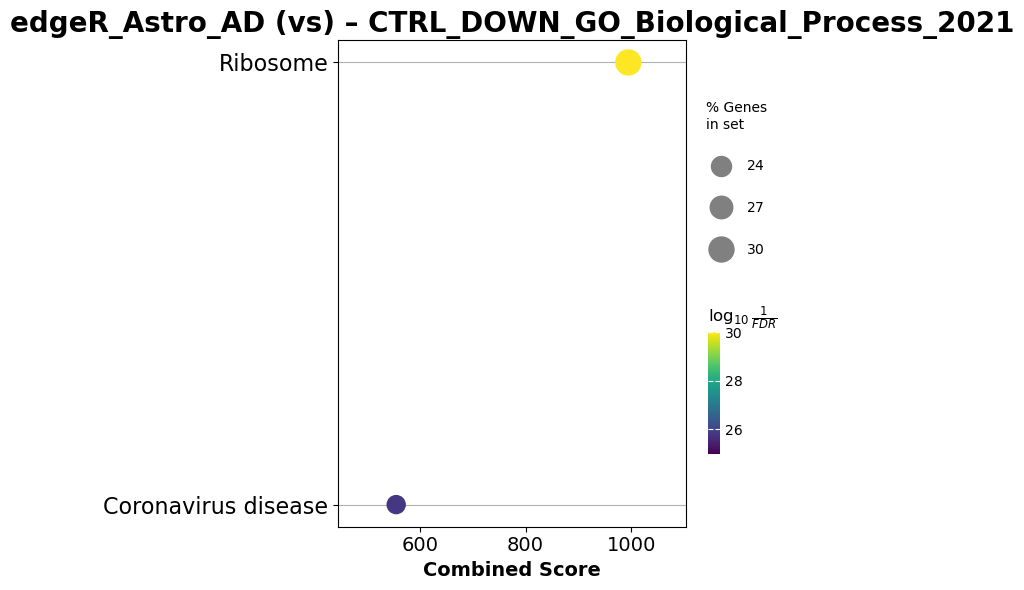

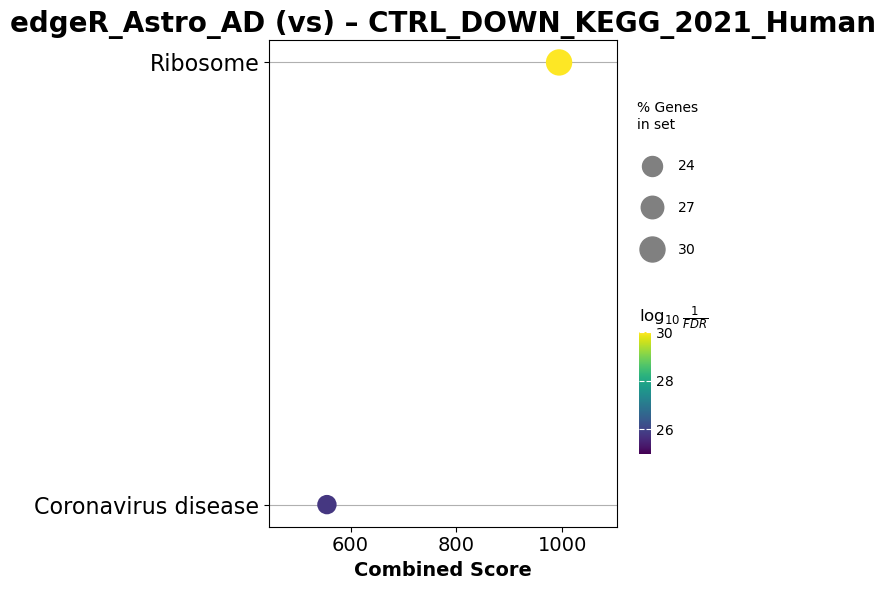

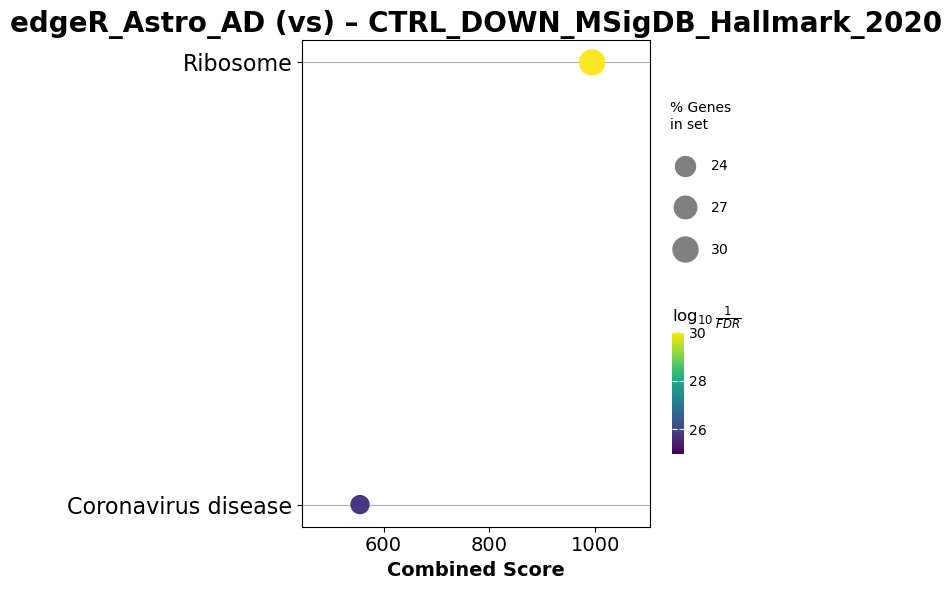

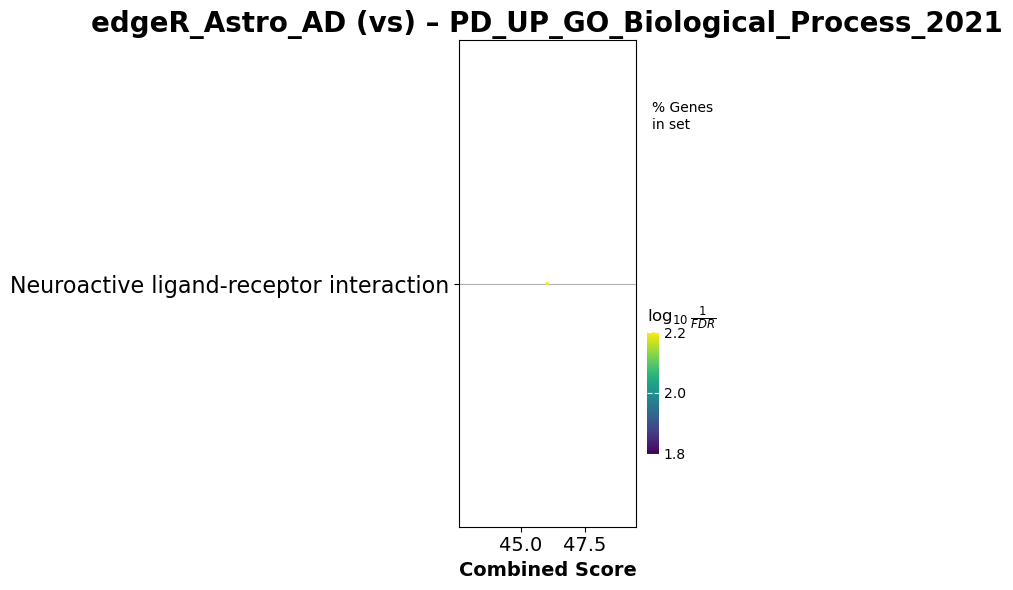

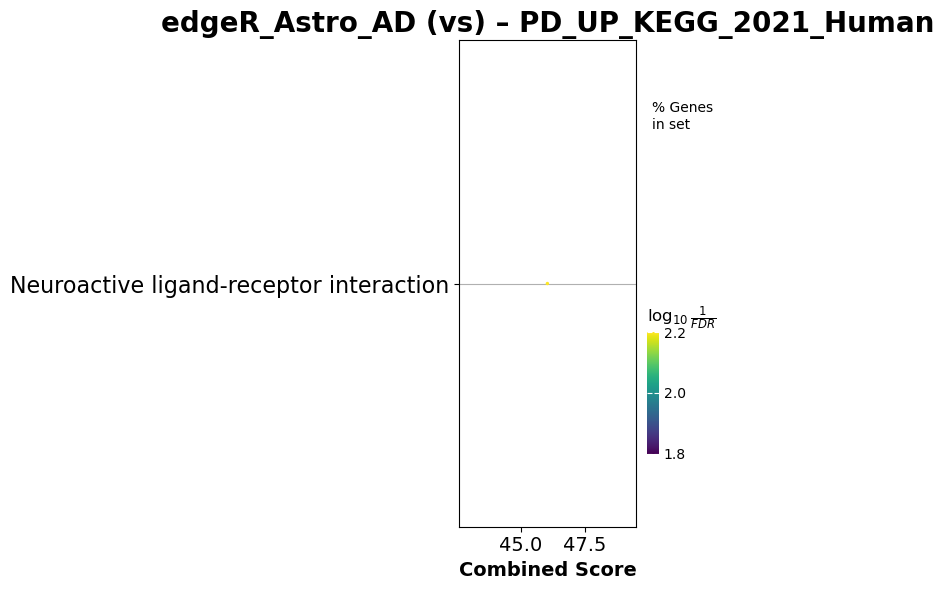

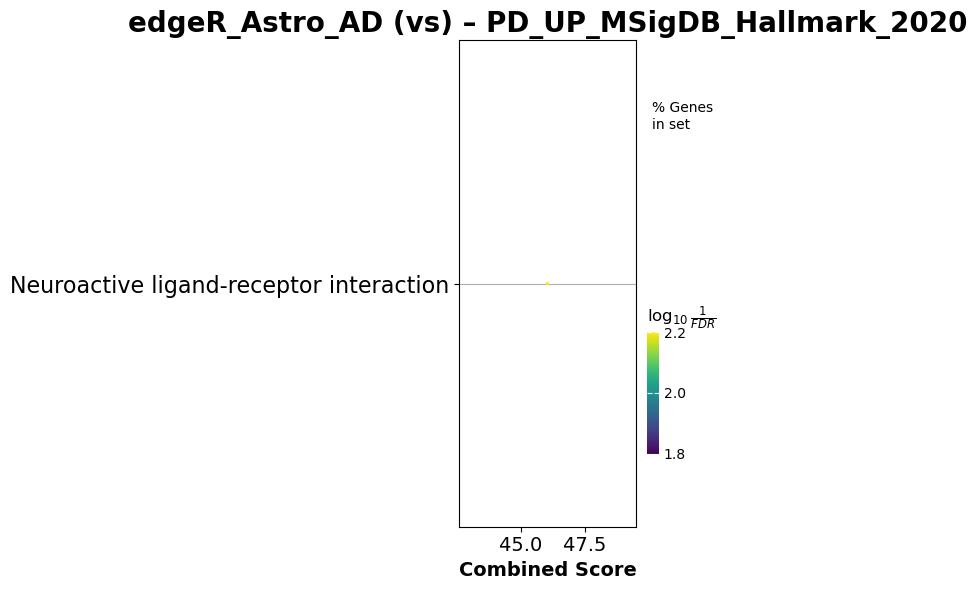

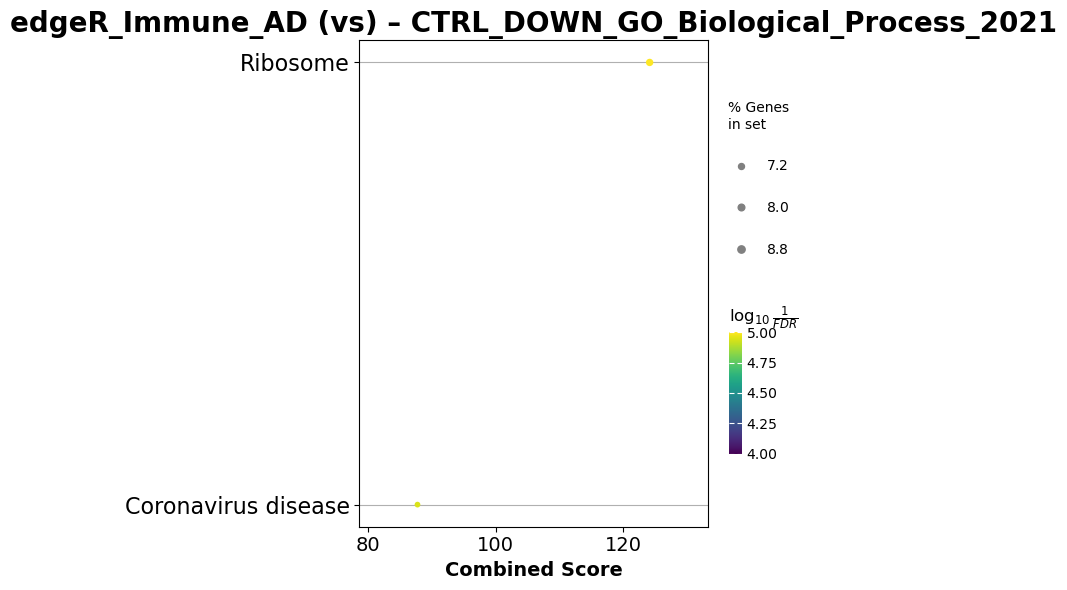

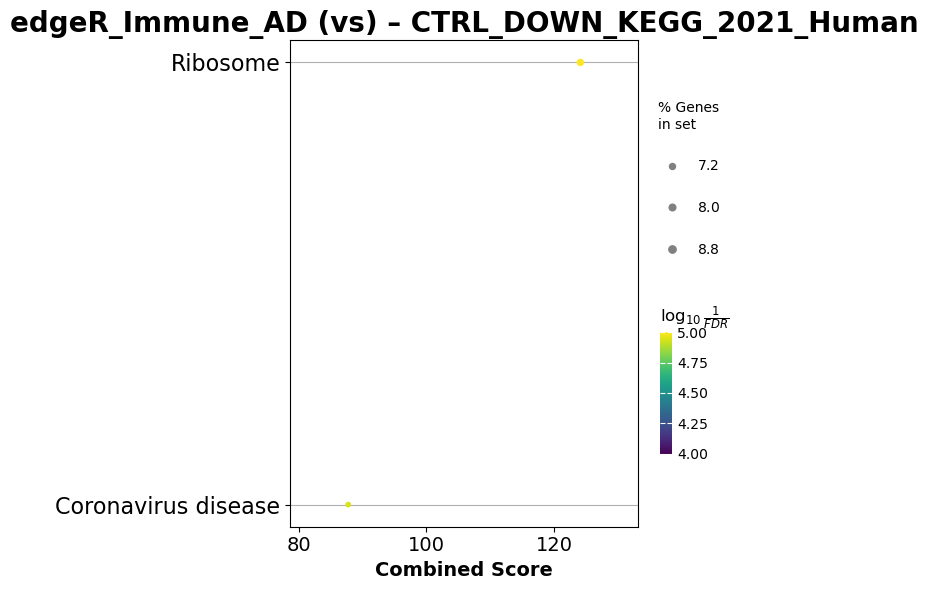

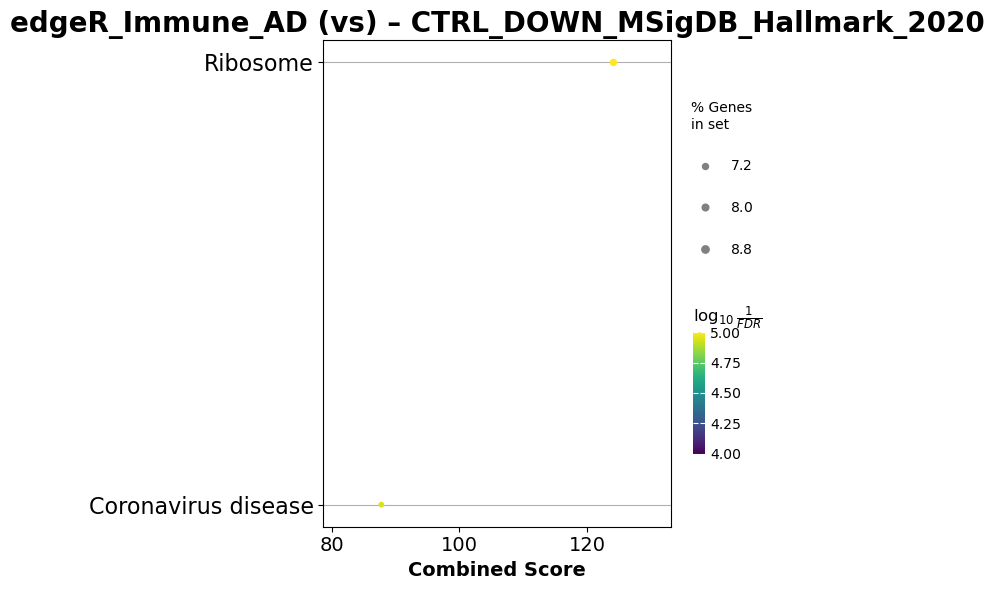

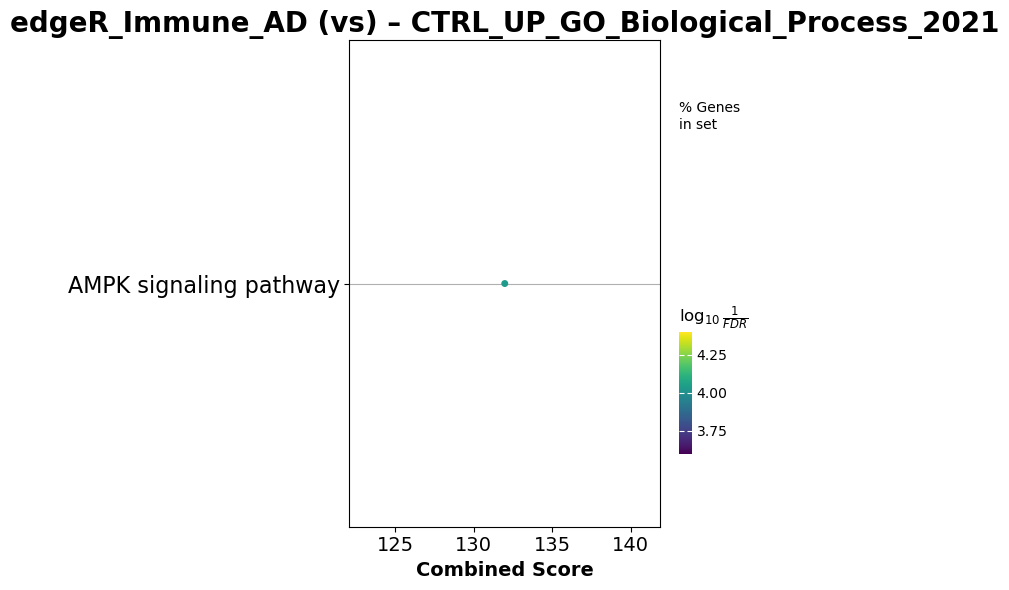

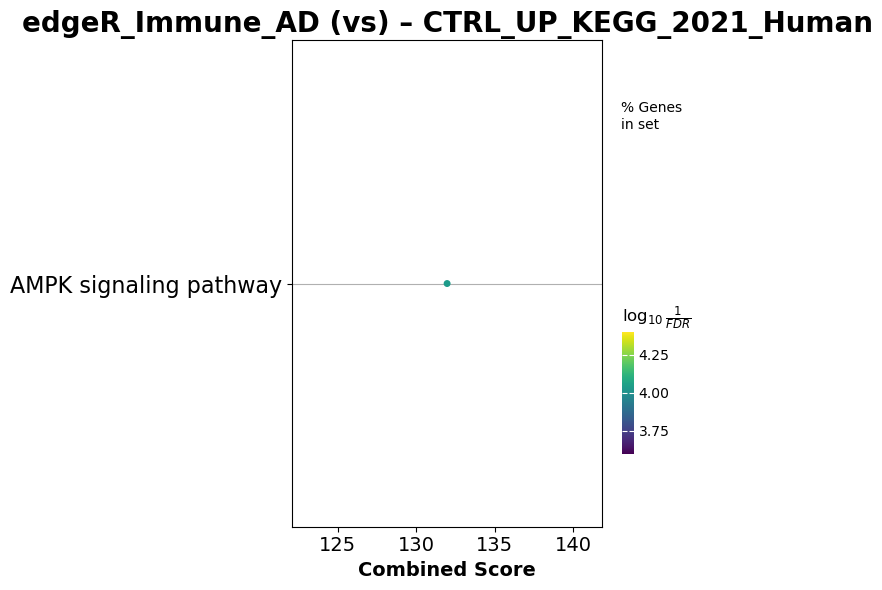

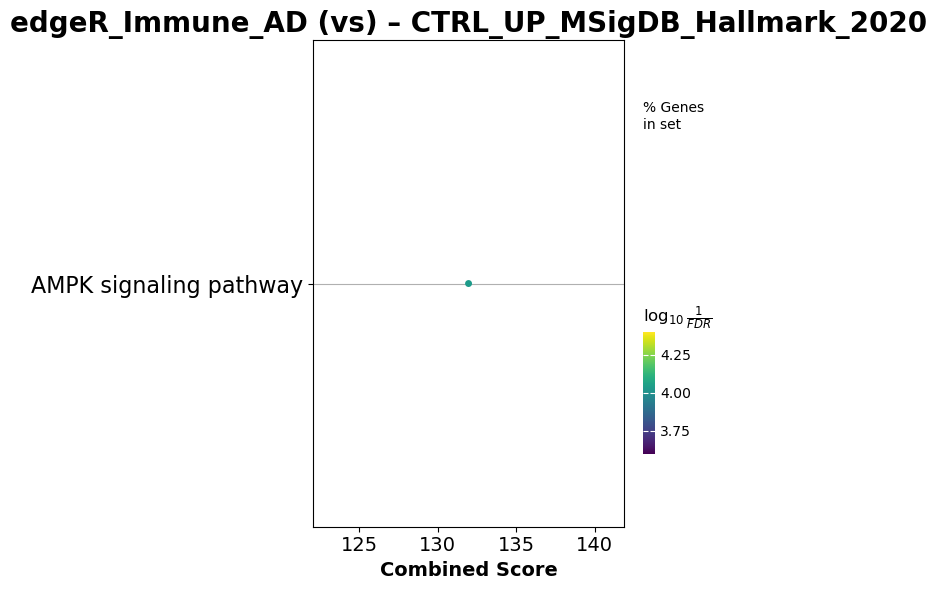

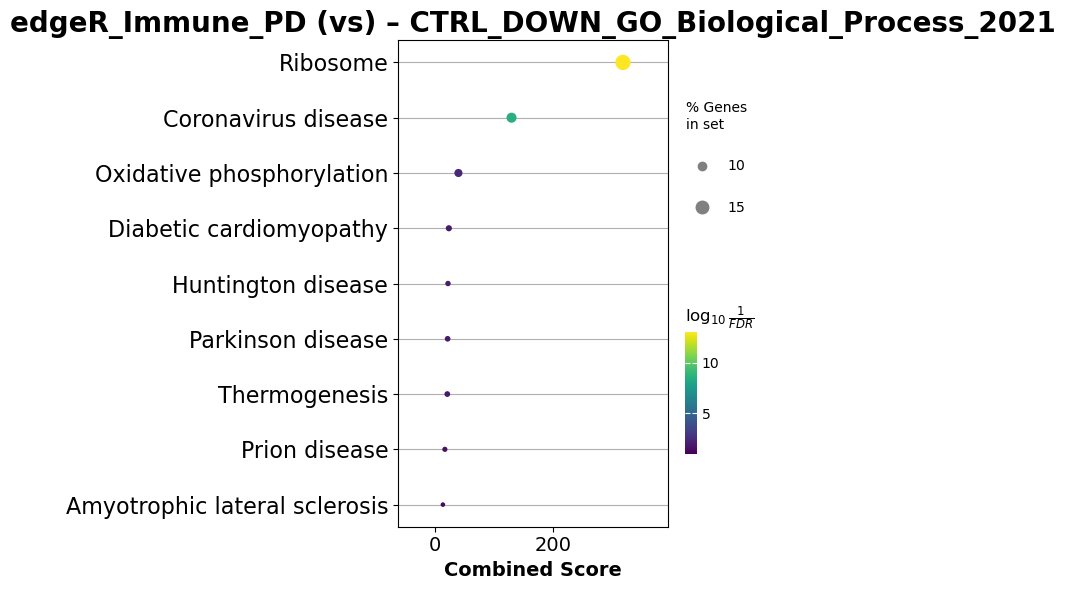

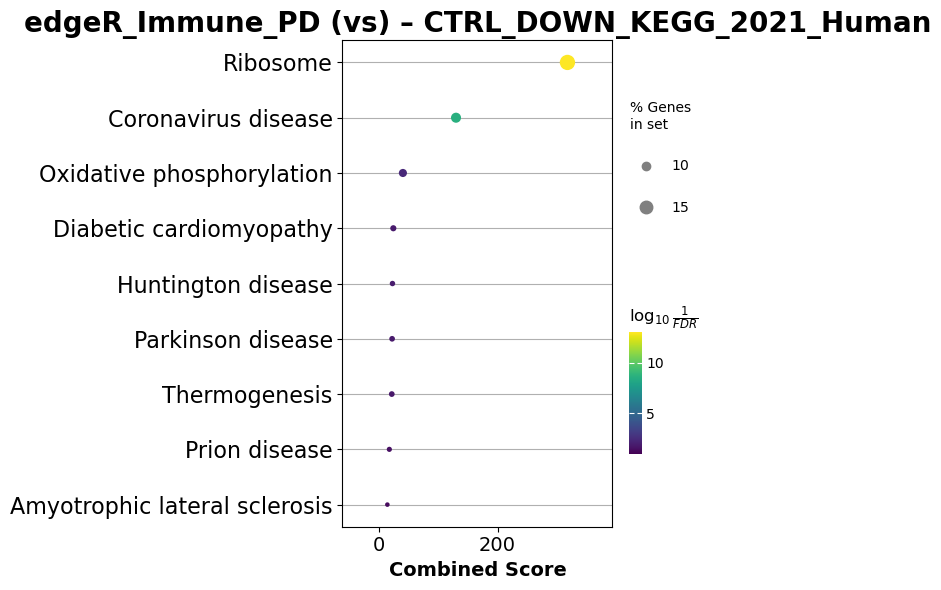

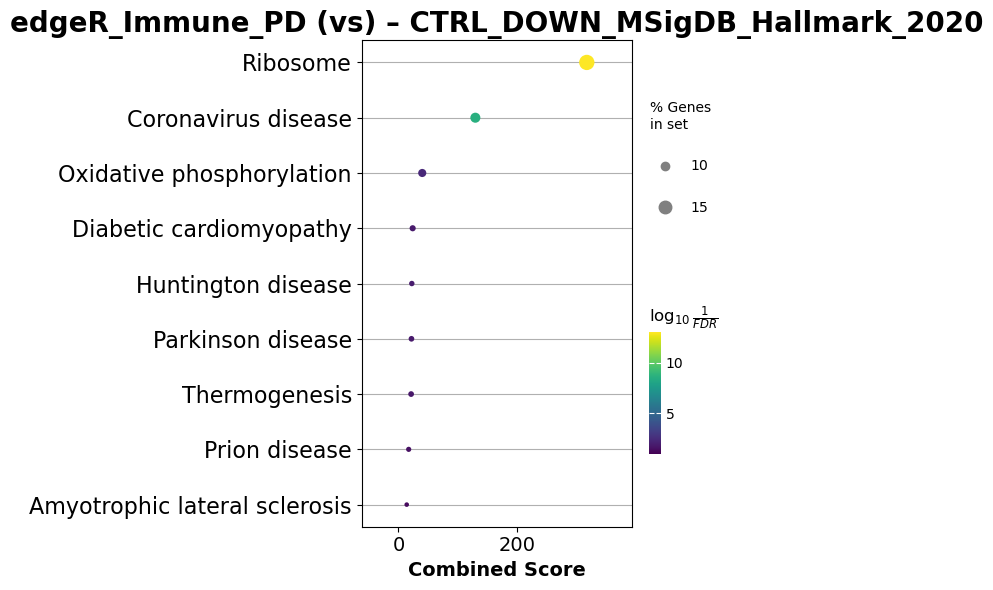

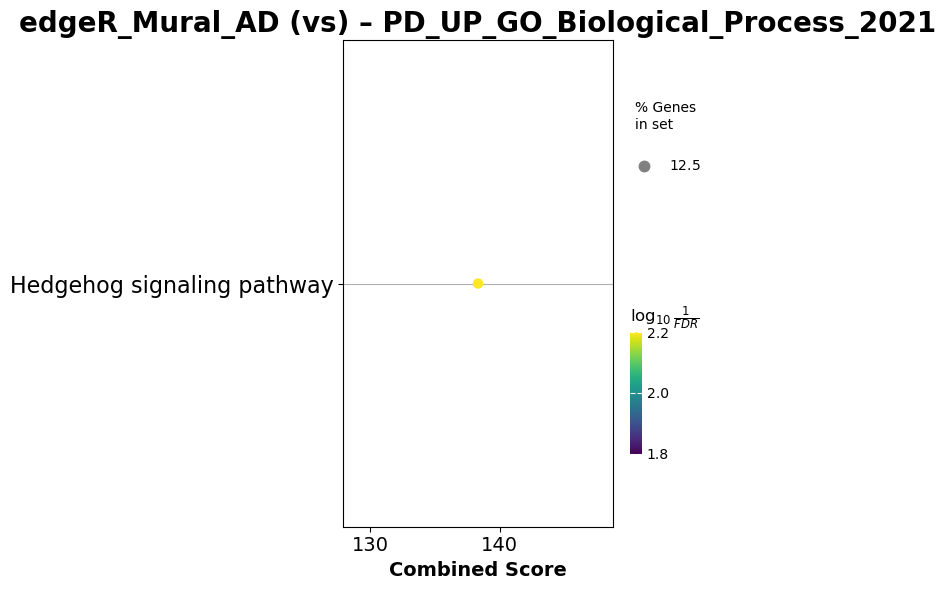

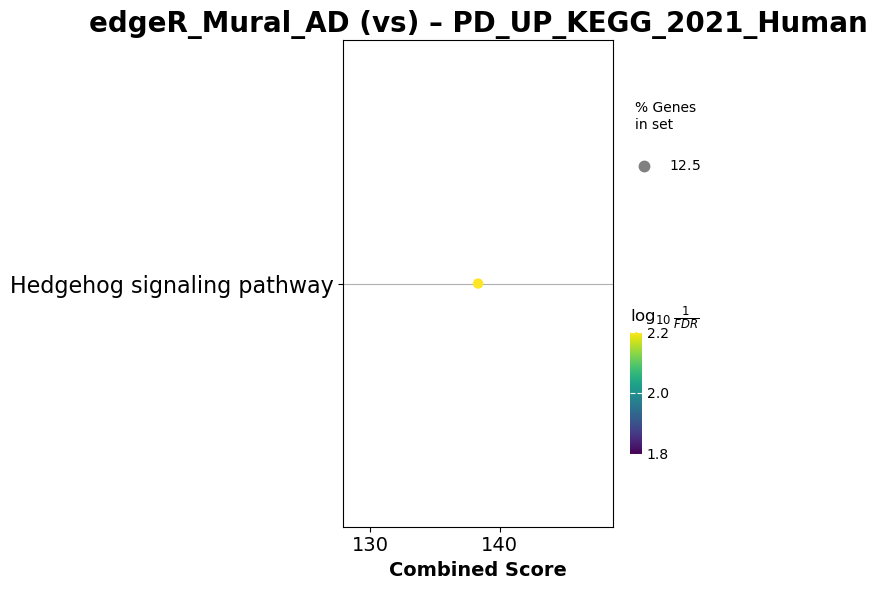

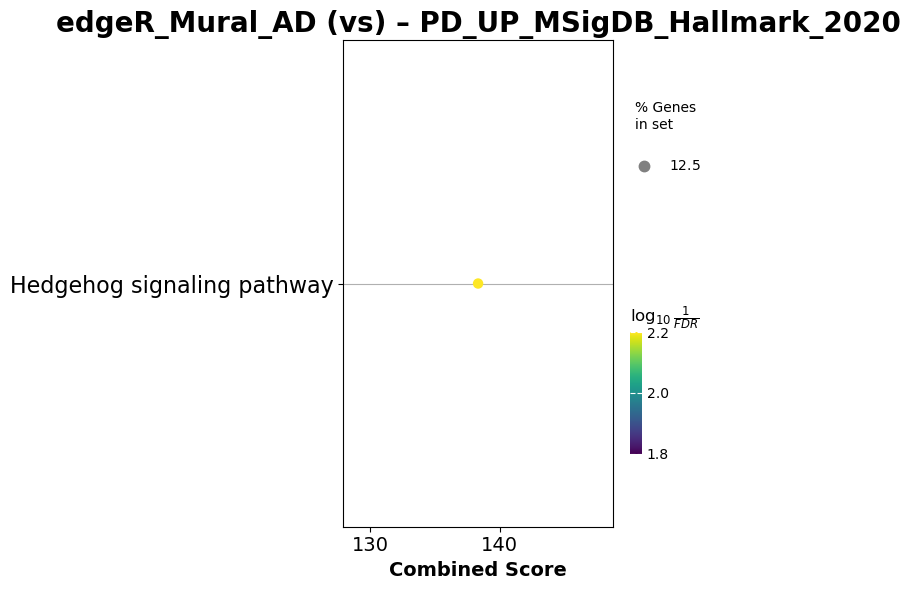

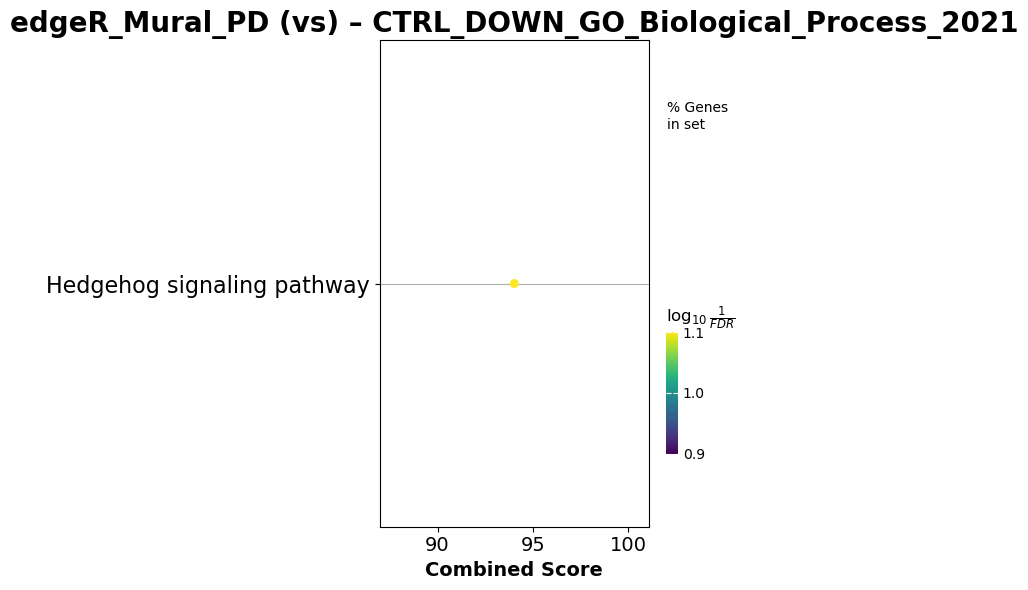

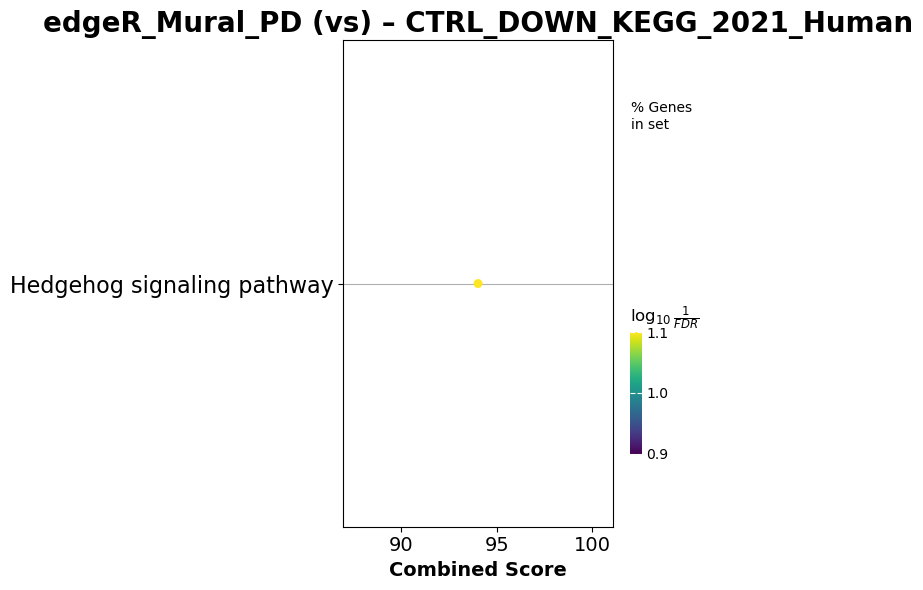

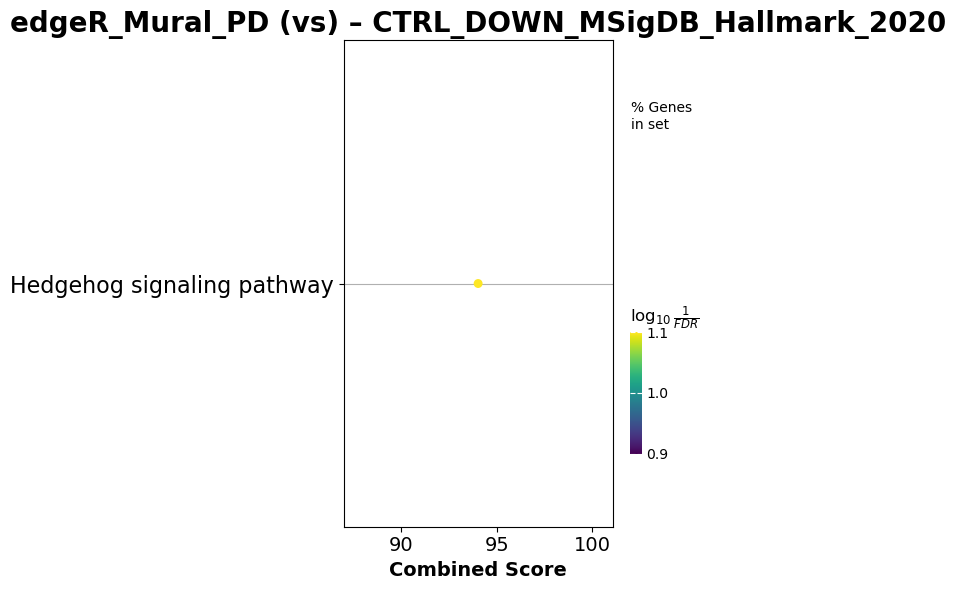

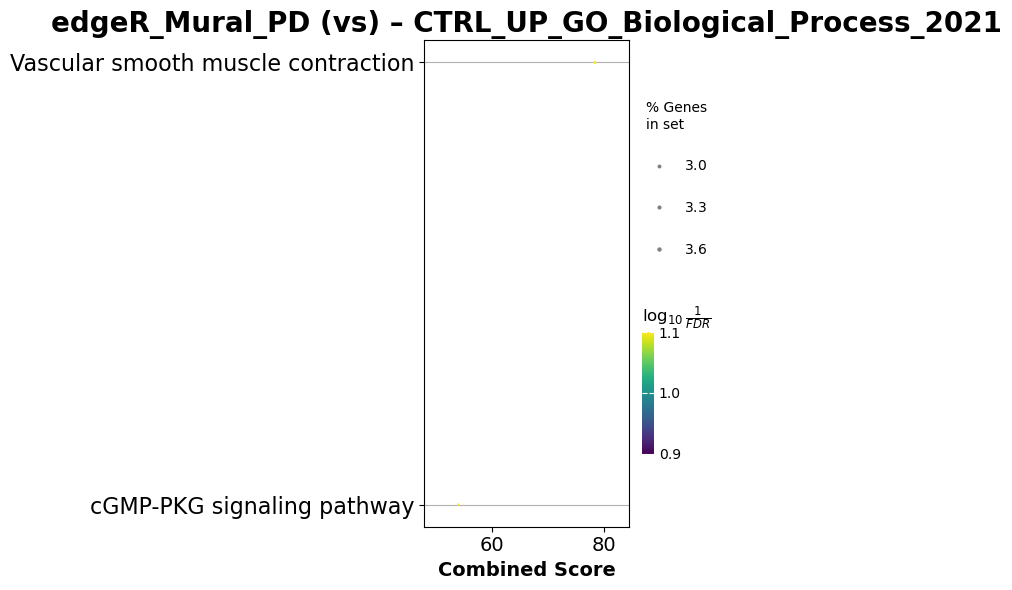

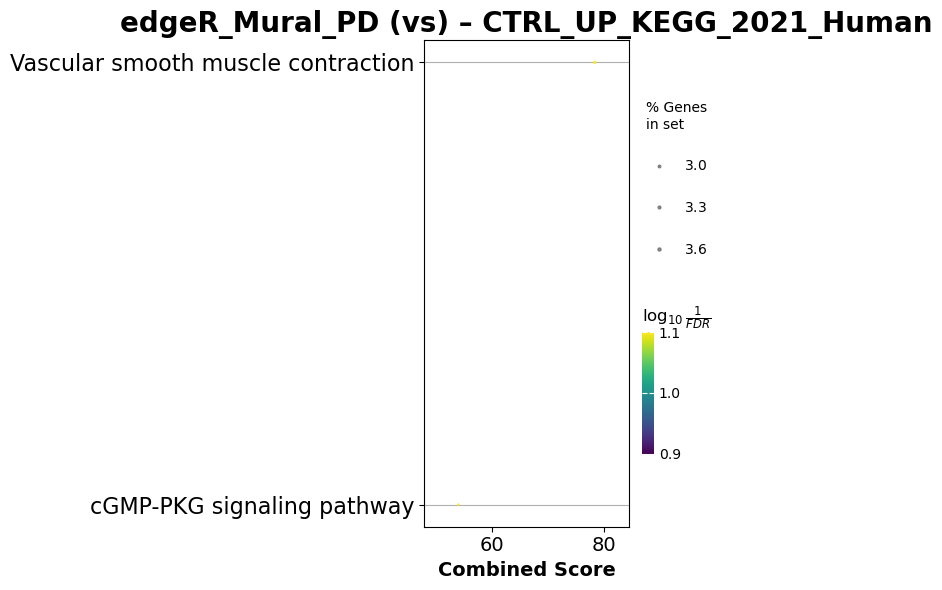

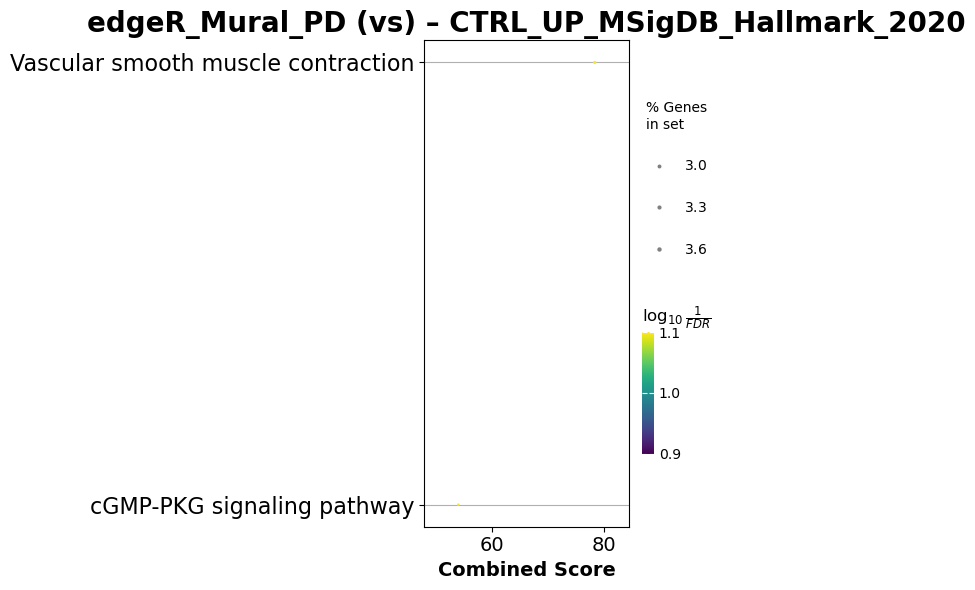

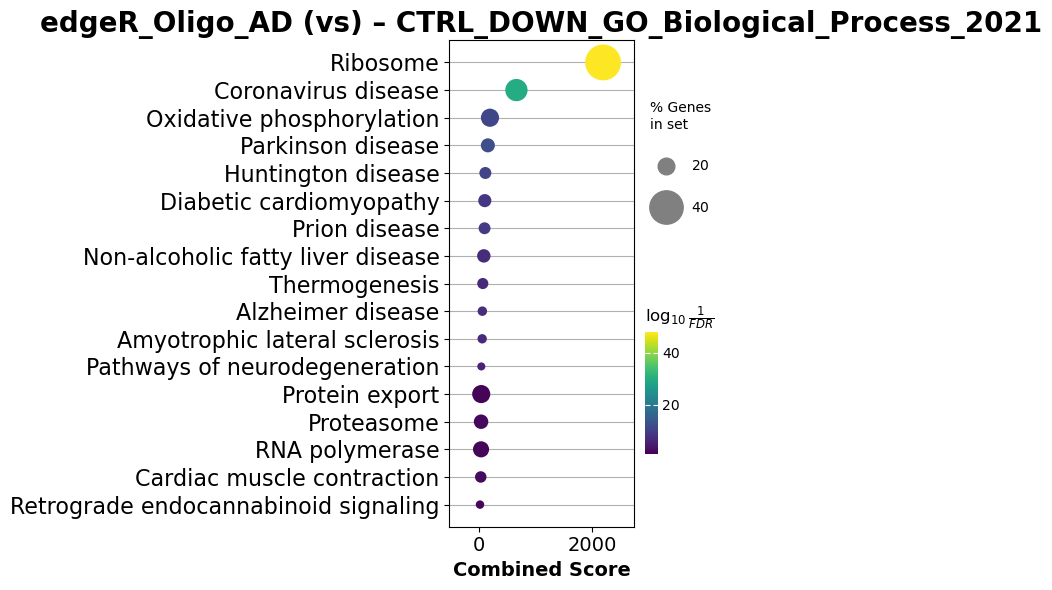

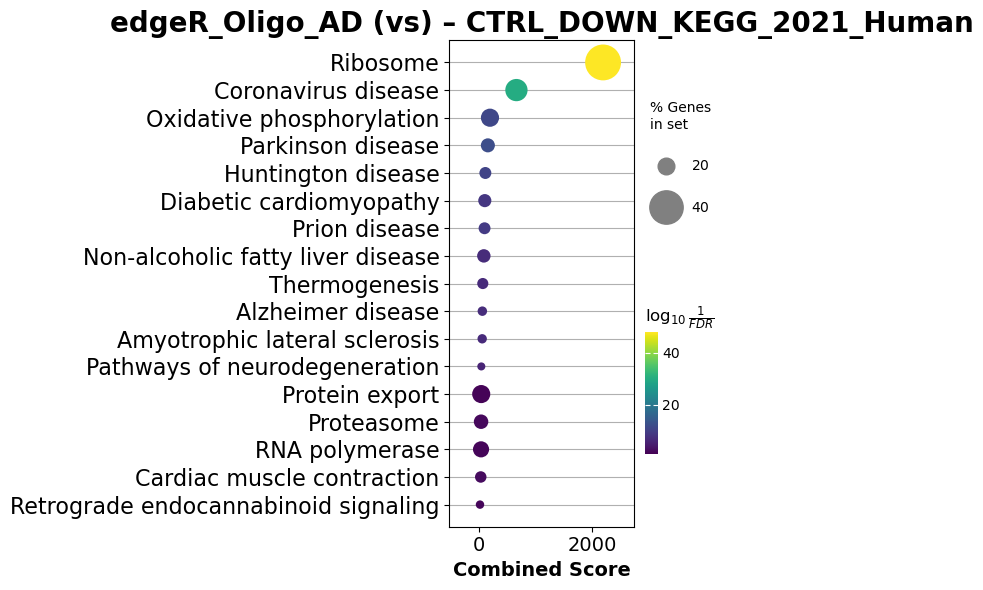

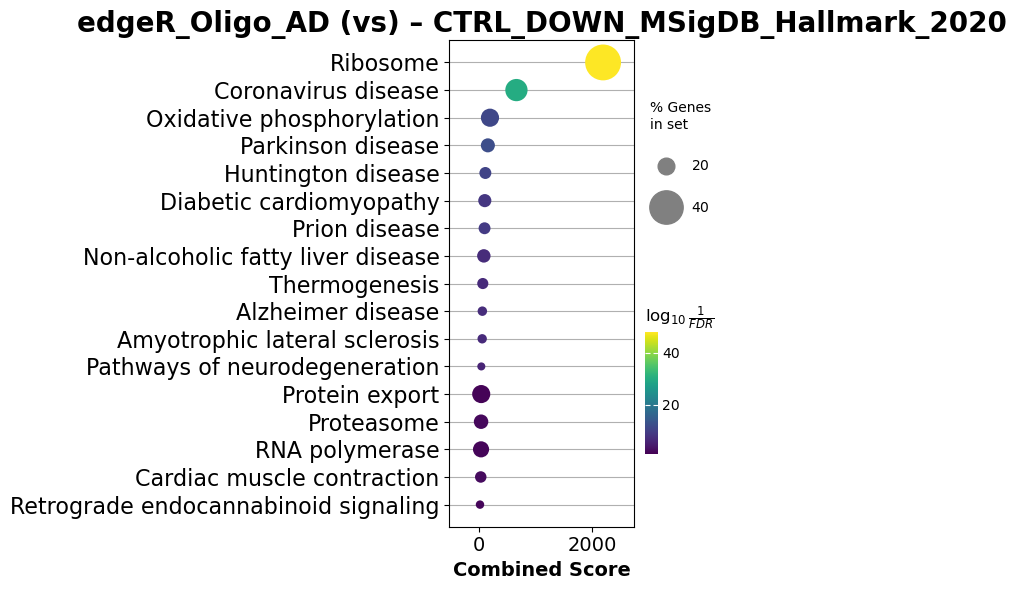

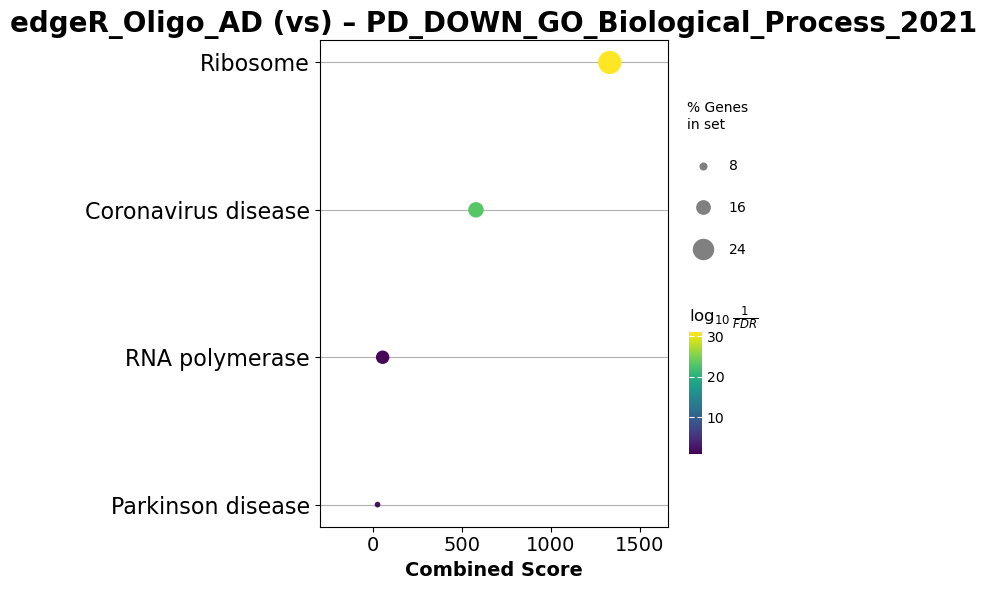

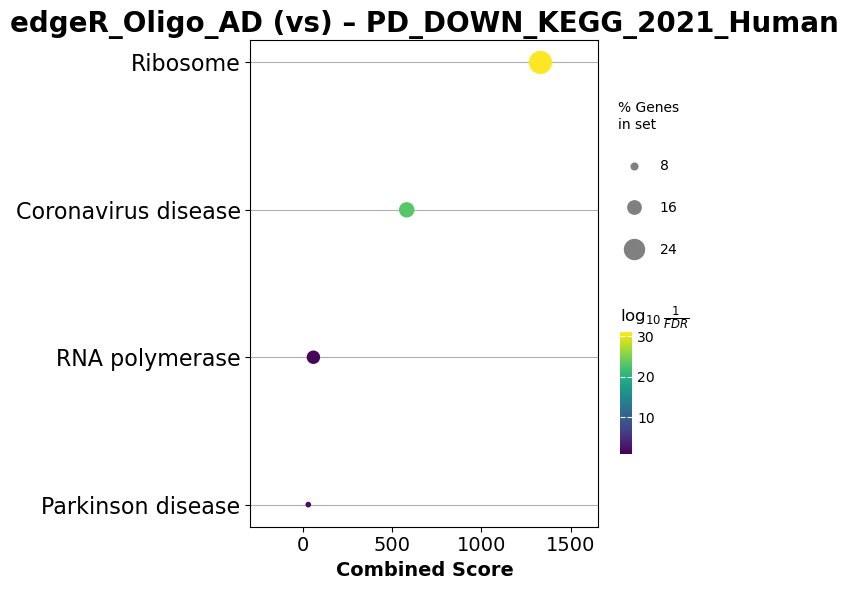

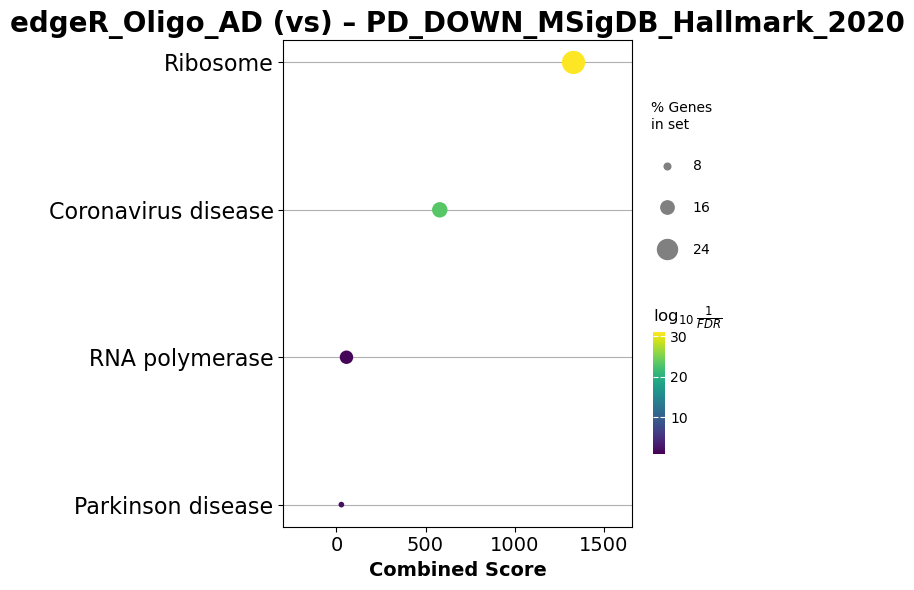

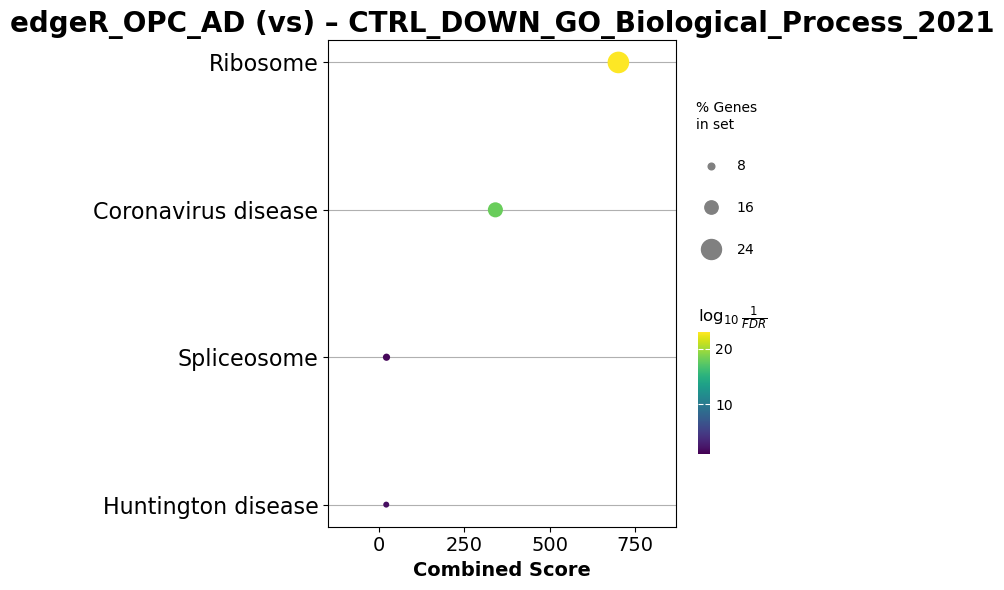

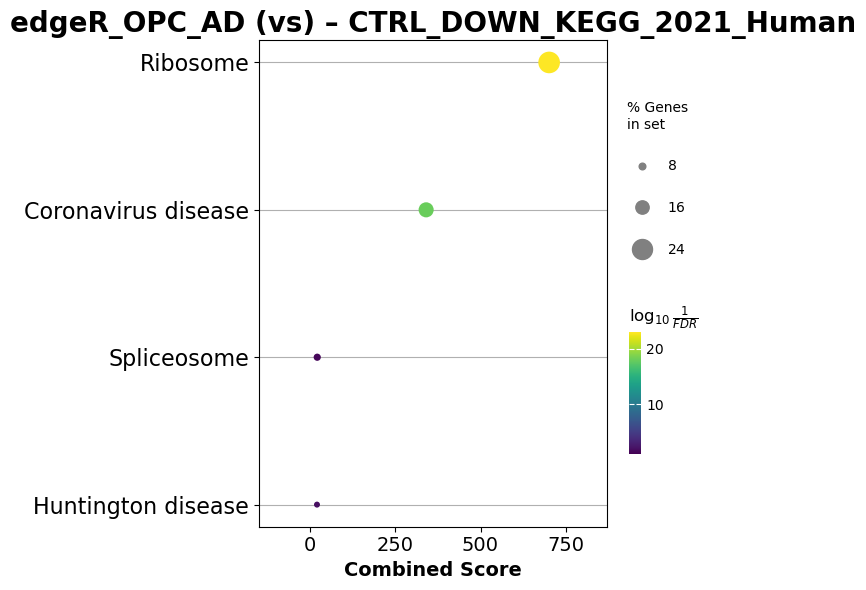

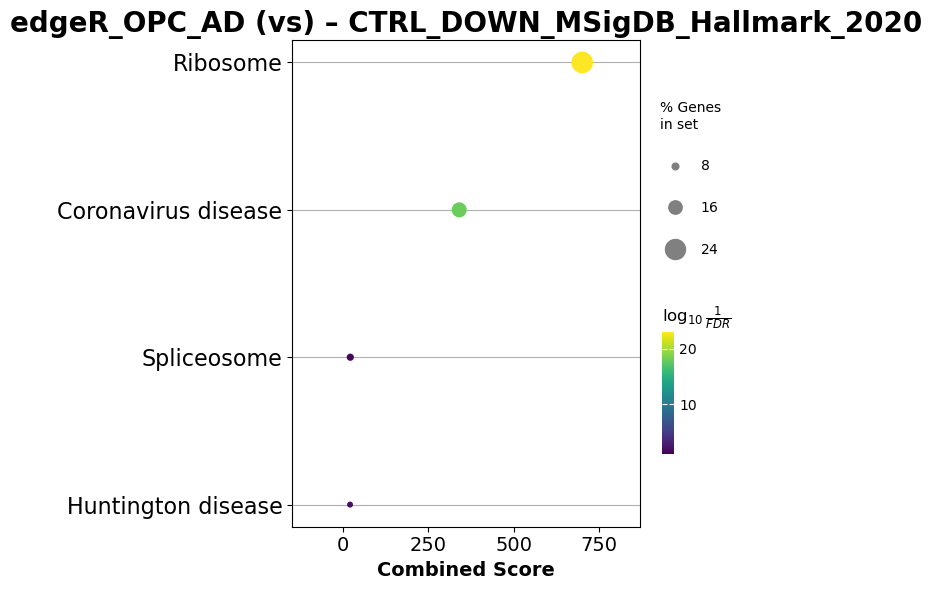

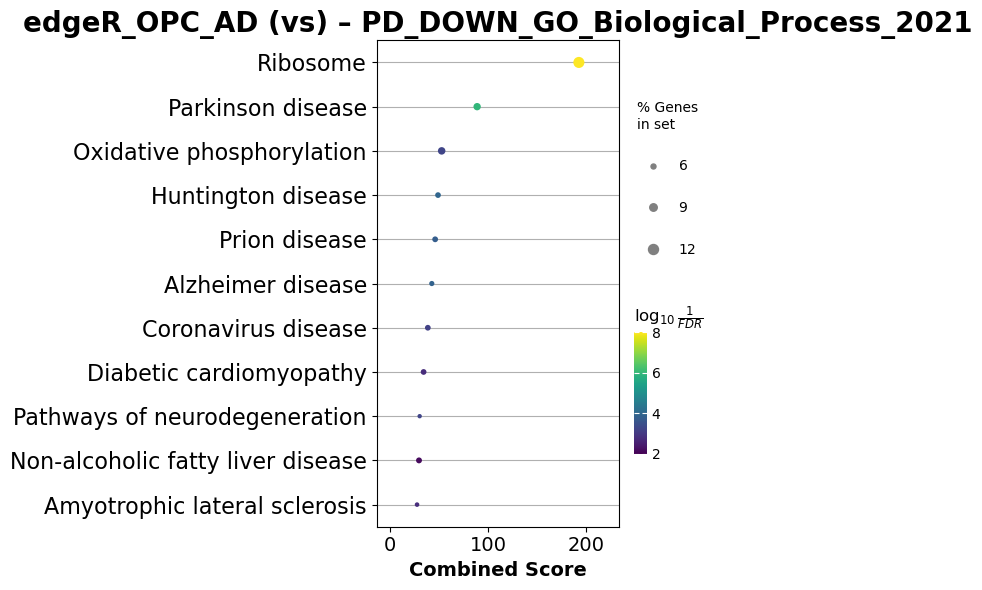

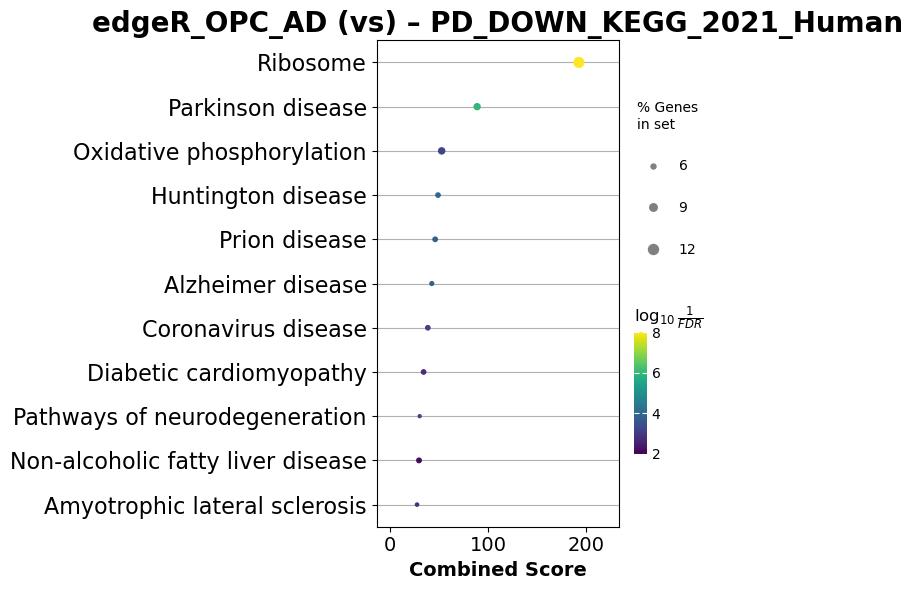

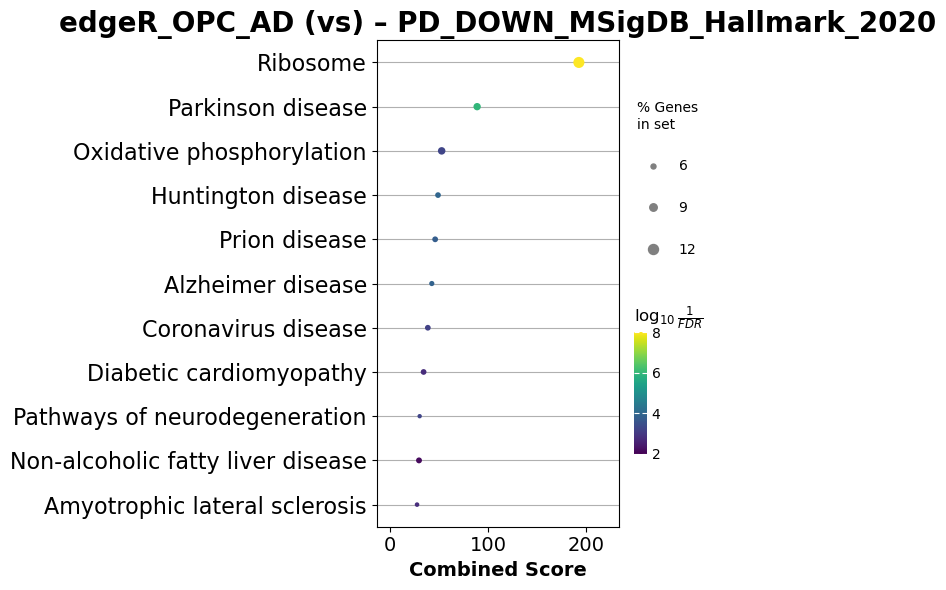

In [ ]:
csv_files = glob.glob(os.path.join(input_folder, "*.csv"))

print("Generating per-condition dotplots...\n")

for f in csv_files:
    base = os.path.basename(f).replace(".csv", "")

    parts = base.split("_")

    comparison = "_".join(parts[0:3])   
    direction = parts[3]                
    lib = "_".join(parts[4:])           

    df = pd.read_csv(f)
    df = clean_enrichr_df(df)

    if df.empty:
        print(f"Skipping empty: {base}")
        continue

    title = f"{comparison} ({direction}) – {lib}"
    outfile = f"{output_folder}/{base}_dotplot.png"

    fig = plot_dotplot(df, title, outfile)

    if fig is None:
        print(f"Failed to plot {base}")
        continue

    fig.savefig(outfile, dpi = 300, bbox_inches = "tight")
    plt.close(fig)

    print(f"Saved: {outfile}")

### ORA: All Sig DEGs

In [ ]:
print("Running ORA on all DEG files...\n")

for file in files:
    df = pd.read_csv(file)

    # Remove missing gene names
    df = df.dropna(subset = ["gene_symbol"])

    # ALL significant DE genes (no direction split)
    all_genes = df[df["PValue"] < 0.05]["gene_symbol"].tolist()

    base = os.path.basename(file).replace(".csv", "")

    if len(all_genes) == 0:
        print(f"No significant genes in {base}")
        continue

    print(f"→ Running ORA for {base} (ALL, {len(all_genes)} genes)")

    try:
        enr = gp.enrichr(
            gene_list = all_genes,
            gene_sets = libs,
            organism = "Human",
            outdir = f"ORA_enrichr_results/{base}_ALL",
            cutoff = 0.5  # keep all significant terms
        )

    except Exception as e:
        print(f"Error running Enrichr for {base}: {e}")
        continue

    # Save results per library
    for lib in libs:
        try:
            df_out = enr.results[enr.results["Gene_set"] == lib]
            outfile = f"ORA_enrichr_results/{base}_ALL_{lib}.csv"
            df_out.to_csv(outfile, index = False)
            print(f"Saved {outfile}")
        except Exception as e:
            print(f"Library {lib} missing for {base}: {e}")

print("\n ORA completed for all DEG files!")

Running ORA on all DEG files...

→ Running ORA for edgeR_Astro_AD_vs_CTRL (ALL, 1796 genes)
Saved ORA_enrichr_results/edgeR_Astro_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Astro_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Astro_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Astro_AD_vs_PD (ALL, 503 genes)


2025-12-12 23:32:35,208 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:32:35,225 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:32:35,233 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_Astro_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Astro_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Astro_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Astro_PD_vs_CTRL (ALL, 1360 genes)


2025-12-12 23:32:40,280 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:32:40,299 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:32:40,308 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_Astro_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Astro_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Astro_PD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Endo_AD_vs_CTRL (ALL, 75 genes)
Saved ORA_enrichr_results/edgeR_Endo_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Endo_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Endo_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Endo_AD_vs_PD (ALL, 196 genes)
Saved ORA_enrichr_results/edgeR_Endo_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Endo_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Endo_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Endo_PD_vs_CTRL (ALL, 176 genes)
Saved ORA_enrichr_results/edgeR_Endo_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Endo_PD_vs_CTRL_ALL_MSig

2025-12-12 23:33:02,788 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:02,800 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:02,814 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_EN_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_EN_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_EN_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_EN_AD_vs_PD (ALL, 630 genes)


2025-12-12 23:33:06,865 [ERROR] Gene set KEGG_2021_Human generated an exception: Error sending gene list, status code: 400
2025-12-12 23:33:06,865 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Error sending gene list, status code: 400
2025-12-12 23:33:08,298 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_EN_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_EN_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_EN_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_EN_PD_vs_CTRL (ALL, 863 genes)


2025-12-12 23:33:13,435 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:13,444 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:13,452 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_EN_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_EN_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_EN_PD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Immune_AD_vs_CTRL (ALL, 521 genes)
Saved ORA_enrichr_results/edgeR_Immune_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Immune_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Immune_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Immune_AD_vs_PD (ALL, 494 genes)


2025-12-12 23:33:24,481 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:24,496 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:24,506 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_Immune_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Immune_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Immune_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Immune_PD_vs_CTRL (ALL, 980 genes)
Saved ORA_enrichr_results/edgeR_Immune_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Immune_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Immune_PD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_IN_AD_vs_CTRL (ALL, 772 genes)


2025-12-12 23:33:35,955 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:35,966 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:35,974 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_IN_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_IN_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_IN_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_IN_AD_vs_PD (ALL, 723 genes)


2025-12-12 23:33:40,432 [ERROR] Gene set KEGG_2021_Human generated an exception: Error sending gene list, status code: 400
2025-12-12 23:33:40,432 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Error sending gene list, status code: 400
2025-12-12 23:33:41,692 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_IN_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_IN_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_IN_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_IN_PD_vs_CTRL (ALL, 935 genes)


2025-12-12 23:33:47,460 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:47,466 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:33:47,484 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_IN_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_IN_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_IN_PD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Mural_AD_vs_CTRL (ALL, 171 genes)
Saved ORA_enrichr_results/edgeR_Mural_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Mural_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Mural_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Mural_AD_vs_PD (ALL, 334 genes)
Saved ORA_enrichr_results/edgeR_Mural_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Mural_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Mural_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_Mural_PD_vs_CTRL (ALL, 353 genes)
Saved ORA_enrichr_results/edgeR_Mural_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Mural_PD_vs_CTRL_ALL_M

2025-12-12 23:34:25,536 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:34:25,537 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:34:25,549 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_Oligo_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_Oligo_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_Oligo_PD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_OPC_AD_vs_CTRL (ALL, 1143 genes)
Saved ORA_enrichr_results/edgeR_OPC_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_OPC_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_OPC_AD_vs_CTRL_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_OPC_AD_vs_PD (ALL, 814 genes)
Saved ORA_enrichr_results/edgeR_OPC_AD_vs_PD_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_OPC_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_OPC_AD_vs_PD_ALL_KEGG_2021_Human.csv
→ Running ORA for edgeR_OPC_PD_vs_CTRL (ALL, 1026 genes)


2025-12-12 23:34:44,800 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:34:44,823 [ERROR] Gene set MSigDB_Hallmark_2020 generated an exception: Warning: No enrich terms when cutoff = 0.5
2025-12-12 23:34:44,838 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.5


Saved ORA_enrichr_results/edgeR_OPC_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv
Saved ORA_enrichr_results/edgeR_OPC_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv
Saved ORA_enrichr_results/edgeR_OPC_PD_vs_CTRL_ALL_KEGG_2021_Human.csv

 ORA completed for all DEG files!


#### Results

In [ ]:
# Load results
GO_ROOT = "ORA_enrichr_results"

go_reports_all = glob.glob(
    os.path.join(GO_ROOT, "*_ALL", "GO_Biological_Process_2021.Human.enrichr.reports.txt"), recursive = True)

print("Found reports for GO:", len(go_reports))

msig_go_reports_all = glob.glob(
    os.path.join(GO_ROOT, "*_ALL", "MSigDB_Hallmark_2020.Human.enrichr.reports.txt"), recursive = True)

print("Found reports for MSigDB:", len(msig_go_reports))

kegg_go_reports_all = glob.glob(
    os.path.join(GO_ROOT, "*_ALL", "KEGG_2021_Human.Human.enrichr.reports.txt"), recursive = True)

print("Found reports for KEGG:", len(kegg_go_reports))

Found reports for GO: 24
Found reports for MSigDB: 24
Found reports for KEGG: 24


#### Plotting the Results:

In [ ]:
input_folder = "ORA_enrichr_results"
output_folder = "ORA_dotplots_ALL"
os.makedirs(output_folder, exist_ok = True)

top_n = 20 # number of pathways to show per dotplot

In [ ]:
csv_files_all = glob.glob(os.path.join(input_folder, "*_ALL_*.csv"))
csv_files_all

['ORA_enrichr_results\\edgeR_Astro_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv',
 'ORA_enrichr_results\\edgeR_Astro_AD_vs_CTRL_ALL_KEGG_2021_Human.csv',
 'ORA_enrichr_results\\edgeR_Astro_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv',
 'ORA_enrichr_results\\edgeR_Astro_AD_vs_PD_ALL_GO_Biological_Process_2021.csv',
 'ORA_enrichr_results\\edgeR_Astro_AD_vs_PD_ALL_KEGG_2021_Human.csv',
 'ORA_enrichr_results\\edgeR_Astro_AD_vs_PD_ALL_MSigDB_Hallmark_2020.csv',
 'ORA_enrichr_results\\edgeR_Astro_PD_vs_CTRL_ALL_GO_Biological_Process_2021.csv',
 'ORA_enrichr_results\\edgeR_Astro_PD_vs_CTRL_ALL_KEGG_2021_Human.csv',
 'ORA_enrichr_results\\edgeR_Astro_PD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv',
 'ORA_enrichr_results\\edgeR_Endo_AD_vs_CTRL_ALL_GO_Biological_Process_2021.csv',
 'ORA_enrichr_results\\edgeR_Endo_AD_vs_CTRL_ALL_KEGG_2021_Human.csv',
 'ORA_enrichr_results\\edgeR_Endo_AD_vs_CTRL_ALL_MSigDB_Hallmark_2020.csv',
 'ORA_enrichr_results\\edgeR_Endo_AD_vs_PD_ALL_GO_Biological_Process_2021.csv',
 

In [ ]:
print("Generating per-condition dotplots...\n")

for f in csv_files_all:
    base = os.path.basename(f).replace(".csv", "")

    parts = base.split("_")

    comparison = "_".join(parts[0:3])   
    direction = parts[3]                
    lib = "_".join(parts[4:])           

    df = pd.read_csv(f)
    df = clean_enrichr_df(df)

    if df.empty:
        print(f"Skipping empty: {base}")
        continue

    title = f"{comparison} ({direction}) – {lib}"
    outfile = f"{output_folder}/{base}_dotplot.png"

    fig = plot_dotplot(df, title, outfile)

    if fig is None:
        print(f"Failed to plot {base}")
        continue

    fig.savefig(outfile, dpi = 300, bbox_inches = "tight")
    plt.close(fig)

    print(f"Saved: {outfile}")

Generating per-condition dotplots...



NameError: name 'csv_files_all' is not defined

# **Compositional Analysis**
Using the scCODA package

## Data Preparation

In [ ]:
# Cleaning the disease column labels
adata.obs["disease"] = (
    adata.obs["disease"]
    .replace({
        "dementia || Alzheimer disease": "AD",
        "dementia || Parkinson disease": "PD",
        "normal": "CTRL"
    })
)

In [ ]:
covariate_df = adata.obs[["donor_id", "disease"]].drop_duplicates()
covariate_df = covariate_df.set_index("donor_id")

In [ ]:
sccoda_data = dat.from_scanpy(adata, 
                              cell_type_identifier = "class", 
                              sample_identifier = "donor_id",
                              covariate_df = covariate_df
                              )

## Model setup and inference

In [ ]:
sccoda_model = mod.CompositionalAnalysis(
    data = sccoda_data,
    formula = "disease",
    reference_cell_type = "automatic"
)

In [ ]:
# Run MCMC
sccoda_res = sccoda_model.sample_hmc()

## Results:

In [ ]:
sccoda_res.summary()

In [ ]:
# Credible effects:
print(sccoda_res.credible_effects())